# Finding Unstable mode

In [1]:
%reset -f
import numpy as np
import sys, time, copy
sys.path.append('../PyRADISEgit')
import matplotlib.pyplot as plt
import pickle as pkl
from scipy import interpolate
import matplotlib.cm as cm
from scipy import constants as const

# PySSD
import seaborn as sns
from PySSD.Distribution import Distribution,Gaussian
from PySSD.Detuning import LinearDetuning
# from PySSD.Dispersion import Dispersion
from PySSD.Integrator import Integrator #FixedTrapezoidalIntegrator, SimpsonIntegrator, TrapzIntegrator, DblquadIntegrator
from PyRADISE.PySSDHelper  import get_tune_range, findQs
from PyRADISE.Coefficients import calc_LandauDampedOneMode
import PyRADISE.L2D2_functions as L2D2
# Plotting preparation

from plot_configuration import *
np.set_printoptions(formatter=None,precision=3,suppress=False) 
plt.close('all')

pltstorage = '01_Plots/'
pi2 = 2*np.pi

Finished configuring the plots.


In [3]:
%matplotlib notebook

class empty():
    # Similar as the one I use in PyRADISE
    pass

## Big functions

In [6]:
def calc_CapitalOmega(distribution,detuning,integrator_epsilon,Q0,modeDQ,tol=1e-4,flagFindalpha=[1,1],debug=0,JMaxSD=18):    
    # Additional integrators
    integrator1 = Integrator(distribution, detuning, maxJ=JMaxSD,epsilon=integrator_epsilon*1)
    integrator2 = Integrator(distribution, detuning, maxJ=JMaxSD,epsilon=integrator_epsilon*2)
    integrator4 = Integrator(distribution, detuning, maxJ=JMaxSD,epsilon=integrator_epsilon*4)
    
    return calc_LandauDampedOneMode(integrator_epsilon,integrator1,integrator2, integrator4,Q0,modeDQ,
                                   tol=tol,flagFindalpha=flagFindalpha,debug=debug)

def calc_CapitalOmega2(distribution,detuning,integrator_epsilon,Q0,modeDQ,tol=1e-4,flagFindalpha=[1,1],debug=0):    
    absModeDQ = np.abs(modeDQ) # Absolute value of undamped mode - used to find accuracy of mode
    
    # Additional integrators
    integrator1 = Integrator(distribution, detuning, maxJ=18,epsilon=integrator_epsilon*1)
    integrator2 = Integrator(distribution, detuning, maxJ=18,epsilon=integrator_epsilon*2)
    integrator4 = Integrator(distribution, detuning, maxJ=18,epsilon=integrator_epsilon*4)
    
    # Estimate of damped mode corresponding to free mode
    dampDQ = modeDQ.real + 1j*integrator_epsilon
    
    #debug
    if debug:
        dampDQs=[dampDQ]
        modeDQs=[]
    
    cnt = 0
    err = 0
    while True and absModeDQ>0:
        if dampDQ.imag<=integrator_epsilon*1 or 0:
            # Taylor approach to getting stabilized Omega
            tempDQ = 2*integrator1.integrate(Q0+dampDQ.real) - 1*integrator2.integrate(Q0+dampDQ.real)+1j*(dampDQ.imag)
            flag_taylor=True
        else:
            # Original approach to getting unstable Omega
#             integrator1._detuning += 1j*(integrator_epsilon - dampDQ.imag)
#             tempDQ=integrator1.integrate(Q0+dampDQ.real)
#             integrator1._detuning -= 1j*(integrator_epsilon - dampDQ.imag)
            tempDQ=integrator1.integrate(Q0+dampDQ.real + 1j*dampDQ.imag)
            flag_taylor=False
        
        # Calculate error
        errold= err
        err   = tempDQ-modeDQ

        # Break if within tolerance
        if np.abs(err)<absModeDQ*tol:
            break

        ## Update dampDQ (damped mode tune)
        if cnt==0:
            # Simple method
            dDampDQ  =-(err*.5+errold*.05) 
        else:
            # Newton's method
            dDampdMode = (dDampDQ)/(err-errold)
            dDampDQ    = -err*dDampdMode 
        dampDQ = dampDQ + dDampDQ
        
        #debug
        if debug or cnt>40 :
            print("%2d:dampDQ=%11.4e + %11.4ei | err=%10.2e + %10.2ei - relerr=%.1e"%(
                cnt,dampDQ.real,dampDQ.imag,err.real,err.imag,np.abs(err)/absModeDQ))
            if debug:
                modeDQs+=[tempDQ]
                dampDQs+=[dampDQ]
        
            
        # Break if tried 50 times 
        if cnt>50:
            break
        
        cnt+=1

    # Calc alpha
    alpha=1
    if np.any(np.abs(flagFindalpha)>0) and flag_taylor:
        # Calculate alpha 
        alpha =  2j*integrator_epsilon/(
                    integrator4.integrate(Q0+dampDQ.real)-integrator2.integrate(Q0+dampDQ.real))
        # Use the parts of alpha as given by flagFindalpha
        alpha = alpha.real*flagFindalpha[0] + 1j*alpha.imag*flagFindalpha[1]
        dampDQold = dampDQ
        dampDQ = dampDQ.real + 1j*alpha*dampDQ.imag
        if debug:
            print('Found alpha!=1, alpha=%.2e %s%.2ej |  dampDQ = %.2e %s%.3ej -> %.2e %s%.3ej'%(
                        alpha.real,['+','-'][np.sign(alpha.imag)<0],np.abs(alpha.imag),
                        dampDQold.real,['+','-'][np.sign(dampDQold.imag)<0],np.abs(dampDQold.imag),
                        dampDQ.real,['+','-'][np.sign(dampDQ.imag)<0],np.abs(dampDQ.imag)))
        
        
    if debug :
        modeDQs = np.array(modeDQs)
        dampDQs = np.array(dampDQs[:-1])
        print('modeDQ',modeDQs)
        print('dampDQ',dampDQs[1:])
    return dampDQ , cnt, alpha, np.abs(err)/absModeDQ


ax = 1.2e-4
bx = 0
Qx = 0.31
wmode_DQ = 0+1e-4j
wmodeQ0x = Qx
wmodeDipm= 1
integrator_epsilon = 1e-6 * ax/1e-4 *[1,4][bx==0]
flagFindalpha=[1,1]
detuning = LinearDetuning(Qx,ax,bx)
distribution = Gaussian()



dampDQ,cnt,alpha,relerr=calc_CapitalOmega(distribution,detuning,integrator_epsilon,Qx,wmode_DQ,tol=1e-4,flagFindalpha=[1,1],debug=1)
print('\nAfter %d steps: dampDQ = %.2e %s%.3ej | relerr=%.2e\n'%(cnt,
                                               dampDQ.real,['+','-'][np.sign(dampDQ.imag)<0],np.abs(dampDQ.imag),
                                               relerr))

dampDQ,cnt,alpha,relerr=calc_CapitalOmega2(distribution,detuning,integrator_epsilon,Qx,wmode_DQ,tol=1e-4,flagFindalpha=[1,1],debug=1)
print('\nAfter %d steps: dampDQ = %.2e %s%.3ej | relerr=%.2e\n'%(cnt,
                                               dampDQ.real,['+','-'][np.sign(dampDQ.imag)<0],np.abs(dampDQ.imag),
                                               relerr))

 0:  6.0671e-05 +  5.0019e-05i |  -1.21e-04 +  -9.04e-05i - relerr=1.5e+00
 1:  1.0629e-04 +  3.7019e-06i |  -9.16e-05 +   1.31e-05i - relerr=9.3e-01
 2:  1.4047e-04 + -9.8136e-06i |  -3.38e-05 +  -4.24e-06i - relerr=3.4e-01
 3:  1.6533e-04 + -5.4482e-06i |  -1.30e-05 +  -6.30e-06i - relerr=1.4e-01
 4:  1.6002e-04 + -9.5607e-06i |   2.26e-06 +   4.41e-06i - relerr=5.0e-02
 5:  1.6138e-04 + -9.0055e-06i |  -1.00e-06 +  -9.37e-07i - relerr=1.4e-02
 6:  1.6160e-04 + -9.0237e-06i |  -1.67e-07 +  -5.88e-08i - relerr=1.8e-03
 7:  1.6167e-04 + -9.0016e-06i |  -3.56e-08 +  -2.66e-08i - relerr=4.4e-04
 8:  1.6165e-04 + -9.0116e-06i |   5.57e-09 +   1.12e-08i - relerr=1.2e-04
Found alpha!=1, alpha=1.37e+00 -4.99e-01j |  dampDQ = 1.62e-04 -9.012e-06j -> 1.57e-04 -1.234e-05j
[-1.213e-04+9.563e-06j -9.162e-05+1.131e-04j -3.385e-05+9.576e-05j
 -1.296e-05+9.370e-05j  2.256e-06+1.044e-04j -1.004e-06+9.906e-05j
 -1.670e-07+9.994e-05j -3.558e-08+9.997e-05j  5.573e-09+1.000e-04j] [6.067e-05+5.002e-05j 1.

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:118: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


 0:dampDQ= 6.0671e-05 +  5.0019e-05i | err= -1.21e-04 +  -9.04e-05i - relerr=1.5e+00
 1:dampDQ= 1.0629e-04 +  3.7019e-06i | err= -9.16e-05 +   1.31e-05i - relerr=9.3e-01
 2:dampDQ= 1.4047e-04 + -9.8136e-06i | err= -3.38e-05 +  -4.24e-06i - relerr=3.4e-01
 3:dampDQ= 1.6533e-04 + -5.4482e-06i | err= -1.30e-05 +  -6.30e-06i - relerr=1.4e-01
 4:dampDQ= 1.6002e-04 + -9.5607e-06i | err=  2.26e-06 +   4.41e-06i - relerr=5.0e-02
 5:dampDQ= 1.6138e-04 + -9.0055e-06i | err= -1.00e-06 +  -9.37e-07i - relerr=1.4e-02
 6:dampDQ= 1.6160e-04 + -9.0237e-06i | err= -1.67e-07 +  -5.88e-08i - relerr=1.8e-03
 7:dampDQ= 1.6167e-04 + -9.0016e-06i | err= -3.56e-08 +  -2.66e-08i - relerr=4.4e-04
 8:dampDQ= 1.6165e-04 + -9.0116e-06i | err=  5.57e-09 +   1.12e-08i - relerr=1.2e-04
Found alpha!=1, alpha=1.37e+00 -4.99e-01j |  dampDQ = 1.62e-04 -9.012e-06j -> 1.57e-04 -1.234e-05j
modeDQ [-1.213e-04+9.563e-06j -9.162e-05+1.131e-04j -3.385e-05+9.576e-05j
 -1.296e-05+9.370e-05j  2.256e-06+1.044e-04j -1.004e-06+9.906e

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:90: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:92: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:123: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


In [16]:
# # def calc_LandauDampedWmodes(self,plane=0,relstep=1,tol=1e-2,debug=0,flagFindalpha=0):
# #     global Wjs, wjs
# # #     modeLDDQ = np.zeros_like(self.mode__DQ)
    
# #     if plane==0:
# #         wmode__DQ = self.M.wmode__DQx
# #         wmodeLdDQ = self.M.wmodeLdDQx
# #         Q0 = self.M.Q.Q0x
# #     else:
# #         wmode__DQ = self.M.wmode__DQy
# #         wmodeLdDQ = self.M.wmodeLdDQy
# #         Q0 = self.M.Q.Q0y
        
# #     integrator = TrapzIntegrator(distribution, detuning, maxJ=18)
    
# #     # Find damped mode
# #     for i, modeDQ in enumerate(wmode__DQ):
# #         # Absolute value of undamped mode - used to find accuracy of mode
# #         absModeDQ = np.abs(modeDQ)
        
# #         # Estimate of damped mode corresponding to free mode
# #         dampDQ = modeDQ.real + 1j*integrator_epsilon
        
# #         #debug
# #         if debug:
# #             dampDQs=[dampDQ]
# #             modeDQs=[]
        
        
# #         cnt=0
# #         err = 0
# #         while True:
# #             if dampDQ.imag<=self.integrator_epsilon:
# #                 tempDQ = 2*integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon)- \
# #                            integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon*2)+\
# #                             1j*(dampDQ.imag)
# #                 print(cnt,'Damped mode')
# #             else:
# # #                 tempDQ = integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon)+ \
# # #                             1j*(dampDQ.imag-self.integrator_epsilon)
# # #                 print(cnt,'Not damped mode')
# #                 tempDQ=integrator.integrate(Qx+dampDQ,epsilon=0)
            
# #             errold=err
# #             err   = tempDQ-modeDQ
# # #             dampDQ= dampDQ-(err + errold) * relstep 
# #             dampDQ= dampDQ-(err ) * relstep 
            
# #             #debug
# #             if debug:
# #                 print("%2d: %10.2e + %10.2ei - relerr=%.1e"%(cnt,err.real,err.imag,np.abs(err)/absModeDQ))
# #                 modeDQs+=[tempDQ]
# #                 dampDQs+=[dampDQ]
                
# #             # Break if ready
# #             if cnt>10:
# #                 break
# #             if np.abs(err)<absModeDQ*tol:
# #                 break
# #             cnt+=1
        
# #         if debug:
# #             modeDQs = np.array(modeDQs)
# #             dampDQs = np.array(dampDQs[:-1])
# #             print(modeDQs,dampDQs)
        
# #             Wjs = dampDQs
# #             wjs = modeDQs
            
# #         # include that alpha!=1
# #         if flagFindalpha:
# #             alpha = 1j*self.integrator_epsilon/(
# #                         integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon*2)-
# #                         integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon))
# #             print('Found alpha!=1, alpha=%.2e+%.2ei'%(alpha.real,alpha.imag))
# #             print(self.integrator_epsilon,integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon*2),integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon))
# #             dampDQ = dampDQ.real + 1j*alpha*dampDQ.imag
            
# #         wmodeLdDQ[i] = dampDQ
        
        
            
    
# #     if plane==0:
# #         self.M.wmodeLdDQx = wmodeLdDQ
# #     else:
# #         self.M.wmodeLdDQy = wmodeLdDQ

# #     return

# def calc_LandauDampedOneMode(self,integrator1,integrator2,integrator4,Q0,modeDQ,relstep=[.5,.05],tol=1e-4,flagFindalpha=[1,1],debug=0):    
#     global Wjs, wjs, Wji
#     absModeDQ = np.abs(modeDQ) # Absolute value of undamped mode - used to find accuracy of mode
    
#     # Estimate of damped mode corresponding to free mode
#     dampDQ = modeDQ.real + 1j*self.integrator_epsilon
    
#     #debug
#     if debug:
#         dampDQs=[dampDQ]
#         modeDQs=[]
    
#     cnt=0
#     err = 0
#     while True and absModeDQ>0:
#         if dampDQ.imag<=self.integrator_epsilon*1:
# #            tempDQ = integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon)+ \
# #                        1j*(dampDQ.imag-self.integrator_epsilon)
# #            tempDQ = 2*integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon)  - \
# #                       integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon*2)+ \
# #                        1j*(dampDQ.imag)
#             tempDQ = 2*integrator1.integrate(Q0+dampDQ.real) - 1*integrator2.integrate(Q0+dampDQ.real)+1j*(dampDQ.imag)
#             flag_taylor=True
#         else:
#             #tempDQ=integrator.integrate(Q0+dampDQ.real,epsilon=dampDQ.imag)
#             integrator1._detuning += 1j*(self.integrator_epsilon - dampDQ.imag)
#             tempDQ=integrator1.integrate(Q0+dampDQ.real)
#             integrator1._detuning -= 1j*(self.integrator_epsilon - dampDQ.imag)
#             flag_taylor=False
        
#         # Calculate error
#         errold= err
#         err   = tempDQ-modeDQ

#         # Break if within tolerance
#         if np.abs(err)<absModeDQ*tol:
#             break

#         ## Update dampDQ (damped mode tune)
#         if cnt==0:
#             # Simple method
#             dDampDQ  =-(err*relstep[0]+errold*relstep[1]) 
#         else:
#             # Newton's method
#             dDampdMode = (dDampDQ)/(err-errold)
#             dDampDQ    = -err*dDampdMode #* 0.8**(cnt//10)
#         dampDQ = dampDQ + dDampDQ
        
#         #debug
#         if debug or cnt>40 :
#             print("%2d: %11.4e + %11.4ei | %10.2e + %10.2ei - relerr=%.1e"%(
#                 cnt,dampDQ.real,dampDQ.imag,err.real,err.imag,np.abs(err)/absModeDQ))
#             if debug:
#                 modeDQs+=[tempDQ]
#                 dampDQs+=[dampDQ]
        
            
#         # Break if tried 50 times 
#         if cnt>50:
#             break
        
#         cnt+=1
#         if cnt%10==0:
#             relstep=[relstep[0]*0.8,relstep[1]*0.8]
#             if debug:
#                 print("Reduced relstep to [%.2f,%.2f]"%(relstep[0],relstep[1]))

#     # Calc alpha
#     if np.any(np.abs(flagFindalpha)>0) and flag_taylor:
# #        alpha = 2j*self.integrator_epsilon/(
# #                        integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon*4)-
# #                        integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon*2))
#         alpha =  2j*self.integrator_epsilon/(
#                     integrator4.integrate(Q0+dampDQ.real)-integrator2.integrate(Q0+dampDQ.real))
#         alpha = alpha.real*flagFindalpha[0] + 1j*alpha.imag*flagFindalpha[1]
#         if flagFindalpha[0]==-1:
#             alpha = -1/alpha.real + 1j*alpha.imag
#         dampDQold = dampDQ
#         dampDQ = dampDQ.real + 1j*alpha*dampDQ.imag
#         print('Found alpha!=1, alpha=%.2e %s%.2ej |  dampDQ = %.2e %s%.3ej -> %.2e %s%.3ej'%(
#                     alpha.real,['+','-'][np.sign(alpha.imag)<0],np.abs(alpha.imag),
#                     dampDQold.real,['+','-'][np.sign(dampDQold.imag)<0],np.abs(dampDQold.imag),
#                     dampDQ.real,['+','-'][np.sign(dampDQ.imag)<0],np.abs(dampDQ.imag)))
        
        
#     if debug :
#         modeDQs = np.array(modeDQs)
#         dampDQs = np.array(dampDQs[:-1])
#         print(modeDQs,dampDQs)
#         Wjs = dampDQs
#         wjs = modeDQs
#         Wji = dampDQ.copy()
#     return dampDQ , cnt, np.abs(err)/absModeDQ

# def calc_LandauDampedAllModes(self,plane=0,relstep=[.5,.05],tol=1e-4,flagFindalpha=[1,1],debug=0,flagUpdateReQ=1,epsilon=1e-6):
#     if plane==0:
#         wmode__DQ = self.M.wmode__DQx
# #        wmodeMgDQ = self.M.wmodeMgDQx
#         wmodeLdDQ = self.M.wmodeLdDQx
#         wmodeQ0   = self.M.wmodeQ0x
# #        wmodeQ0   = self.M.Q.Q0x
#         Q0   = self.M.Q.Q0x
#         distribution=Gaussian()
#         detuning = self.M.Q 
#     else:
#         wmode__DQ = self.M.wmode__DQy
# #        wmodeMgDQ = self.M.wmodeMgDQy
#         wmodeLdDQ = self.M.wmodeLdDQy
#         wmodeQ0   = self.M.wmodeQ0y
# #        wmodeQ0   = self.M.Q.Q0y
#         Q0   = self.M.Q.Q0y
#         distribution=Gaussian()
#         detuning = self.M.Q
        
# #    integrator = TrapzIntegrator(distribution, detuning, maxJ=18)
#     integrator1 = Integrator(distribution, detuning, maxJ=18,epsilon=self.integrator_epsilon*1)
#     integrator2 = Integrator(distribution, detuning, maxJ=18,epsilon=self.integrator_epsilon*2)
#     integrator4 = Integrator(distribution, detuning, maxJ=18,epsilon=self.integrator_epsilon*4)
#     if np.size(relstep)==1:
#         relstep = [relstep,0]
#     # Find damped mode
#     for i, modeDQ in enumerate(wmode__DQ):
# #         modeQ0 = wmodeQ0[i]   # irrelevant for this calculation?
        
#         # Calc dampDQ0 without alpha
#         dampDQ ,cnt, relerr = calc_LandauDampedOneMode(self,integrator1,integrator2,integrator4,Q0,modeDQ,
#                                                        relstep,tol=tol,flagFindalpha=flagFindalpha,debug=debug)   
#         if relerr>tol:
#             print('OBS Consider cancelling due to relerr=%.1e>%.1e'%(relerr, tol))
        
# #        # Calc alpha
# #        if np.sum(flagFindalpha)>0:
# #            alpha = 1j*self.integrator_epsilon/(
# #                            integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon*2)-
# #                            integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon))
# #            alpha = alpha.real*flagFindalpha[0] + 1j*alpha.imag*flagFindalpha[1]
# #            dampDQold = dampDQ
# #            dampDQ = dampDQ.real + alpha*1j*dampDQ.imag
# #            print('Found alpha!=1, alpha=%.2e+%.2ej |  dampDQ = %.2e+%.2ej -> %.2e+%.2ej (ext)'%(alpha.real,alpha.imag,
# #                        dampDQold.real,dampDQold.imag,dampDQ.real,dampDQ.imag))
                        
#         # Set dampDQ 
#         if not(flagUpdateReQ or np.abs(wmodeLdDQ[i])==0):
#             dampDQ = wmodeLdDQ[i].real + 1j*dampDQ.imag
        
#         print('calc_LandauDampedAllModes: Mode: %.2e %s%.2ei -> %.2e %s%.3ei (relerr(%d iterations)=%.1e)'%(
#                 modeDQ.real,['+','-'][np.sign(modeDQ.imag)<0],np.abs(modeDQ.imag),dampDQ.real,
#                 ['+','-'][np.sign(dampDQ.imag)<0],np.abs(dampDQ.imag),cnt,relerr))
#         wmodeLdDQ[i] = dampDQ
            
#     if plane==0:
#         self.M.wmodeLdDQx = wmodeLdDQ
#     else:
#         self.M.wmodeLdDQy = wmodeLdDQ
#     return


# Test calculation

## Setup

In [43]:
nQ = 100
Qx = 0.31
ax=3.e-4
ax = -5e-5
bx=-19/26*ax *1
bx = -0.7*ax
# bx = 0
integrator_epsilon=abs(ax)*2e-2*[1,4][bx==0]

class empty():
    pass


# Mode
wj = 3e-5+1j*4e-5*1
# wj = -1.16e-4 + 1j*1.47e-4 
# wj = -4.69e-4 + 1j*9.64e-05
# wj = -2.08e-4 + 1j*3.6e-5
wj = -2.20e-04+ 1j*3.59e-05
# wj = -2.15e-04+ 1j*3.59e-05
# wj = -4.00e-04+ 1j*1.177e-05
# wj = -2.737e-4 +3.60452e-5j
# wj = -8.43e-05+4.27e-06j
wj = -8.08385e-05+4.12865e-06j # COMBI mode 1a Np=1e5, 80x1
wj = -8.03212e-05+4.38394e-06j # COMBI mode 1a Np=1e5, 40x20 
wj = -8.05597e-05+4.39516e-06j # COMBI mode 1a Np=1e6, 80x1
# wj = -1e-4 + 1.0e-5j # MCBI first case
# wj = -1e-4 + 1.5e-5j # MCBI second case
# wj = 0 + 1e-3j/(4*np.pi)       # gwake case, ImQ = g/4pi
wj = (-2.934e-4 + 2.5e-5j)*.5       # gwake case, ImQ = g/4pi
wj  =(-1.467e-4 + 1.25e-5j)
# wj = 0 + 12.56e-3j/(4*np.pi)
# wj = 4e-4j

wmode__DQ = [wj]
wmodeDipm = [1,]
wmodeLDDQ = [0]
wmodeQ0x  = [Qx]
# Wji = wj.real + 1j*integrator_epsilon
Wjs = []
wjs = []




distribution = Gaussian()
detuning = LinearDetuning(Qx,ax,bx)
integrator = Integrator(distribution, detuning, maxJ=18,nStep=1000,epsilon=integrator_epsilon)


## Calculations

In [39]:
#Detuning
a_thresh = 1e-5 * 9.64
a_thresh = 1e-5 * 2.43
a_thresh = 1e-5 * 2.347
a_thresh = 1e-5 * 2.378
a_thresh = 1e-5 * 2.3843092621664047

# a_thresh = 1e-5*2.3
a_thresh = -5e-5
widths = np.zeros(11)
# for val in np.arange(0,2.04,0.1):


for i,val in enumerate(np.arange(0.5,2.501,.5)): #[5e-5/a_thresh]:
# for i,val in enumerate(np.arange(1,2.01,0.1)): #[5e-5/a_thresh]:
    ax = a_thresh * val
    bx = -.7*ax * 1

    tol=0.005

    nQ = 60
    integrator_epsilon=1e-2 *abs(ax) *[1,4][bx==0]

    distribution = Gaussian()
    detuning = LinearDetuning(Qx,ax,bx)
    integrator = Integrator(distribution, detuning, maxJ=18,nStep=1000,epsilon=integrator_epsilon)





    self= empty()
    self.M = empty()
    self.Q = empty()
    self.M.Q=detuning
    self.M.Q.Q0x = Qx
    self.M.wmode__DQx = np.array([wmode__DQ]) if np.shape(wmode__DQ)==() else np.array(wmode__DQ)
    self.M.nWmodex = nWmodex = np.min([np.size(wmode__DQ),np.size(wmodeQ0x),np.size(wmodeDipm)])
    self.M.wmodeQ0x   = np.array([wmodeQ0x  ]) if np.shape(wmodeQ0x  )==() else np.array(wmodeQ0x[:nWmodex])
    self.M.wmodeLdDQx = np.zeros_like(self.M.wmode__DQx)
    self.M.wmodeDipmx = np.array([wmodeDipm]) if np.shape(wmodeDipm)==() else np.array(wmodeDipm)
    self.integrator_epsilon=integrator_epsilon
    flagFindalpha=[1,1]
    
    
    
#     calc_LandauDampedAllModes(self,plane=0,relstep=[.5,.05],tol=1e-4,
#                               flagFindalpha=flagFindalpha,debug=1,epsilon=integrator_epsilon)
#     print('Damped modes = %.2e +i*(%.2e) - a=%.4e'%(Wji.real,Wji.imag,ax))
#     print('Total tune = %.5f + i*(%.2e)'%(Qx+Wji.real,Wji.imag))

#     dampDQ,cnt,alpha,relerr=calc_CapitalOmega(distribution,detuning,integrator_epsilon,
#                                               Qx,wj,tol=1e-4,flagFindalpha=flagFindalpha,debug=0)
    dampDQ,cnt,alpha,relerr,_,_=L2D2.calc_CapitalOmega(distribution,detuning,integrator_epsilon,
                                              Qx,wj,tol=1e-4,flagFindalpha=flagFindalpha,debug=-1)
#     ind = np.argmin(np.abs(np.arange(0,2.1,0.1)-ax/a_thresh))

    print("theory_thr_DI%d%d_exact[%d] = [%.2e , %.3e , %.3e] # alpha="%(flagFindalpha[0],flagFindalpha[1],
                              i,ax,dampDQ.real,dampDQ.imag), alpha)
#     print('Damped modes = %.2e +i*(%.2e) - a=%.4e'%(dampDQ.real,dampDQ.imag,ax))
#     print('Total tune = %.5f + i*(%.2e)'%(Qx+dampDQ.real,dampDQ.imag))

#     widths[i]=dampDQ.imag

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


theory_thr_DI11_exact[0] = [-2.50e-05 , -1.926e-04 , 6.130e-06] # alpha= 1
theory_thr_DI11_exact[1] = [-5.00e-05 , -2.446e-04 , -2.633e-05] # alpha= (1.0720474527438673-0.2385755102158876j)
theory_thr_DI11_exact[2] = [-7.50e-05 , -2.846e-04 , -7.219e-05] # alpha= (1.2201575598518408-0.23937422243315318j)
theory_thr_DI11_exact[3] = [-1.00e-04 , -3.140e-04 , -1.212e-04] # alpha= (1.3214497669517162-0.19179099587994128j)
theory_thr_DI11_exact[4] = [-1.25e-04 , -3.364e-04 , -1.694e-04] # alpha= (1.3846932661957074-0.13387362828282037j)


In [ ]:
theory_thr_DI11_exact[0] = [5.00e-06 , -1.406e-04 , 1.242e-05] # alpha= 1
theory_thr_DI11_exact[1] = [3.00e-05 , -1.216e-04 , 9.655e-06] # alpha= 1
theory_thr_DI11_exact[2] = [5.50e-05 , -1.129e-04 , -3.483e-06] # alpha= (0.9137430444425169-0.16654181516968036j)
theory_thr_DI11_exact[3] = [8.00e-05 , -1.038e-04 , -2.438e-05] # alpha= (0.9657016309021121-0.21979602202674878j)
theory_thr_DI11_exact[4] = [1.05e-04 , -9.234e-05 , -4.792e-05] # alpha= (1.004243705627387-0.22958113653030288j)


In [10]:
#Damped modes = -1.61e-04 +i*(2.93e-07)   a = 9.6e-5
#Damped modes = -1.61e-04 +i*(-1.27e-06)  a = 9.8e-5
#Damped modes = -1.60e-04 +i*(-2.89e-06)  a= 10e-5
a_thresh = 9.6e-5 + 0.2e-5*(-2.93e-07)/(-1.27e-06-2.93e-07)
print(a_thresh)
# Damped modes = -6.49e-05 +i*(2.62e-07) - a=2.3000e-05
# Damped modes = -6.46e-05 +i*(-3.77e-07) - a=2.4150e-05
a_thresh = 2.3e-5 + 0.115e-5*( 2.62e-07 )/(2.62e-07+3.77e-07)
print(a_thresh)
#Damped modes = -6.45e-05 +i*(5.38e-07) - a=2.2800e-05
#Damped modes = -6.41e-05 +i*(-8.88e-08) - a=2.3940e-05
a_thresh = 2.28e-5*(1 + 0.05*( 5.38e-07 )/(5.38e-07+8.88e-08))
print(a_thresh)
#Damped modes = -6.46e-05 +i*(4.67e-07) - a=2.3000e-05
#Damped modes = -6.43e-05 +i*(-1.70e-07) - a=2.4150e-05
a_thresh = 2.3e-5*(1 + 0.05*( 4.67e-07 )/(4.67e-07+1.70e-07))
print(a_thresh)
# calc_LandauDampedAllModes(self,plane=0,debug=1,tol=1e-4,flagFindalpha=flagFindalpha)
# print(Wji)
# print(wjs)
# print(Wjs)
print(a_thresh)

9.637492002559181e-05
2.3471517996870108e-05
2.3778493937460115e-05
2.3843092621664047e-05
2.3843092621664047e-05


In [11]:
# Simple approximation
freeQs = get_tune_range(detuning,margin=2e-5, n_samples=nQ)
cohDQs = np.zeros((len(freeQs)), dtype='complex')
for k, q in enumerate(freeQs):
    cohDQs[k] = integrator.integrate(q) - 1j*integrator_epsilon

In [12]:
# If more detuning margin
dQ0      = 0e-4
freeGRs = np.linspace(integrator_epsilon,1e-3,50)
cohDQLine= np.zeros((len(freeGRs)), dtype='complex')
for k, q in enumerate(freeGRs):
    integrator._detuning -= 1j*(q-integrator_epsilon)
    cohDQLine[k] = integrator.integrate(Qx+dQ0) 
    integrator._detuning += 1j*(q-integrator_epsilon)

In [13]:
# Plot attempt at finding the mode

plt.figure()
plt.grid(True)
plt.plot(cohDQs.real,cohDQs.imag)
# plt.plot(cohDQLine.real,cohDQLine.imag,'1r')
# plt.plot(dQ0*np.ones_like(freeGRs),freeGRs,'2b')

for i, X in enumerate([wjs,Wjs]):
    plt.plot(np.real(X),np.imag(X),'*',label=['wo/ tunespread','w/ tunespread'][i])
    for i in range(len(wjs)):
        plt.annotate(i,xy=(X[i].real,X[i].imag))
plt.plot(wj.real,wj.imag,'kx',ms=10,mew=3)
plt.legend(loc=0)
print(Wjs[0]-wjs[0])
print(np.mean(Wjs-wjs))
print('Original mode = (%.2e,%.2e)'%(np.real(wj),np.imag(wj)))
print('Damped mode   = (%.2e,%.2e)'%(np.real(Wji),np.imag(Wji)))
    
plt.figure()
# plt.plot(np.abs(np.array(wjs)-wj),'r',label='err')
# plt.plot(np.real(wjs),np.imag(wjs),'r*')
# plt.plot(np.real(Wjs),np.imag(Wjs),'b*')
plt.plot((wjs-Wjs).real,(wjs-Wjs).imag,'g*')

<IPython.core.display.Javascript object>

IndexError: list index out of range

0.8e-5j  : (1.9273962556529345e-05-6.548423906934872e-06j)
1.8e-5j  : (2.0540569897187496e-05-7.390414497536355e-06j)
2.8e-5j  : (2.17671852698808e-05-8.04750996299532e-06j)
above x 2: (2.786167559443864e-05-2.208718753094121e-06j)

In [16]:
# Impact of integrator_epsilon
nQ=100

freeQs = get_tune_range(detuning,margin=0e-5, n_samples=nQ)
cohDQss =[]
integrator_epsilons = (1+np.arange(5))*2e-6  *abs(ax)/1e-4

for i in range(3):
    integrator_epsilon=integrator_epsilons[i]
    integrator = Integrator(distribution, detuning, maxJ=18,epsilon=integrator_epsilon)
    cohDQs = np.zeros((len(freeQs)), dtype='complex')
    for k, q in enumerate(freeQs):
        cohDQs[k] = integrator.integrate(q) #- 1j*integrator_epsilon
    cohDQss.append(cohDQs)
    


<IPython.core.display.Javascript object>


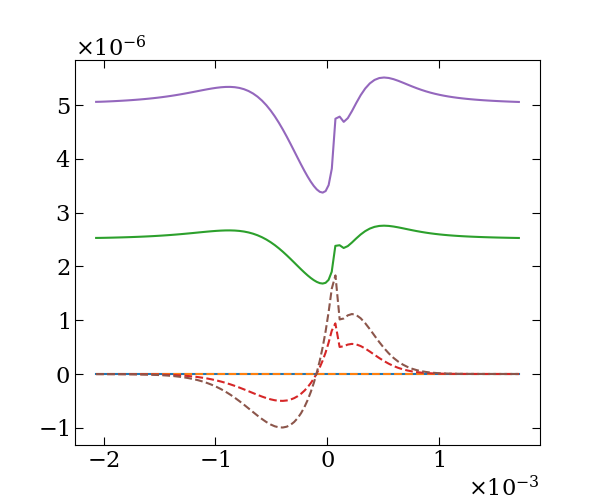

<IPython.core.display.Javascript object>


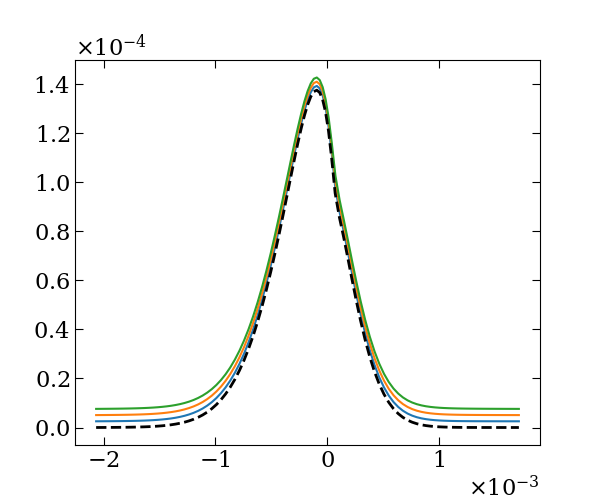

<IPython.core.display.Javascript object>


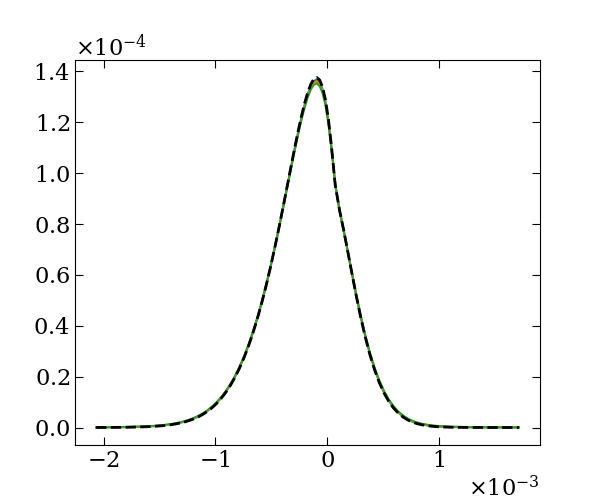

<IPython.core.display.Javascript object>


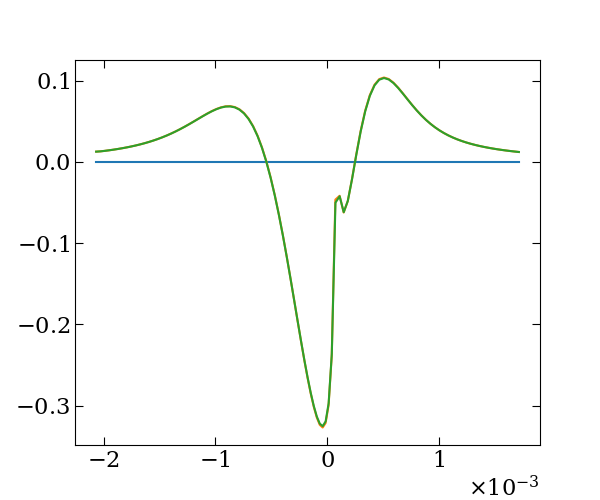

<IPython.core.display.Javascript object>


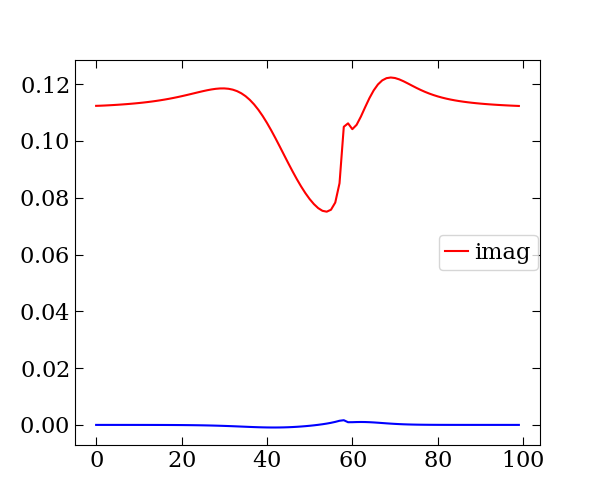

In [17]:
fig0=plt.figure()
ax0=fig0.gca()
fig1=plt.figure()
ax1=fig1.gca()
fig2=plt.figure()
ax2=fig2.gca()
fig3=plt.figure()
ax3=fig3.gca()
for i in range(3):
    integrator_epsilon=integrator_epsilons[i]
    delta_epsilon = integrator_epsilon-integrator_epsilons[0] 
    ax1.plot(cohDQss[i].real,cohDQss[i].imag,label=i)
    ax0.plot(cohDQss[i].real,cohDQss[i].imag-cohDQss[0].imag,label=i)
    ax0.plot(cohDQss[i].real,cohDQss[i].real-cohDQss[0].real,'--',label=i)
    ax2.plot(cohDQss[i].real,cohDQss[i].imag-integrator_epsilon,label=i)
    ax3.plot(cohDQss[i].real,((cohDQss[i].imag-cohDQss[0].imag)
                             -(delta_epsilon))/(delta_epsilon+1e-9),label=i)
    
dCohdTau = (cohDQss[2]-cohDQss[1])/(integrator_epsilons[2]-integrator_epsilons[1])
best = cohDQss[1] + dCohdTau*(-integrator_epsilons[1])
ax1.plot(best.real,best.imag,'--k',lw=2)
ax2.plot(best.real,best.imag,'--k',lw=2)

plt.figure()
plt.plot(dCohdTau.real  / np.std(best.real)*integrator_epsilons[1],'b',label='real')
plt.plot(dCohdTau.imag / np.std(best.imag)*integrator_epsilons[1],'r',label='imag')
plt.legend()




# Alpha

In [44]:
# Simple approximation
freeQs = get_tune_range(detuning,margin=2e-5, n_samples=nQ)
cohDQs = np.zeros((len(freeQs)), dtype='complex')
alpha  = np.zeros((len(freeQs)), dtype='complex')
for k, q in enumerate(freeQs):
    dQ2 = integrator.integrate(q+1j*integrator_epsilon)
    dQ1 = integrator.integrate(q)
    cohDQs[k] =  2*dQ1 - dQ2
    alpha[k]  = 1j* integrator_epsilon/ (dQ2-dQ1)

<IPython.core.display.Javascript object>


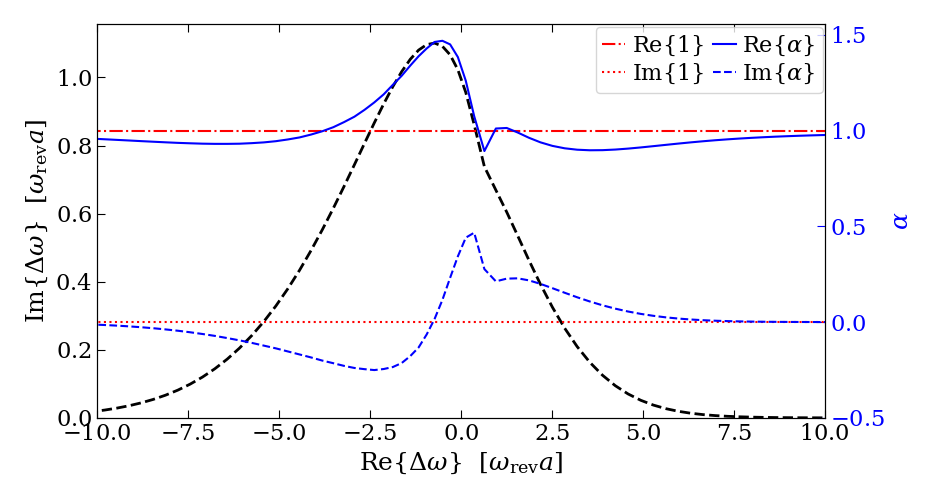

In [45]:
frev = 11.245e3
# bestomega = 2*np.pi*frev*best
bestomega = best
bestomega = cohDQs
# fig=plt.figure(figsize= (figwidth,figheight*.83))
fig=plt.figure(figsize= (figwidthM,figheight))
axl = fig.gca()
plt.plot(bestomega.real/abs(ax),bestomega.imag/abs(ax),'--k',lw=2)
axr = axl.twinx()

# alpha = 1j*(integrator_epsilons[1]-integrator_epsilons[0])/(cohDQss[1]-cohDQss[0])
alpha1 = 1+alpha*0
if 1:
    axr.plot(bestomega.real/abs(ax),alpha1.real,'r-.',label=r'$\mathrm{Re}\{1\}$')
    axr.plot(bestomega.real/abs(ax),alpha1.imag,'r:',label=r'$\mathrm{Im}\{1\}$')
    axr.plot(bestomega.real/abs(ax),alpha.real,'b',label=r'$\mathrm{Re}\{\alpha\}$')
    axr.plot(bestomega.real/abs(ax),alpha.imag,'b--',label=r'$\mathrm{Im}\{\alpha\}$')
#     axr.plot(bestomega.real,np.abs(alpha),'b:',label=r'$|\alpha|$')
#     plt.title(r'x-axis is $\mathrm{Re}\{\Delta Q_\mathrm{coh}\}$')
else:
    axr.plot(freeQs-Qx,alpha.real,'b',label=r'$\mathrm{Re}\{\alpha\}$')
    axr.plot(freeQs-Qx,alpha.imag,'b--',label=r'$\mathrm{Im}\{\alpha\}$')
#     axr.plot(freeQs-Qx,np.abs(alpha),'b:',label=r'$|\alpha|$')
    plt.title(r'x-axis is $Q_F$')
axr.tick_params('y', colors='b')
# axl.set_xlim(-1.2e-3,1.2e-3)
axl.set_xlabel(r'$\mathrm{Re}\{\Delta Q_\mathrm{coh}\}$')
axl.set_ylabel(r'$\mathrm{Im}\{\Delta Q_\mathrm{coh}\}$')
axl.set_xlabel(r'$\mathrm{Re}\{\Delta \omega\}$  $[ \omega_\mathrm{rev} a]$')
axl.set_ylabel(r'$\mathrm{Im}\{\Delta \omega\}$  $[ \omega_\mathrm{rev} a]$')

axr.set_ylabel(r'$\alpha$',color='b')
# axr.grid(True,color='b',lw=0.1,ls=':')
# axl.grid(True,color='b',axis='x',lw=0.1,ls=':')
# axl.plot([-1e-2,1e-2],[0,0],'k',lw=0.2,ls=':')
axl.set_ylim(bottom=0) ; axr.set_ylim(bottom=-0.5)
plt.xlim(-10,10)

axr.legend(loc=0,ncol=2,columnspacing=0.4)
fig.tight_layout()
fig.savefig(pltstorage+"TaylorBigOmega_alpha.pdf")
fig.savefig(pltstorage+"TaylorBigOmega_alpha.eps")

# Study: SD for different techniques

In [46]:

Qx = 0.31
a_thresh = 1e-4
ax = a_thresh * 1
bx = -.7*ax * 0

tol=1e-4

nQ = 85
nImQ = 15 # must be odd
integrator_epsilon=3e-6 *ax/1e-4 *[1,4][bx==0]

distribution = Gaussian()
detuning = LinearDetuning(Qx,ax,bx)
integrator1 = Integrator(distribution, detuning, maxJ=18,nStep=1000,epsilon=integrator_epsilon)
integrator2 = Integrator(distribution, detuning, maxJ=18,nStep=1000,epsilon=integrator_epsilon*2)
integrator4 = Integrator(distribution, detuning, maxJ=18,nStep=1000,epsilon=integrator_epsilon*4)


maxGR = ax*.5
freeGRs = np.linspace(-maxGR,maxGR,nImQ)
freeGRs_pos = np.linspace(0,maxGR,nImQ)
freeQs = get_tune_range(detuning,margin=ax*0.4, n_samples=nQ)
if bx==0:
    freeQs=np.linspace(freeQs[0]-1*ax,freeQs[nQ//2],nQ)

## DIspersion integral

In [47]:
cohDQsDI = np.zeros((nImQ,nQ), dtype='complex')

for i, GR in enumerate(freeGRs):
    for j, q in enumerate(freeQs):
        if GR == 0:
            cohDQsDI[i,j] = 2*integrator1.integrate(q) - integrator2.integrate(q)
        elif GR<0:
            cohDQsDI[i,j] = np.nan
        else:
            integrator1._detuning -= 1j*(GR-integrator_epsilon)
            cohDQsDI[i,j] = integrator1.integrate(q) 
            integrator1._detuning += 1j*(GR-integrator_epsilon)


    

## Taylor alpha

In [48]:
SD = np.zeros((nQ), dtype='complex')
alphas = np.zeros((nQ), dtype='complex')

for j, q in enumerate(freeQs):
    q1 = integrator1.integrate(q)
    q2 = integrator2.integrate(q)
#     q4 = integrator4.integrate(q)
    SD[j] = 2*q1 - q2
    
    # Calculate alpha 
    alphas[j]= 1j*integrator_epsilon/(q2-q1)
#     alphas[j]= 2j*integrator_epsilon/(q4-q2)
        
        

In [49]:
# Calculate ΔQ with alpha=1 or alpha!=1

cohDQs_a1 = np.zeros((nImQ,nQ), dtype='complex')
cohDQs_a  = np.zeros((nImQ,nQ), dtype='complex')

for i, GR in enumerate(freeGRs):
    for j, q in enumerate(freeQs):
        cohDQs_a[i,j]  = SD[j]+1j*GR/alphas[j]
        cohDQs_a1[i,j] = SD[j]+1j*GR

In [50]:
# Alphas with different angles



nangles = 11
angles = np.linspace(0,1,nangles)*np.pi
alphas_angles = np.zeros((nQ,nangles), dtype='complex')

for j, q in enumerate(freeQs):
    for i ,angle in enumerate(angles):
        eps = integrator_epsilon*np.exp(angles[i]*1j) * .5
#         print(i,angle,eps)

        integratoreps = Integrator(distribution, detuning, maxJ=18,nStep=1000,
                                   epsilon=integrator_epsilon+eps.imag)

    
        q1 = integrator1.integrate(q)    
        q2 = integratoreps.integrate(q+eps.real)
    
        # Calculate alpha 
        alphas_angles[j,i] = eps/(q2-q1)
#         print(i,j,eps/(q2-q1),eps)
    #     alphas[j]= 2j*integrator_epsilon/(q4-q2)

        

## Taylor extrapolation start
Where to extrapolate from

In [665]:
nQ_many=1+(nQ-1)*3
nQ_many = 500

SD_many = np.zeros((nQ_many), dtype='complex')
alphas_many = np.zeros((nQ_many), dtype='complex')
freeQs_many = np.linspace(freeQs[0]-2*ax,freeQs[-1]+ax,nQ_many)

for j, q in enumerate(freeQs_many):
    q1 = integrator1.integrate(q)
    q2 = integrator1.integrate(q+1j*integrator_epsilon)
    
    SD_many[j] = 2*q1 - q2
    alphas_many[j] = 1j*integrator_epsilon/(q2-q1)
    
QF_interp = interpolate.interp1d(SD_many.real,freeQs_many,kind='linear',fill_value = 'extrapolate')
SD_interp = interpolate.interp1d(SD_many.real,SD_many.imag,kind='linear',fill_value = 0,bounds_error=False)
alphasR_interp = interpolate.interp1d(SD_many.real,alphas_many.real,kind='linear',fill_value = 1,bounds_error=False)
alphasI_interp = interpolate.interp1d(SD_many.real,alphas_many.imag,kind='linear',fill_value = 0,bounds_error=False)

In [666]:
def find_minimum(func,point,xmin,xmax,tol=1e-4,nx=100,debug=False):
    #func : y(x)
    #point: x+1j*y
    err=1
    min_distance=1
    count=0
    while err>tol and count<50:
        x = np.linspace(xmin,xmax,nx)
        distance =  np.abs(x+1j*func(x)-point)
        ind = np.argmin(distance)
        
        err = ((min_distance-distance[ind])/min_distance)**2
        
        
        if debug:
            print(xmin,xmax,max(0,ind-1),min(nx-1,ind+1))
        xmin = x[max(0,ind-1)]
        xmax = x[min(nx-1,ind+1)]
#         print(count,err,min_distance)
        min_distance = distance[ind]
        count+=1
        
    return x[ind]
        

margin = 0.25*ax

# DI = np.zeros((nQ,2), dtype='complex')
# DQ_alpha_sameQ = np.zeros((nQ,2), dtype='complex')
# DQ_alpha1_sameQ = np.zeros((nQ,2), dtype='complex')
# DQ_alpha_closest = np.zeros((nQ,2), dtype='complex')
# DQ_alpha1_closest = np.zeros((nQ,2), dtype='complex')

cohDQ_DI = np.zeros((nImQ,nQ), dtype='complex')
ladDQ_DI  = np.zeros((nImQ,nQ), dtype='complex')

cohDQ_alpha_sameQ  = np.zeros((nImQ,nQ), dtype='complex')
cohDQ_alpha1_sameQ = np.zeros((nImQ,nQ), dtype='complex')
ladDQ_alpha_sameQ  = np.zeros((nImQ,nQ), dtype='complex')
ladDQ_alpha1_sameQ = np.zeros((nImQ,nQ), dtype='complex')

cohDQ_alpha_closest  = np.zeros((nImQ,nQ), dtype='complex')
cohDQ_alpha1_closest = np.zeros((nImQ,nQ), dtype='complex')
ladDQ_alpha_closest  = np.zeros((nImQ,nQ), dtype='complex')
ladDQ_alpha1_closest = np.zeros((nImQ,nQ), dtype='complex')



for i, GR in enumerate(freeGRs_pos):

    for j, q in enumerate(freeQs):
        if GR == 0:
            cohDQ_DI[i,j] = 2*integrator1.integrate(q) - integrator2.integrate(q)
        elif GR>0:
            cohDQ_DI[i,j] = integrator1.integrate(q + 1j*(GR-integrator_epsilon))
        
        ladDQ_DI[i,j] = q-Qx + 1j*(GR)

        for mode in range(2):
            if mode==0:
                ReQc = cohDQ_DI[i,j].real
            elif mode==1:
                debug  = (i==1 and j==0)
                ReQc = find_minimum(SD_interp,cohDQ_DI[i,j],xmin=freeQs_many[0]-Qx,xmax=freeQs_many[-1]-Qx,tol=1e-4,nx=1000,debug =debug)

            ReQf = QF_interp(ReQc)
            DQ_SD = ReQc + 1j*SD_interp(ReQc)
            M_LD = (ladDQ_DI[i,j] - (ReQf-Qx))
            M_c  = (cohDQ_DI[i,j] - (DQ_SD))     #.imag*1j
            alpha = alphasR_interp(ReQc)+1j*alphasI_interp(ReQc)

            if j==0 and i==1:
                
#             if j>nQ*0.3 and j<nQ*0.7: print(M_c,end=["","\n"][mode])
    #         if abs(j - nQ*0.45)<1 and i>=0:
                print('q',q,ReQf,np.min(np.abs(q-freeQs_many)))
                print('Qc',cohDQ_DI[i,j].real,ReQc,np.min(np.abs(ReQc - SD_many.real)))
                print(alpha)

            if mode==0:
                cohDQ_alpha_sameQ[i,j] = DQ_SD + M_LD/alpha
                ladDQ_alpha_sameQ[i,j] = ReQf-Qx + M_c*alpha
                cohDQ_alpha1_sameQ[i,j] = DQ_SD + M_LD
                ladDQ_alpha1_sameQ[i,j] = ReQf-Qx + M_c
            elif mode==1:
                cohDQ_alpha_closest[i,j] = DQ_SD + M_LD/alpha
                ladDQ_alpha_closest[i,j] = ReQf-Qx + M_c*alpha
                cohDQ_alpha1_closest[i,j] = DQ_SD + M_LD
                ladDQ_alpha1_closest[i,j] = ReQf-Qx + M_c
    
print('Done')

q 0.30986 0.3098598773260923 1.2825651302672547e-06
Qc -0.00029396772686112284 -0.00029396772686112284 1.315872164488847e-06
(0.8841471101275692-0.0129870077399214j)
-0.00033999999999995145 0.0010000000000000009 33 35
-0.0002957357357356888 -0.00029305305305300615 658 660
q 0.30986 0.30985987877933296 1.2825651302672547e-06
Qc -0.00029396772686112284 -0.0002939660781902555 1.3175208353562087e-06
(0.8841460788773571-0.012987208365907416j)
Done


<IPython.core.display.Javascript object>


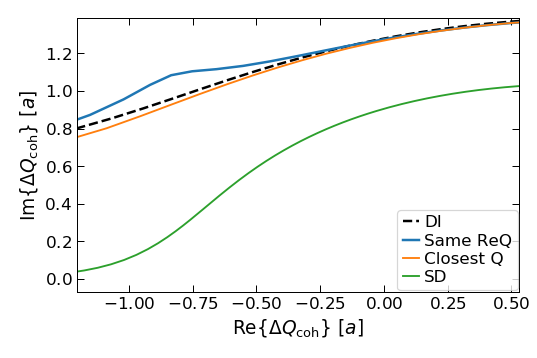

<IPython.core.display.Javascript object>


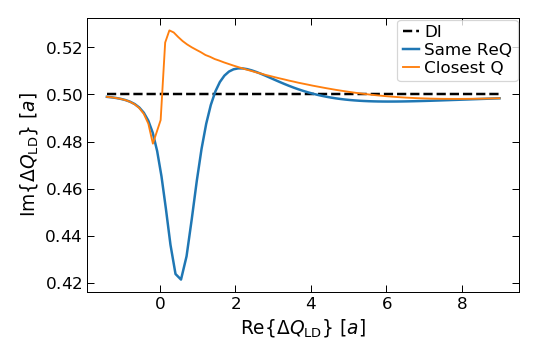

<IPython.core.display.Javascript object>


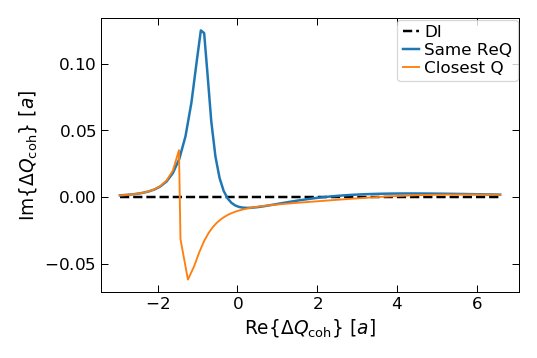

<IPython.core.display.Javascript object>


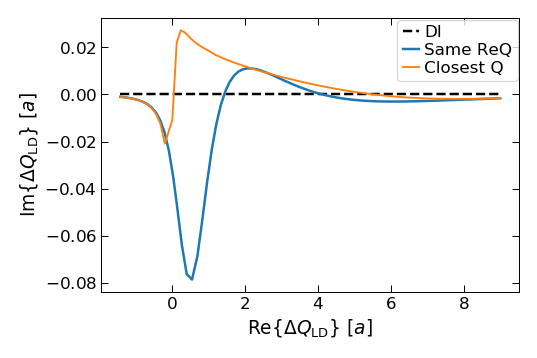

In [674]:
for i in range(2):
    for j in range(2):
        
        iGR = nImQ//2
        iGR=-1
        y1 = [cohDQ_DI[iGR,:],ladDQ_DI[iGR,:]][j]
        ysub = [0,y1][i]
        y2 = [cohDQ_alpha_sameQ[iGR,:],ladDQ_alpha_sameQ[iGR,:]][j]
        y3 = [cohDQ_alpha_closest[iGR,:],ladDQ_alpha_closest[iGR,:]][j]
        plt.figure()

        plt.plot(y1.real/ax,np.imag(y1-ysub)/ax,'k--',lw=2,label='DI')
        
#         plt.plot(DQ_alpha1_sameQ[:,j].real/ax,(DQ_alpha1_sameQ[:,j].imag-ysub)/ax,label=r'Same ReQ, $\alpha=1$')
#         plt.plot(DQ_alpha1_closest[:,j].real/ax,(DQ_alpha1_closest[:,j].imag-ysub)/ax,label=r'Closest Q, $\alpha=1$')
        
#         plt.plot(DQ_alpha_sameQ[:,j].real/ax,(DQ_alpha_sameQ[:,j].imag-ysub)/ax,label='Same ReQ')
#         plt.plot(DQ_alpha_closest[:,j].real/ax,(DQ_alpha_closest[:,j].imag-ysub)/ax,label='Closest Q')
        
        plt.plot(y2.real/ax,np.imag(y2-ysub)/ax,lw=2,label='Same ReQ')
        plt.plot(y3.real/ax,np.imag((y3-ysub))/ax,label='Closest Q')
        
        
        if i==0 and j==0: plt.plot(SD_many.real/ax,SD_many.imag/ax,label='SD')
        plt.legend(loc=0)
        
        plt.xlabel(r'$\mathrm{Re}\{\Delta Q_\mathrm{%s}\}$ $[a]$'%['coh','LD'][j])
        plt.ylabel(r'$\mathrm{Im}\{\Delta Q_\mathrm{%s}\}$ $[a]$'%['coh','LD'][j])
        plt.tight_layout()

## Plotting

### Calculating ΔQ

<IPython.core.display.Javascript object>


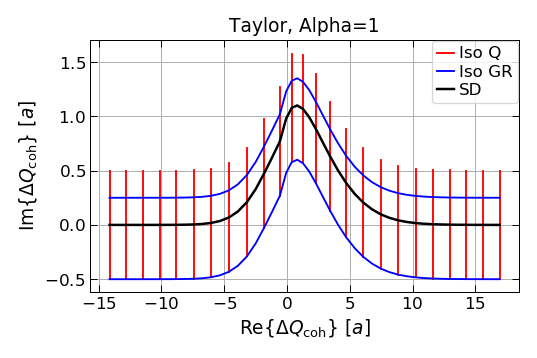

<IPython.core.display.Javascript object>


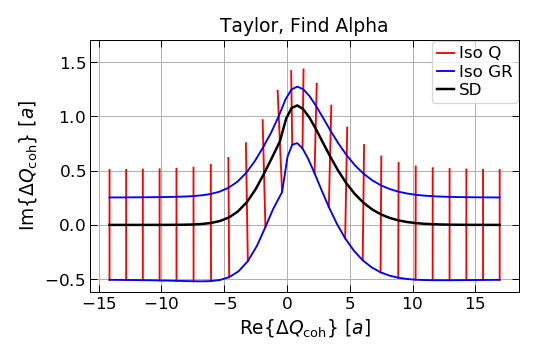

<IPython.core.display.Javascript object>


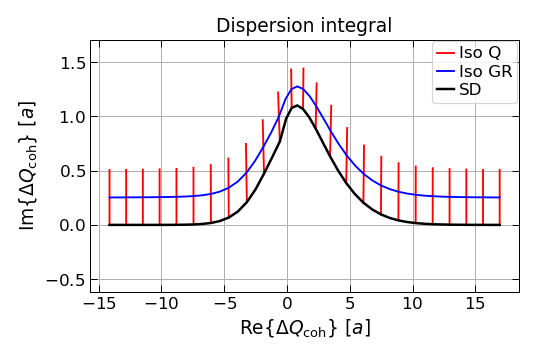

In [297]:
# miny = 0; maxy=0
for i in [2,1,0]:
    cohDQs = [cohDQsDI,cohDQs_a,cohDQs_a1][i] / ax
    
    sepQ=2
    sepGR=3
    
    plt.figure()#figsize = (5,3.))
    line1 = plt.plot(cohDQs[:,::sepQ].real,cohDQs[:,::sepQ].imag,'r')[0]
    line2=plt.plot(cohDQs[::sepGR].T.real,cohDQs[::sepGR].T.imag,'b')[0]
    line3=plt.plot(SD.real/ax,SD.imag/ax,'k',lw=2)[0]
    plt.legend([line1,line2,line3],['Iso Q','Iso GR','SD'])

    title = ['Dispersion integral','Taylor, Find Alpha','Taylor, Alpha=1'][i]
    plt.title(title)
    plt.grid(True)
    
    miny = min(miny,plt.ylim()[0])
    maxy = max(maxy,plt.ylim()[1])
    plt.ylim(miny,maxy)
    
    plt.xlabel(r'$\mathrm{Re}\{\Delta Q_\mathrm{coh}\}$ $[a]$')
    plt.ylabel(r'$\mathrm{Im}\{\Delta Q_\mathrm{coh}\}$ $[a]$')
    plt.tight_layout()

# plt.figure()
# plt.plot(cohDQs_a1.real,cohDQs_a1.imag,'r')
# plt.plot(cohDQs_a1.T.real,cohDQs_a1.T.imag,'b')
# plt.plot(SD.real,SD.imag,'k',lw=2)
# plt.title(')

### Error of Taylor approach

<IPython.core.display.Javascript object>


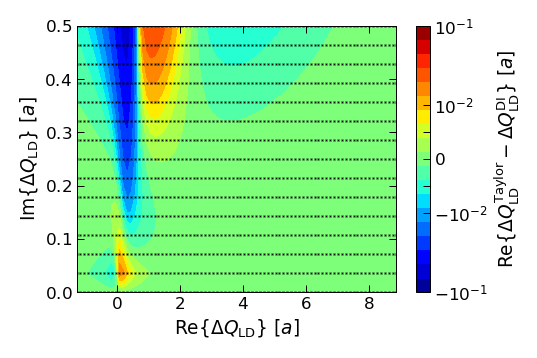

<IPython.core.display.Javascript object>


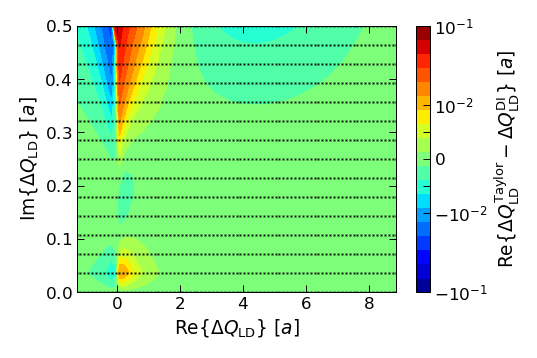

<IPython.core.display.Javascript object>


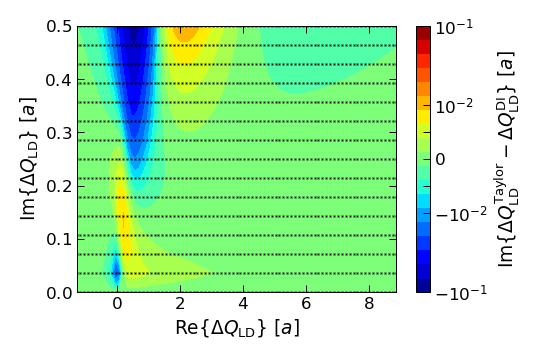

<IPython.core.display.Javascript object>


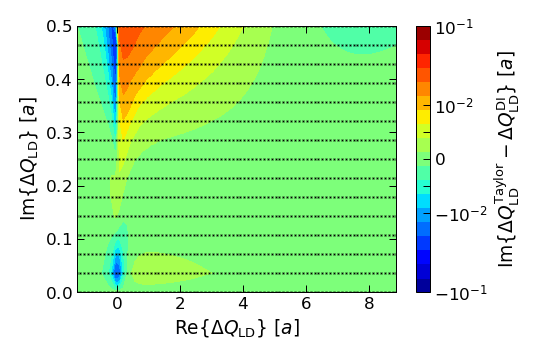

In [673]:
import matplotlib.colors as clrs
# Error of taylor approach. Compare same real freq and closest point

flag_errCohDQ = 0
for j in range(2):
    for i in range(2):
        if flag_errCohDQ:
            err = [cohDQ_alpha_sameQ,cohDQ_alpha_closest][i] - cohDQ_DI
        else:
            err = [ladDQ_alpha_sameQ,ladDQ_alpha_closest][i] - ladDQ_DI
        x=(freeQs -Qx)/ax
        y=freeGRs_pos/ax
        X,Y = np.meshgrid(x,y)

        #Set color scale
        nlevels=20
        vmax=.02#*a_thresh
        norm = clrs.Normalize(vmin = -vmax,vmax=vmax,clip=False)
        cticks=None
        if 1:
            vmax=0.1
            thresh = 1e-2
            nDec=1
            norm=clrs.SymLogNorm(vmax=thresh*10**nDec,vmin=-thresh*10**nDec,linthresh=thresh,linscale=nDec*1,
                                 clip=True)        
            posTicks = np.logspace(np.log10(thresh),np.log10(thresh)+nDec,1+nDec)
            cticks = np.concatenate((-posTicks,[-thresh/2,0,thresh/2],posTicks))
            
        levels=norm.inverse(np.linspace(0,1,nlevels))
        
    
        # Plot
        Z = [np.real(err),np.imag(err)][j]/ax
        plt.figure()
        plt.contourf(X,Y,Z,
                    levels=levels,norm=norm,)
#                  levels = np.linspace(-vmax,vmax,20),
#                  extent = (np.min(freeQs),np.max(freeQs),np.min(freeGRs[ind]),np.max(freeGRs)))
        plt.plot(X,Y,'kx',ms=0.5)
        plt.colorbar(ticks=cticks,#ticks = np.linspace(-vmax,vmax,5),
                     label= r'$\mathrm{%s}\{\Delta Q_\mathrm{%s}^\mathrm{Taylor}  - \Delta Q_\mathrm{%s}^\mathrm{DI}\}$ $[a]$'%(
                    ['Re','Im'][j],['coh','LD'][not flag_errCohDQ],['coh','LD'][not flag_errCohDQ]))
        plt.xlabel(r'$\mathrm{Re}\{\Delta Q_\mathrm{LD}\}$ $[a]$')
        plt.ylabel(r'$\mathrm{Im}\{\Delta Q_\mathrm{LD}\}$ $[a]$')
        
        plt.xlim(x[1],x[-2])
        plt.tight_layout()

In [607]:
# Error of taylor approach

for i in range(2):
    ind = freeGRs>=0
    err = [cohDQs_a,cohDQs_a1][i] - cohDQsDI
    err = err[ind,:]
    x=(freeQs -Qx)/ax
    y=freeGRs[ind]/ax
    X,Y = np.meshgrid(x,y)
    
    vmax=.2#*a_thresh
    for j in range(2):
        Z = [np.real(err),np.imag(err)][j]/ax
        plt.figure()
        plt.contourf(X,Y,Z,levels = np.linspace(-vmax,vmax,20),)
#                  extent = (np.min(freeQs),np.max(freeQs),np.min(freeGRs[ind]),np.max(freeGRs)))
        plt.plot(X,Y,'kx',ms=0.5)
        plt.colorbar(ticks = np.linspace(-vmax,vmax,5),
                     label= r'err($\mathrm{%s}\{\Delta Q_\mathrm{coh}\}$) $[a]$'%['Re','Im'][j])
        plt.xlabel(r'$\mathrm{Re}\{\Delta Q_\mathrm{LD}\}$ $[a]$')
        plt.ylabel(r'$\mathrm{Im}\{\Delta Q_\mathrm{LD}\}$ $[a]$')
        plt.tight_layout()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5 but corresponding boolean dimension is 15

### Alpha 

<IPython.core.display.Javascript object>


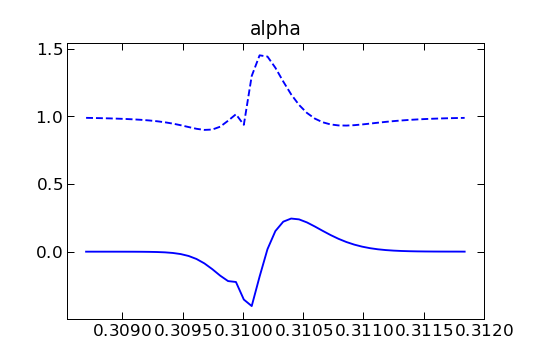

Text(0.5, 1.0, 'alpha')

In [299]:
plt.figure()
plt.plot(freeQs,alphas.real,'b--')
plt.plot(freeQs,alphas.imag,'b-')
plt.title('alpha')

<IPython.core.display.Javascript object>


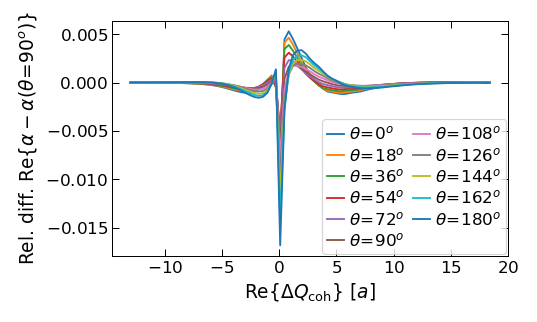

<IPython.core.display.Javascript object>


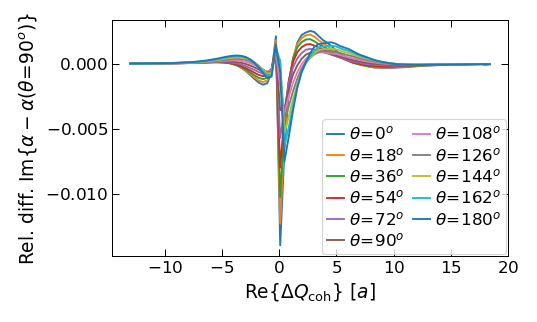

In [338]:
fig1=plt.figure(figsize=(figwidth,figheight*.9))
ax1 = fig1.gca()
fig2=plt.figure(figsize=(figwidth,figheight*.9))
ax2 = fig2.gca()

for i,angle in enumerate(angles):
    label = r'$\theta\!=\!%.0d^o$'%(angle*180/np.pi)
    y= (alphas_angles[:,i]-alphas)/np.abs(alphas)
#     y = alphas_angles[:,i]
    ax1.plot((freeQs-Qx)/ax,y.real,label=label)
    ax2.plot((freeQs-Qx)/ax,y.imag,label=label)
    
for i in range(2):
    axi = [ax1,ax2][i]
    figi =[fig1,fig2][i]
    
    axi.legend(loc=1+1*3,ncol=2,columnspacing=.5)
    axi.set_xlabel(r'$\mathrm{Re}\{\Delta Q_\mathrm{coh}\}$ $[a]$')
    axi.set_ylabel(r'Rel. diff. $\mathrm{%s}\{\alpha- \alpha(\theta\!=\!90^o)\}$'%['Re','Im'][i])
#     axi.set_ylabel(r'$\mathrm{%s}\{\alpha\}$'%['Re','Im'][i])
    figi.tight_layout()

# Finding a_thresh

(-0.001467+0.000125j) (-0.018434865691264905+0.0015707963267948967j)


<IPython.core.display.Javascript object>


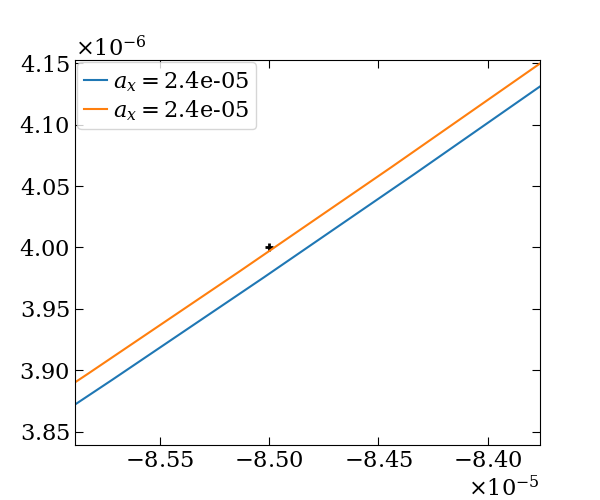

ax,bx 2.3915256455536895e-05 -1.6888608940250283e-05
ax,bx 2.3946e-05 -1.6910319587628868e-05


In [82]:
from scipy import constants as const
# Impact of integrator_epsilon
#mode 0
wjBB = -2.737e-4 +3.60452e-5j
wjCO = -2.20e-04+ 1j*3.59e-05
axs = [9.64e-5,10e-5,11e-5]

# mode 1
wjBB = -8.42630653e-05+4.26645271e-06j
wjCO = 8.67e-6  + 3.5e-6j
axs = [.4e-5,2e-5,2.4e-5]

#ws2
wjBB = -1.70118759e-04+7.71589202e-06j
wjCO = 1.13e-4 + 6.1358e-6j
axs = [5e-5,2e-5,2.4e-5]

#gwake 1
wjBB = wjCO = (-2.934e-4+2.5e-5j)*5
wjCO = 5.002e-4j
print(wjBB,wjBB*4*np.pi)
axs = [5e-4,1e-4]


# #gwake 2
# wjBB = wjCO = (0+1e-3j)/(4*np.pi)
# print(wjBB*4*np.pi)
# axs = [.88e-4]

# #gwake 2
# wjBB = wjCO = (1+1j)*6.5e-3/(4*np.pi)
# wjBB = wjCO = (2+1j)*5.83e-3/(4*np.pi)
# wjBB = wjCO = (3+1j)*5.095e-3/(4*np.pi)
# print(wjBB*4*np.pi)
# axs = [5e-4]

#test
# wjBB = wjCO = (30+3j)*1e-5
# axs = [1e-4]

# wmode__DQ = [wj]
# wmodeDipm = [1,]
# wmodeLDDQ = [0]

# LHC MD3288
energy = 6500*1000
gamma = energy/const.value("proton mass energy equivalent in MeV")
beta = np.sqrt(1-1/gamma**2)
if 0:


    bunchnr = 7
    intensity = [0.880,0.934,0.922,0.909,0.944,0.881,0.916,0.8854,0.8484,0.877502][bunchnr]
    #     emittnormx = 1e-6 * [1.5,1.04,0.98,0.81,0.89,0.88,0.93][bunchnr]
    #     emittnormy = 1e-6 * [1.61,1.46,1.45,1.31,1.52,1.50,1.50][bunchnr]
    emittnormx = 1e-6 * [1.407,1.067,1.122,0.9849,0.893,0.875501,0.933,0.821,1.915,1.064][bunchnr]
    emittnormy = 1e-6 * [1.619,1.446,1.457,1.341,1.518,1.5049,1.498,1.451,2.019,1.390][bunchnr]
    bunchlength= [1.09376,1.0963,1.0964,1.09847,1.09852,1.088,1.0754,1.0856,1.063651,1.06668][bunchnr]
    Anoise = [ 2.96708, 2.555353 ,1.66174 ,0.88664 ,3.72467 ,2.82126 ,1.82210, 0.97099,0,0][bunchnr] * 3.9e-4
    Iocts = [452,452,452,452,546,546,546,546,205,240][bunchnr]

    sigma_dpp = 1.065380e-04 * bunchlength/1.1
    #dQ_coh = (-8.4812e-05+4.0726e-06j)*intensity/1 #B1
    dQ_coh = (-9.8321e-05 + 4.1424e-06j) *intensity/1 # B2
    dQ_coh = np.array([[-1.00172e-04+3.75160e-06j, -1.00139e-04+3.89150e-06j, -1.00103e-04+4.01580e-06j],
           [-9.92473e-05+4.00052e-06j, -9.91820e-05+4.10895e-06j, -9.91175e-05+4.20362e-06j],
           [-9.84156e-05+4.06961e-06j, -9.83209e-05+4.14239e-06j, -9.82315e-05+4.20375e-06j],
           [-9.76862e-05+3.92696e-06j, -9.75654e-05+3.95816e-06j, -9.74539e-05+3.98089e-06j],
           [-9.70587e-05+3.53382e-06j, -9.69139e-05+3.51486e-06j, -9.67823e-05+3.49105e-06j]])*intensity/1
    # dQ_coh = (-84.088+4.293j)*1e-6*intensity/1
    emittgeox = emittnormx/(beta*gamma)
    emittgeoy = emittnormy/(beta*gamma)

    ax = 520*Iocts*emittgeox
    bx =-364*Iocts*emittgeoy

    # B1: 531.3/-383.4 
    ax = 531.3*Iocts*emittgeox
    bx =-383.4*Iocts*emittgeoy


    wjCO = dQ_coh
    fac = bx/ax
    axs = [ax * [191.5,233,227,245, 230.3,217,225,227,  146,227][bunchnr] /Iocts ]  ; 

    if 0:
        axs = [ax]
        wjCO *= [1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.497,1.127][bunchnr]
    print(ax/axs)
    
# test case
emittnormx = 2e-6
emittnormy = 2e-6
emittgeox = emittnormx/(beta*gamma)
emittgeoy = emittnormy/(beta*gamma)
Ioct = 152.5
beam_number = [1,2][0]
ax = [543.2,531.3][beam_number-1]*Ioct*emittgeox
bx =-[383.6,383.4][beam_number-1]*Ioct*emittgeoy
fac = bx/ax
axs = [ax,2.3946e-05]
wjCO = dQ_coh = -8.5e-5 + 4e-6j*1.

Qx = 0.31
distribution = Gaussian()
nQ=20

plt.figure()
# plt.plot(wjBB.real,wjBB.imag,'kx')
plt.plot(wjCO.real,wjCO.imag,'k+')

for i in range(len(axs)):
    ax = axs[i]
#     bx = -.7*ax *1
    bx =fac*ax  # LHC MD b1
    print('ax,bx',ax,bx)
#     bx = -1.1955*ax
    integrator_epsilon=1e-6 *ax/1e-4 * 2

    detuning = LinearDetuning(Qx,ax,bx)
    integrator1 = Integrator(distribution, detuning, maxJ=18,epsilon=integrator_epsilon)
    integrator2 = Integrator(distribution, detuning, maxJ=18,epsilon=integrator_epsilon*2)
    
    freeQs = get_tune_range(detuning,margin=2e-5, n_samples=nQ)
    freeQs = Qx+ ax*np.linspace(-.5,-0,nQ)-ax*2.5
#     freeQs = Qx+ ax*np.linspace(4.7,4.9,nQ)
    cohDQs = np.zeros((len(freeQs)), dtype='complex')
    for k, q in enumerate(freeQs):
        cohDQs[k] = 2*integrator1.integrate(q)-integrator2.integrate(q)
        
    plt.plot(cohDQs.real,cohDQs.imag,label=r'$a_x=$%.1e'%ax)
    
plt.legend(loc=0)



In [77]:
ax,dQ_ld,alpha,cnt = L2D2.find_axThreshold(dQ_coh,Qx,fac,JMaxSD=18,
                                method=2,tol_search=1e-5,
                                tol=tol_dQ_ld,flagFindalpha=[1,1],debug=1)

print("After %-2d steps: ax = %.4e  giving dQ_ld=%.2e %s%.3ej "%(cnt,ax,dQ_ld.real,['+','-'][np.sign(dQ_ld.imag)<0],abs(dQ_ld.imag)) )


step 0 : dQ_ld = -4.13e-05 -5.360e-05j with ax=8.51e-05 in [0.00e+00,inf] - err=-1.3e+01
step 1 : dQ_ld = -6.26e-05 -1.406e-05j with ax=4.25e-05 in [0.00e+00,8.51e-05] - err=-3.5e+00
step 2 : dQ_ld = -6.94e-05 +1.105e-06j with ax=2.13e-05 in [0.00e+00,4.25e-05] - err=2.8e-01
step 3 : dQ_ld = -6.89e-05 +3.571e-07j with ax=2.28e-05 in [2.13e-05,4.25e-05] - err=8.9e-02
step 4 : dQ_ld = -6.87e-05 +2.075e-07j with ax=2.33e-05 in [2.28e-05,4.25e-05] - err=5.2e-02
step 5 : dQ_ld = -6.87e-05 +1.891e-07j with ax=2.36e-05 in [2.33e-05,4.25e-05] - err=4.7e-02
step 6 : dQ_ld = -6.86e-05 +5.541e-08j with ax=2.38e-05 in [2.36e-05,4.25e-05] - err=1.4e-02
step 7 : dQ_ld = -6.86e-05 +1.600e-08j with ax=2.39e-05 in [2.38e-05,4.25e-05] - err=4.0e-03
step 8 : dQ_ld = -6.86e-05 +4.603e-09j with ax=2.39e-05 in [2.39e-05,4.25e-05] - err=1.2e-03
step 9 : dQ_ld = -6.86e-05 +1.322e-09j with ax=2.39e-05 in [2.39e-05,4.25e-05] - err=3.3e-04
step 10: dQ_ld = -6.86e-05 +3.798e-10j with ax=2.39e-05 in [2.39e-05,4.25

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  """


In [7]:
# Impact of integrator_epsilon
#mode 0

# mode 1
wjs = [-8.42630653e-05+4.26645271e-06j, -6.45560213e-05+1.44627487e-06j,-4.02684229e-05+2.20672406e-06j]
axs = [2.42e-5,2.43e-5,1.2e-5]


# wmode__DQ = [wj]
# wmodeDipm = [1,]
# wmodeLDDQ = [0]

Qx = 0.31
distribution = Gaussian()
nQ=20

plt.figure()
for i,wj in enumerate(wjs):
    plt.plot(wj.real,wj.imag,'x',label=i)


for i in range(2):
    ax = axs[i]
    bx = -.7*ax
    integrator_epsilon=1e-6 *ax/1e-4 * 2

    detuning = LinearDetuning(Qx,ax,bx)
    integrator = TrapzIntegrator(distribution, detuning, maxJ=18,n_steps=1000)

    freeQs = get_tune_range(detuning,margin=2e-5, n_samples=nQ)
    freeQs = Qx+ ax*np.linspace(-4,-2,nQ)
    cohDQs = np.zeros((len(freeQs)), dtype='complex')
    for k, q in enumerate(freeQs):
        cohDQs[k] = integrator.integrate(q,epsilon=integrator_epsilon) - 1j*integrator_epsilon
        
    plt.plot(cohDQs.real,cohDQs.imag,label=r'$a_x=$%.3e'%ax)
    
plt.legend(loc=0)

<IPython.core.display.Javascript object>

NameError: name 'TrapzIntegrator' is not defined

# Finding I_thresh

In [3]:
    
dQ_coh = -1e-3+1e-4j*1
JMaxSD = 18
Qx = 0.31
wmodeQ0x = Qx
flagFindalpha=[1,1]
tol_dQ_ld=1e-4
wmodeDipm= 1
sigma_k = 1e-4

tol_search = 1e-3
bafac = -0.7
distribution = Gaussian()

ax,dQ_ld,alpha,cnt = L2D2.find_axThreshold(dQ_coh,Qx,bafac,JMaxSD=JMaxSD,
                                method=2,tol_search=tol_search,
                                tol=tol_dQ_ld,flagFindalpha=flagFindalpha,debug=1)

print("After %-2d steps: ax = %.4e  giving dQ_ld=%.2e %s%.3ej "%(cnt,ax,dQ_ld.real,['+','-'][np.sign(dQ_ld.imag)<0],abs(dQ_ld.imag)) )




step 0 : dQ_ld = -4.70e-04 -5.735e-04j with ax=1.00e-03 in [0.00e+00,inf] - err=-5.7e+00
step 1 : dQ_ld = -7.22e-04 -1.136e-04j with ax=5.02e-04 in [0.00e+00,1.00e-03] - err=-1.1e+00
step 2 : dQ_ld = -8.09e-04 +6.129e-05j with ax=2.51e-04 in [0.00e+00,5.02e-04] - err=6.1e-01
step 3 : dQ_ld = -7.79e-04 +1.099e-05j with ax=3.39e-04 in [2.51e-04,5.02e-04] - err=1.1e-01
step 4 : dQ_ld = -7.75e-04 +3.192e-06j with ax=3.54e-04 in [3.39e-04,5.02e-04] - err=3.2e-02
step 5 : dQ_ld = -7.73e-04 +1.912e-06j with ax=3.58e-04 in [3.54e-04,5.02e-04] - err=1.9e-02
step 6 : dQ_ld = -7.72e-04 +2.474e-07j with ax=3.60e-04 in [3.58e-04,5.02e-04] - err=2.5e-03
step 7 : dQ_ld = -7.72e-04 +3.173e-08j with ax=3.60e-04 in [3.60e-04,5.02e-04] - err=3.2e-04
After 8  steps: ax = 3.6048e-04  giving dQ_ld=-7.72e-04 +3.173e-08j 


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:19: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


In [6]:
ax,dQ_ld,alpha,Lquad,cnt = L2D2.find_axLatency(dQ_coh,Qx,bafac=bafac,distribution=Gaussian(),JMaxSD=JMaxSD,
#                                     eta=eta,sigma_k=sigma_k,Trev= 1/11245.5,
                                    method=1,tol_search=tol_search*1e-10,goal=0,
                                    tol=tol_dQ_ld,flagFindalpha=flagFindalpha,
                                    debug=1)
print("After %-2d steps: ax = %.4e  giving dQ_ld=%.2e %s%.3ej "%(cnt,ax,dQ_ld.real,['+','-'][np.sign(dQ_ld.imag)<0],abs(dQ_ld.imag)) )

step 0 : Latency=4.6506e+02!=0.0000e+00 with ax=1.00e-03 in [0.00e+00,inf] - err=5.2e+00
step 1 : Latency=1.6993e+00!=0.0000e+00 with ax=5.02e-04 in [0.00e+00,1.00e-03] - err=1.9e-02
step 2 : Latency=-1.2304e+00!=0.0000e+00 with ax=2.51e-04 in [0.00e+00,5.02e-04] - err=-1.4e-02
step 3 : Latency=6.4813e-05!=0.0000e+00 with ax=3.77e-04 in [2.51e-04,5.02e-04] - err=7.3e-07
step 4 : Latency=-8.4082e-03!=0.0000e+00 with ax=3.14e-04 in [2.51e-04,3.77e-04] - err=-9.5e-05
step 5 : Latency=-5.7050e-06!=0.0000e+00 with ax=3.45e-04 in [3.14e-04,3.77e-04] - err=-6.4e-08
step 6 : Latency=6.6236e-12!=0.0000e+00 with ax=3.61e-04 in [3.45e-04,3.77e-04] - err=7.4e-14
After 7  steps: ax = 3.6117e-04  giving dQ_ld=-7.72e-04 -4.501e-07j 


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


# Find ax giving given latency

In [132]:

dQ_coh = -1e-3+1e-4j*1
JMaxSD = 18
Qx = 0.31
wmodeQ0x = Qx
flagFindalpha=[1,1]
tol_dQ_ld=1e-4
eta = 1e-2
sigma_k = 1e-4
goal = 100 #latency in seconds
tol_search = 1e-3

bafac = -0.7
debug=1
method=1
bafac = -0.7
# axt,dQ_ld,cnt = find_axThreshold(dQ_coh,Qx,bafac,JMaxSD=JMaxSD,
#                                 method=2,tol_search=tol_search,debug=0)
# axt


ax,dQ_ld,alpha,Lquad,cnt = L2D2.find_axLatency(dQ_coh,Qx,bafac=bafac,distribution=Gaussian(),JMaxSD=JMaxSD,
                                    eta=eta,sigma_k=sigma_k,Trev= 1/11245.5,
                                    method=method,tol_search=tol_search,goal=goal,
                                    tol=tol_dQ_ld,flagFindalpha=flagFindalpha,
                                    debug=debug)

print("After %-2d steps: ax = %.4e  giving Latency=%.4e, dQ_ld=%.2e %s%.3ej (err=%.1e)"%(
        cnt,ax,Lquad,dQ_ld.real,['+','-'][np.sign(dQ_ld.imag)<0],abs(dQ_ld.imag) ,(Lquad-goal)/goal))

step 0 : Latency=4.6506e+06!=1.0000e+02 with ax=1.00e-03 in [0.00e+00,inf] - err=4.7e+04
step 1 : Latency=1.6993e+04!=1.0000e+02 with ax=5.02e-04 in [0.00e+00,1.00e-03] - err=1.7e+02
step 2 : Latency=-1.2304e+04!=1.0000e+02 with ax=2.51e-04 in [0.00e+00,5.02e-04] - err=-1.2e+02
step 3 : Latency=6.4813e-01!=1.0000e+02 with ax=3.77e-04 in [2.51e-04,5.02e-04] - err=-9.9e-01
step 4 : Latency=1.2241e+03!=1.0000e+02 with ax=4.40e-04 in [3.77e-04,5.02e-04] - err=1.1e+01
step 5 : Latency=1.1413e+02!=1.0000e+02 with ax=4.08e-04 in [3.77e-04,4.40e-04] - err=1.4e-01
step 6 : Latency=1.6934e+01!=1.0000e+02 with ax=3.93e-04 in [3.77e-04,4.08e-04] - err=-8.3e-01
step 7 : Latency=4.8474e+01!=1.0000e+02 with ax=4.00e-04 in [3.93e-04,4.08e-04] - err=-5.2e-01
step 8 : Latency=7.5878e+01!=1.0000e+02 with ax=4.04e-04 in [4.00e-04,4.08e-04] - err=-2.4e-01
step 9 : Latency=9.3482e+01!=1.0000e+02 with ax=4.06e-04 in [4.04e-04,4.08e-04] - err=-6.5e-02
step 10: Latency=1.0340e+02!=1.0000e+02 with ax=4.07e-04 i

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:29: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


In [68]:

# ratios = np.linspace(0,1,10)
# ratios[0]=ratios[1]/10
# dQ_cohs = (-1 + ratios*1j)*1e-4

ratios = np.arange(0,101,10).astype(np.float64)
ratios[0]=1
dQ_cohs = (-1+1j/ratios)*1e-4
Nr = np.size(ratios)

margins = [1.1,1.4,1.7,2]
margins = [1.5]
Nm= np.size(margins)

axmargins = np.zeros((Nm,Nr))
Lats = np.zeros((Nm,Nr))
dQmargins= np.zeros((Nm,Nr))

for j,margin in enumerate(margins):
    dQ_coh1 = (-1+.1j)*1e-4
    #Find threshold
    axt,dQ_ld,alpha,cnt = L2D2.find_axThreshold(dQ_coh1,Qx,bafac,JMaxSD=JMaxSD,
                                    method=2,tol_search=tol_search,
                                    tol=tol_dQ_ld,flagFindalpha=flagFindalpha,debug=0)
    # Find damping with a margin
    ax= axt*margin
    bx= bafac*ax
    integrator_epsilon = 1e-6 * ax/1e-4 *[1,4][bx==0]
    detuning = LinearDetuning(Qx,ax,bx)
    distribution=Gaussian()
    dQ_ld , cnt, alpha, relerr, dQ_free, dQ_sd = L2D2.calc_CapitalOmega(
        distribution,detuning,integrator_epsilon,
        Qx,modeDQ=dQ_coh1,tol=tol_dQ_ld,flagFindalpha=flagFindalpha,debug=0,JMaxSD=JMaxSD)
    # Find Latency with a margin
    _,Lgoal = L2D2.latency_ana(dQ_coh1,eta,dQ_ld,alpha,ax,bx,sigma_k,Trev = 1/11245.5)
    print('Latency goal is %.2e with ax=%.2e>%.2e'%(Lgoal,1.5*axt,axt))

    for i,dQ_coh in enumerate(dQ_cohs):

        axt,dQ_ldt,alphat,cnt = L2D2.find_axThreshold(dQ_coh,Qx,bafac,JMaxSD=JMaxSD,
                                    method=2,tol_search=tol_search,
                                    tol=tol,flagFindalpha=flagFindalpha,debug=0)
        print("After %-2d steps: ax = %.4e  giving dQ_ld=%.2e %s%.3ej "%(
                cnt,axt,dQ_ldt.real,['+','-'][np.sign(dQ_ldt.imag)<0],abs(dQ_ldt.imag)) )



        ax,dQ_ld,alpha,Lquad,cnt = L2D2.find_axLatency(dQ_coh,Qx,bafac=bafac,distribution=Gaussian(),JMaxSD=JMaxSD,
                                        eta=eta,sigma_k=sigma_k,Trev= 1/11245.5,
                                        method=method,tol_search=tol_search,goal=Lgoal,
                                        tol=tol,flagFindalpha=flagFindalpha,
                                        debug=0)

        print("After %-2d steps: ax = %.4e  giving Latency=%.4e, dQ_ld=%.2e %s%.3ej (err=%.1e)"%(
                cnt,ax,Lquad,dQ_ld.real,['+','-'][np.sign(dQ_ld.imag)<0],abs(dQ_ld.imag) ,(Lquad-goal)/goal))

        print(j,i,ax/axt)
        axmargins[j,i]=ax/axt
        dQmargins[j,i]=-(dQ_ld.imag/alpha.real)/dQ_coh.imag
        Lats[j,i]=Lquad

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:28: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Found alpha!=1, alpha=9.64e-01 -2.19e-01j |  dampDQ = -6.73e-05 -1.532e-05j -> -7.06e-05 -1.477e-05j
Latency goal is 4.74e+04 with ax=5.41e-05>3.60e-05


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:44: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


After 4  steps: ax = 1.3899e-04  giving dQ_ld=-8.83e-06 -8.142e-09j 


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


After 15 steps: ax = 1.8287e-04  giving Latency=4.7404e+04, dQ_ld=3.02e-06 -3.914e-05j (err=4.7e+02)
0 0 1.315732485050021
After 8  steps: ax = 3.6048e-05  giving dQ_ld=-7.72e-05 +3.173e-09j 
After 15 steps: ax = 5.4071e-05  giving Latency=4.7360e+04, dQ_ld=-7.06e-05 -1.477e-05j (err=4.7e+02)
0 1 1.4999787699833074
After 9  steps: ax = 2.8852e-05  giving dQ_ld=-8.02e-05 +4.700e-09j 
After 11 steps: ax = 4.6640e-05  giving Latency=4.7331e+04, dQ_ld=-7.45e-05 -1.295e-05j (err=4.7e+02)
0 2 1.616548122550895
After 9  steps: ax = 2.5902e-05  giving dQ_ld=-8.13e-05 +1.845e-09j 
After 13 steps: ax = 4.3994e-05  giving Latency=4.7367e+04, dQ_ld=-7.58e-05 -1.226e-05j (err=4.7e+02)
0 3 1.6984540489086473
After 7  steps: ax = 2.4175e-05  giving dQ_ld=-8.19e-05 +2.359e-09j 
After 13 steps: ax = 4.2616e-05  giving Latency=4.7389e+04, dQ_ld=-7.64e-05 -1.190e-05j (err=4.7e+02)
0 4 1.7628118672526591
After 8  steps: ax = 2.3003e-05  giving dQ_ld=-8.23e-05 +1.634e-09j 
After 15 steps: ax = 4.1763e-05  

<IPython.core.display.Javascript object>


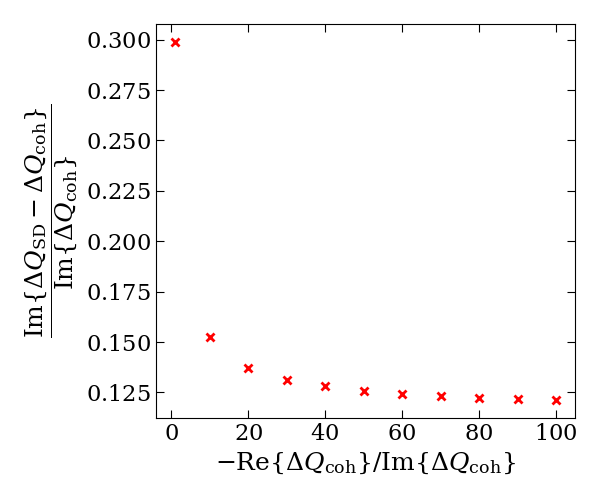

<IPython.core.display.Javascript object>


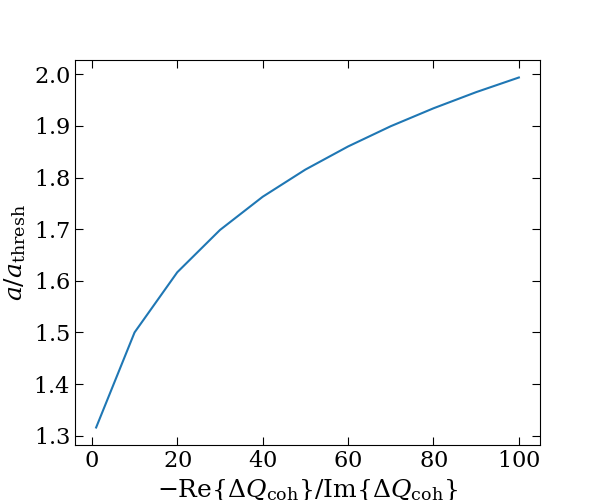

Text(0, 0.5, '$a/a_\\mathrm{thresh}$')

In [73]:
plt.figure()
for i in range(Nm):
    y = dQmargins[i]*dQ_cohs.imag
    y = (dQmargins[i]*dQ_cohs.imag)/np.abs(dQ_cohs)
    plt.plot(ratios,y,'rx',label='L=%.*f min'%(i==0,np.mean(Lats[i])/60))
plt.xlabel(r'$-\mathrm{Re}\{\Delta Q_\mathrm{coh}\}/\mathrm{Im}\{\Delta Q_\mathrm{coh}\}$')
plt.ylabel(r'$\dfrac{\mathrm{Im}\{\Delta Q_\mathrm{SD}-\Delta Q_\mathrm{coh}\}}{\mathrm{Im}\{\Delta Q_\mathrm{coh}\}}$') #Isolatency')
plt.tight_layout()

plt.figure()
for i in range(Nm):
    plt.plot(ratios,axmargins[i],label='L=%.*f min'%(i==0,np.mean(Lats[i])/60))
plt.xlabel(r'$-\mathrm{Re}\{\Delta Q_\mathrm{coh}\}/\mathrm{Im}\{\Delta Q_\mathrm{coh}\}$')
plt.ylabel(r'$a/a_\mathrm{thresh}$') #Isolatency')

<IPython.core.display.Javascript object>


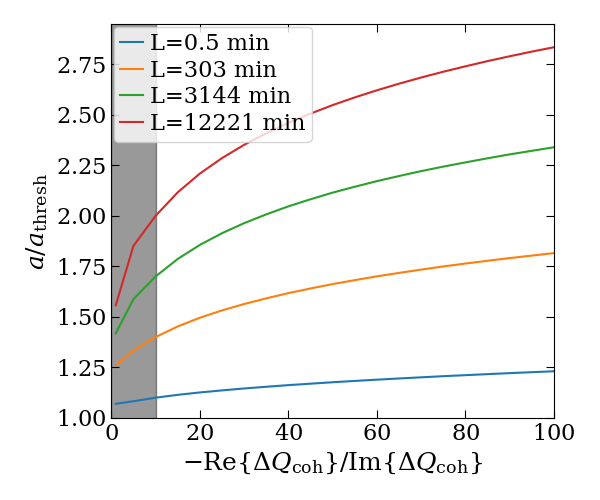

In [58]:
plt.figure()
for i in range(Nm):
    plt.plot(ratios,axmargins[i],label='L=%.*f min'%(i==0,np.mean(Lats[i])/60))
plt.xlabel(r'$-\mathrm{Re}\{\Delta Q_\mathrm{coh}\}/\mathrm{Im}\{\Delta Q_\mathrm{coh}\}$')
plt.ylabel(r'$a/a_\mathrm{thresh}$') #Isolatency')
plt.fill_between([0,10],[1e4,1e4],color='k',alpha=.4)
plt.xlim(0,np.max(ratios))
plt.ylim(1,np.max(axmargins*1.04))
plt.legend(loc=0)
plt.tight_layout()
plt.savefig('01_Plots/isolatencycurves.pdf')

# Latency with given margin

In [136]:
# HL-LHC
energy = 7000*1000
emittnormx = 1.7e-6
Ioct = 550

emittnormy = emittnormx
gamma = energy/const.value("proton mass energy equivalent in MeV")
beta = np.sqrt(1-1/gamma**2)

emittgeox = emittnormx/(beta*gamma)
emittgeoy = emittnormy/(beta*gamma)

# Detuning coefficients
    #543.2/-383.6 for B1
    #531.3/-383.4 for B2
beam_number = [1,2][0]
axMax = [543.2,531.3][beam_number-1]*Ioct*emittgeox *6.5e6/energy
bxMax =-[383.6,383.4][beam_number-1]*Ioct*emittgeoy *6.5e6/energy


# HL-LHC worst mode in standard case
dQ_coh = -1e-4+4e-6j*1
eta = 1
dQ_coh = -9.97217e-05+1.94660e-06j 
eta = 0.021401982164853693

JMaxSD = 4.5
Qx = 0.31
wmodeQ0x = Qx
flagFindalpha=[1,1]
tol_dQ_ld=1e-4

tol_search = 1e-4
bafac = bxMax/axMax
distribution = Gaussian()

axt,dQ_ld,alpha,cnt = L2D2.find_axThreshold(dQ_coh,Qx,bafac,JMaxSD=JMaxSD,
                                method=2,tol_search=tol_search,
                                tol=tol_dQ_ld,flagFindalpha=flagFindalpha,debug=0)

print("After %-2d steps: ax = %.4e  giving dQ_ld=%.2e %s%.3ej "%(cnt,axt,dQ_ld.real,['+','-'][np.sign(dQ_ld.imag)<0],abs(dQ_ld.imag)) )

print('Stability threshold = %.3f -> Ithr=%.1f'%(axMax/axt,axt/axMax*Ioct))


After 14 steps: ax = 2.8502e-05  giving dQ_ld=-7.67e-05 +1.725e-10j 
Stability threshold = 2.218 -> Ithr=248.0


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:41: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


In [161]:
sigma_k = 1e-4

Ithr = Ioct*axt/axMax
Iocts = np.linspace(Ithr,Ioct,40)
Iocts[0] = np.mean(Iocts[:2])
axs = axMax*Iocts/Ioct
print(Iocts)

Lats = np.zeros_like(axs)
for i,ax in enumerate(axs):
    bx=bafac*ax
    integrator_epsilon = 1e-6 * ax/1e-4 *[1,4][bx==0]
    detuning = LinearDetuning(Qx,ax,bx)
    distribution=Gaussian()
    
    dQ_ld , cnt, alpha, relerr, dQ_free, dQ_sd = L2D2.calc_CapitalOmega(
        distribution,detuning,integrator_epsilon,
        Qx,modeDQ=dQ_coh,tol=tol_dQ_ld,flagFindalpha=flagFindalpha,debug=0,JMaxSD=JMaxSD)
    # Find Latency with a margin
    _,Lquad = L2D2.latency_ana(dQ_coh,eta,dQ_ld,alpha,ax,bx,sigma_k,Trev = 1/11245.5)
    
    Lats[i] = Lquad

[251.854 255.726 263.47  271.214 278.958 286.702 294.446 302.19  309.934
 317.679 325.423 333.167 340.911 348.655 356.399 364.143 371.887 379.631
 387.375 395.119 402.863 410.607 418.351 426.095 433.839 441.583 449.327
 457.071 464.815 472.56  480.304 488.048 495.792 503.536 511.28  519.024
 526.768 534.512 542.256 550.   ]


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  if sys.path[0] == '':


Found alpha!=1, alpha=7.71e-01 -1.41e-01j |  dampDQ = -7.66e-05 -3.169e-07j -> -7.67e-05 -2.442e-07j
Found alpha!=1, alpha=7.75e-01 -1.47e-01j |  dampDQ = -7.66e-05 -6.429e-07j -> -7.67e-05 -4.982e-07j
Found alpha!=1, alpha=7.83e-01 -1.58e-01j |  dampDQ = -7.65e-05 -1.332e-06j -> -7.67e-05 -1.043e-06j
Found alpha!=1, alpha=7.92e-01 -1.68e-01j |  dampDQ = -7.63e-05 -2.050e-06j -> -7.67e-05 -1.623e-06j
Found alpha!=1, alpha=8.00e-01 -1.76e-01j |  dampDQ = -7.61e-05 -2.797e-06j -> -7.66e-05 -2.237e-06j
Found alpha!=1, alpha=8.07e-01 -1.84e-01j |  dampDQ = -7.59e-05 -3.563e-06j -> -7.66e-05 -2.877e-06j
Found alpha!=1, alpha=8.15e-01 -1.90e-01j |  dampDQ = -7.57e-05 -4.345e-06j -> -7.65e-05 -3.542e-06j
Found alpha!=1, alpha=8.22e-01 -1.96e-01j |  dampDQ = -7.54e-05 -5.141e-06j -> -7.64e-05 -4.227e-06j
Found alpha!=1, alpha=8.29e-01 -2.00e-01j |  dampDQ = -7.51e-05 -5.944e-06j -> -7.63e-05 -4.929e-06j
Found alpha!=1, alpha=8.36e-01 -2.05e-01j |  dampDQ = -7.48e-05 -6.761e-06j -> -7.62e-05 -5

0.0066246076292477765


<IPython.core.display.Javascript object>


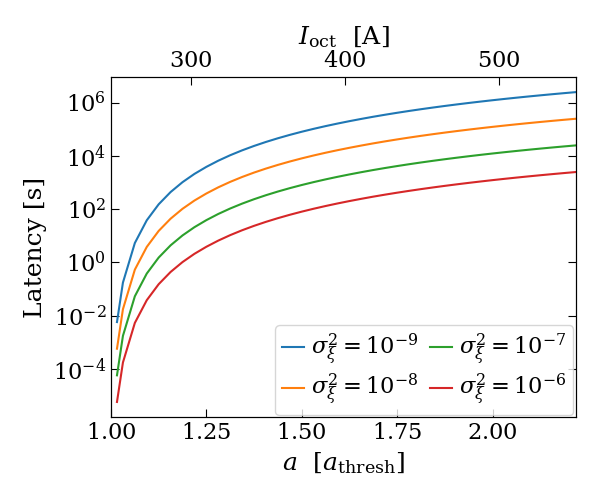

In [162]:
print(0.1e-6/emittgeox**.5)
plt.figure()
sigma_ks = np.logspace(-4.5,-3,4)
for i, sigk in enumerate(sigma_ks):
    plt.semilogy(axs/axt,Lats*(sigma_k/sigk)**2,label=r'$\sigma_\xi^2=10^{%.0f}$'%(np.log10(sigk**2)))

ax1 = plt.gca()
ax2=ax1.twiny()

ax1.set_xlim(1,np.max(axs/axt))
ax2.set_xlim(Ithr,Ioct)

ax1.set_xlabel(r'$a$  $[a_\mathrm{thresh}]$')
ax2.set_xlabel(r'$I_\mathrm{oct}$  $[\mathrm{A}]$')
ax1.set_ylabel(r'Latency [s]')
ax1.legend(loc=0,ncol=2,columnspacing=0.5)
plt.tight_layout()
plt.savefig('01_Plots/LatencySingleModeScan.eps')




-2 5


<IPython.core.display.Javascript object>


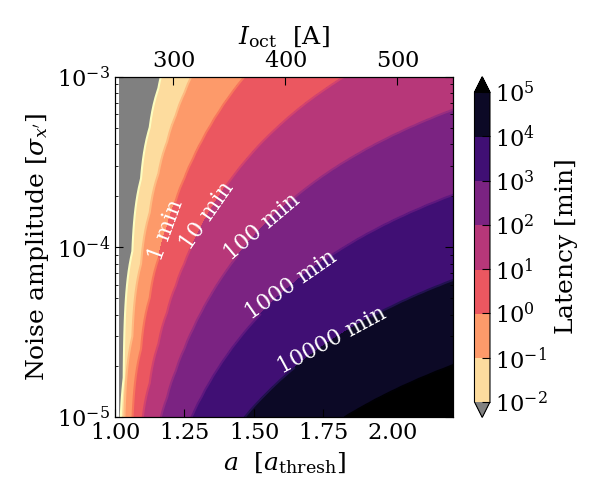

In [199]:
sigma_ks = np.logspace(-5,-3,50)
Lats2D = Lats[:,np.newaxis]*(sigma_k/sigma_ks)**2

cmap0 = cm.get_cmap(['plasma_r','inferno_r','hot_r','magma_r','rainbow_r'][3])
cmap0.set_over('k')
cmap0.set_under('grey')

tunit = 1
tscale = [1,60][tunit]
tlabel = ['s','min'][tunit]
Zmin = max(-1,np.log10(np.nanmin(Lats2D/tscale))-1)
Zmax = (np.log10(np.nanmax(Lats2D/tscale))+0)
Zmin=-2 ; Zmax=5
lev_exp = np.arange(np.floor(Zmin),np.ceil(Zmax)+0.1,1)
print(Zmin,Zmax)
levs = np.power(10, lev_exp)


plt.figure()
ax1 = plt.gca()
X,Y = np.meshgrid(axs/axt,sigma_ks)
plt.yscale('log')

CS2 = plt.contour(X,Y,Lats2D.T/tscale,levs, norm=mpl.colors.LogNorm(),cmap=cmap0,extend='both')
plt.contourf(X,Y,Lats2D.T/tscale,levs, norm=mpl.colors.LogNorm(),cmap=cmap0,extend='both')
ax1.clabel(CS2, CS2.levels[np.logical_and(CS2.levels>=1,CS2.levels%1==0)],inline=True,inline_spacing=0,fmt='%.0f '+tlabel,
                 colors='w',fontsize=16, 
                 )#, fmt=fmt)

cb=plt.colorbar(label='Latency [$\mathrm{%s}$]'%tlabel)
cb.set_ticks(10**np.arange(np.floor(Zmin),np.ceil(Zmax)+0.1,1))


ax2=ax1.twiny()
ax1.set_xlim(1,np.max(axs/axt))
ax2.set_xlim(Ithr,Ioct)



ax1.set_xlabel(r'$a$  $[a_\mathrm{thresh}]$')
ax2.set_xlabel(r'$I_\mathrm{oct}$  $[\mathrm{A}]$')
ax1.set_ylabel(r"Noise amplitude [$\sigma_{x'}$]")
plt.tight_layout()
plt.savefig('01_Plots/LatencySingleModeScan_2D.eps')

# Comparison of diffusion coefficients (Leb vs SVF)

In [7]:
from PyRADISE.Coefficients import DiffCoeff3
from PyRADISE.Coefficients import calc_LandauDampedOneMode as onemode
Qx = 0.31
athresh=5e-4 
ax = 1.5*athresh
bx = -0.7*ax *1
f_rev = 1 #11.2455e3
Qs = 0.002


# ax = 3.4e-5
# bx = -4e-5


sigma_ibs=0
D_ibs = f_rev*sigma_ibs**2/2
sigma_k = 3e-4/np.sqrt(1e5)
sigma_k = 1e-4
Pnoise = f_rev*sigma_k**2
D_k = f_rev*sigma_k**2/2




nQ = 60
integrator_epsilon=1e-6 *ax/1e-4 *[1,4][bx==0]


wmode__DQ = [(7e-4+3e-4j)/(4*np.pi)]
wmode__DQ = [(-2.934e-4+2.5e-5j)*5]
# wmode__DQ = [(1+1j)*6.5e-3/(4*np.pi)]
# wmode__DQ = [(2+1j)*5.83e-3/(4*np.pi)]
# wmode__DQ = [(3+1j)*5.095e-3/(4*np.pi)]
# wmode__DQ = [5e-5+1j*2.86e-5]
# wmode__DQ = [14e-5+1j*0.3e-5]
# wmode__DQ = [-7.821e-5+3.637e-6j] 
wmodeQ0 = [Qx]

# PySSD
distribution = Gaussian()
detuning = LinearDetuning(Qx,ax,bx)
integrator1 = Integrator(distribution, detuning, maxJ=18,epsilon = integrator_epsilon)
integrator2 = Integrator(distribution, detuning, maxJ=18,epsilon = integrator_epsilon*2)


J = np.linspace(-4.1,1.1,300)
# J = np.linspace(0,6,150)
# J = np.linspace(3.6,4.4,150)
# J = np.linspace(-10,10,150)
incoQ = Qx*0 + detuning(J,0)

self= empty()
self.M = empty()
self.Q = empty()
self.M.Q=detuning
self.M.Q.Q0x = Qx
self.M.wmode__DQx = np.array([wmode__DQ]) if np.shape(wmode__DQ)==() else np.array(wmode__DQ)
self.M.wmodeLdDQx = np.zeros_like(self.M.wmode__DQx)
self.M.wmodeDipmx = np.array([wmodeDipm]) if np.shape(wmodeDipm)==() else np.array(wmodeDipm)
self.integrator_epsilon=integrator_epsilon


flagFindalpha=0
# calc_LandauDampedAllModes(self,plane=0,debug=0,tol=1e-4,relstep=[.5,.05],flagFindalpha=flagFindalpha)
# wmodeLdDQ = [Wji]
# print(Wji)


# wmodeLdDQ_alpham11, alpha ,cnt,err= onemode(self,integrator,Qx,wmode__DQ[0],flagFindalpha=[-1,1])
# print(wmodeLdDQ_alpham11,cnt)

wmodeLdDQ_alpha11,cnt,alpha11 ,err= calc_CapitalOmega(distribution,detuning,integrator_epsilon,Qx,wmode__DQ[0],flagFindalpha=[1,1])
print(wmodeLdDQ_alpha11,Qx+wmodeLdDQ_alpha11,cnt)
wmodeLdDQ_alpha10 ,cnt,alpha10,err= calc_CapitalOmega(distribution,detuning,integrator_epsilon,Qx,wmode__DQ[0],flagFindalpha=[1,0])
print(wmodeLdDQ_alpha10,cnt)
wmodeLdDQ_alpha00 ,cnt,alpha00,err= calc_CapitalOmega(distribution,detuning,integrator_epsilon,Qx,wmode__DQ[0],flagFindalpha=[0,0])
print(wmodeLdDQ_alpha00,cnt)

# def calc_LandauDampedOneMode(self,integrator,Q0,modeDQ,relstep=[1,.05],tol=1e-4,flagFindalpha=1,debug=0):
#     global Wjs, wjs, Wji
#     return dampDQ
# def calc_LandauDampedOneMode(self,integrator,Q0,modeDQ,relstep=[.5,.05],tol=1e-4,flagFindalpha=[1,1],debug=0):
print(np.abs(1.44e+00 +5.51e-02j)**1)

R_D = (-pi2*np.imag(wmodeLdDQ_alpha11))**2.5 / (ax*sigma_k*1*np.abs(wmode__DQ[0])*pi2)
print('R_D',R_D)#,np.imag(wmodeLdDQ_alpha11) / (ax*sigma_k*1*np.abs(wmode__DQ[0])*pi2))
print('|g|',np.abs(wmode__DQ[0]*4*np.pi),wmode__DQ[0]*4*np.pi)
print('modeDQ= %.4e +  %.4ej'%(wmode__DQ[0].real,wmode__DQ[0].imag))

Found alpha!=1, alpha=9.56e-01 -2.14e-01j |  dampDQ = -1.01e-03 -2.079e-04j -> -1.06e-03 -1.987e-04j
(-0.0010581536798197305-0.00019869150511726274j) (0.3089418463201803-0.00019869150511726274j) 5
Found alpha!=1, alpha=9.56e-01 +0.00e+00j |  dampDQ = -1.01e-03 -2.079e-04j -> -1.01e-03 -1.987e-04j
(-0.0010137269690087558-0.00019869150511726274j) 5
(-0.0010137269690087558-0.00020793204601922627j) 5
1.4410537845618392
R_D 79.36989339149562
|g| 0.018501666793974216 (-0.018434865691264905+0.0015707963267948967j)
modeDQ= -1.4670e-03 +  1.2500e-04j


In [8]:
# lebedev
freeQs = J*ax + Qx
cohDQs = np.zeros((len(freeQs)), dtype='complex')
for k, q in enumerate(freeQs):
    cohDQs[k] = (2*integrator1.integrate(q) 
                  -integrator2.integrate(q) )

R = -1/cohDQs
dQ = wmode__DQ

eps =  1+ dQ*R
Dl = D_k *1/np.abs(eps)**2 
Dl2= D_k * np.abs(dQ*R/eps)**2



print(R)
print(dQ)

0.9791552641798634


<IPython.core.display.Javascript object>


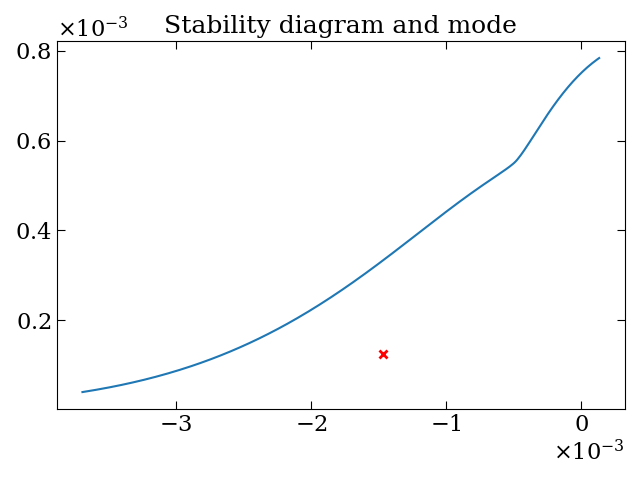

<IPython.core.display.Javascript object>


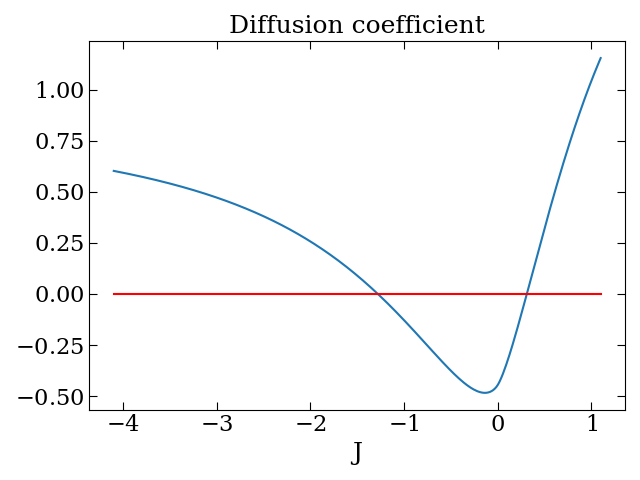

/home/sfuruset/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


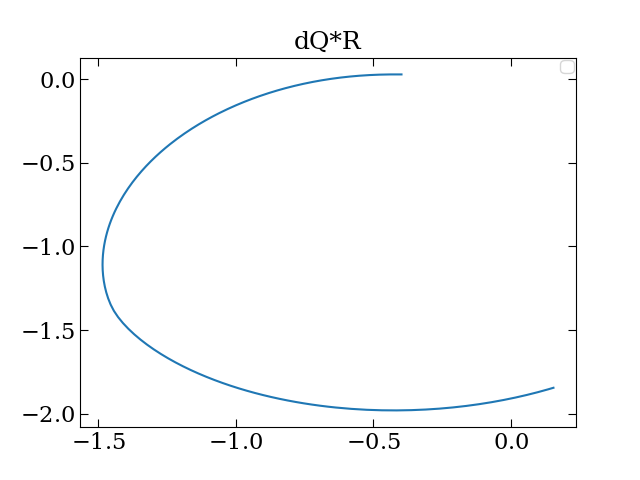

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


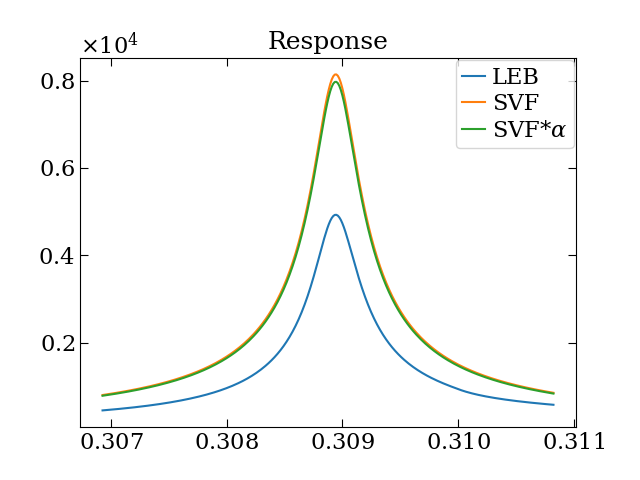

0.0014723158628500883 0.0010766464249333668


In [9]:
Dl = D_k *1/np.abs(eps)**2 
Dl2= D_k * np.abs(dQ*R/eps)**2

alpha=1.25e+00 +2.12e-01j
alpha=9.24e-01 -1.82e-01j
alpha=9.45e-01 -2.06e-01j 
alpha=9.98e-01 -2.30e-01j
alpha=9.56e-01 -2.14e-01j  # b=-0.7a, 1.5*athresh, athresh=5e-4
# alpha=1.46e+00 -3.01e-02j
# alpha=1.37e+00 +1.49e-01j
alpha=1.39e+00 +1.22e-01j   # b=0, 1.5*athresh, athresh=5e-4
# alpha=1.30e+00 +1.89e-01j
# alpha=1.33e+00 +1.70e-01j # b=0, 1.25*athresh, athresh=5e-4
# alpha=1.34e+00 +1.61e-01j
alpha=1.27e+00 +2.05e-01j
alpha=1.26e+00 +2.09e-01j
alpha=1.25e+00 +2.10e-01j

alpha=alpha11
absalpha = abs(alpha).real
print(absalpha)
plt.figure()
plt.title("Stability diagram and mode")
plt.plot(cohDQs.real,cohDQs.imag)
plt.plot(wmode__DQ[0].real,wmode__DQ[0].imag,'rx')
plt.tight_layout()

plt.figure()
plt.title("Diffusion coefficient")
plt.plot(J,eps)
plt.plot(J,Dl,'r')
plt.xlabel('J')
plt.tight_layout()


Response = R/eps

dipm=1
dampDQ = wmodeLdDQ_alpha11
modeQ0 = wmodeQ0[0]    
modeDQ = wmode__DQ[0]
newQ2  =  (modeQ0+dampDQ.real)**2 - (dampDQ.imag)**2
newQIR =  (modeQ0+dampDQ.real)*dampDQ.imag
# absModeDQ2 = np.abs(modeDQ)**2
# B = 1/(1 + (newQ2 - (incoQ)**2)**2/(4*(newQIR)**2))
# USHO_response = np.sqrt(absModeDQ2 * B / (4*(newQIR)**2)) # dipm*sigma_k 
USHO_response = 1 / np.sqrt( (newQ2 - (incoQ)**2)**2 + 4*(newQIR)**2 )

plt.figure()
# plt.plot((dQ*R).real,label='real',)
# plt.plot((dQ*R).imag, label='imag')
plt.plot((dQ*R).real,(dQ*R).imag)
# plt.plot(np.abs(dQ*R), label='abs')
plt.legend(loc=0)
plt.title('dQ*R')

plt.figure()
plt.title("Response")
plt.plot(freeQs, np.abs(Response),label='LEB')
plt.plot(freeQs, USHO_response ,label='SVF')
plt.plot(freeQs, USHO_response*absalpha ,label=r'SVF*$\alpha$')
plt.legend(loc=0)

print( np.abs(modeDQ), np.abs(dampDQ))

Correction of mode 0: 1+(2.1e-03)
Correction of mode 0: 1+(1.8e-03)
Correction of mode 0: 1+(1.8e-03)


<IPython.core.display.Javascript object>


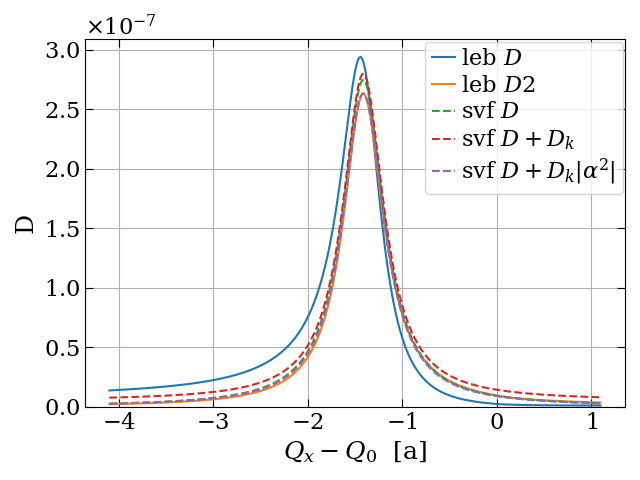

In [10]:
# alpha=1.37e+00 -4.99e-01j
# absalpha = np.abs(alpha)

D11,err = DiffCoeff3(J,D_ibs,D_k,[1],[0],Qs,incoQ,wmodeQ0,wmode__DQ,[1] ,[wmodeLdDQ_alpha11])
D00,err = DiffCoeff3(J,D_ibs,D_k,[1],[0],Qs,incoQ,wmodeQ0,wmode__DQ,[1] ,[wmodeLdDQ_alpha00])
# Dm11,err = DiffCoeff3(J,D_ibs,D_k,[1],[0],Qs,incoQ,wmodeQ0,wmode__DQ,[1],[wmodeLdDQ_alpham11])
D10,err = DiffCoeff3(J,D_ibs,D_k,[1],[0],Qs,incoQ,wmodeQ0,wmode__DQ,[1] ,[wmodeLdDQ_alpha10])


lss = ['-','--','-.',':']
plt.figure()
plt.plot(J,Dl,label=r'leb $D$')
plt.plot(J,Dl2,label=r'leb $D$2')
# plt.plot(J,Dl/absalpha**2,label=r'leb $D/|\alpha^2|$')
# plt.plot(J,D_k*0+D00/J,lss[0],label='svf D - alpha=1')
# D0amp = np.max(D00)
# plt.plot(J,np.sqrt(D00/D0amp)*D0amp/J,lss[0],label='svf D - alpha=1')
# plt.plot(J,D_k*0+D00,label='svf JD - alpha=1')
plt.plot(J,D_k*0+D11/J,lss[1],label='svf $D$')
plt.plot(J,D_k*1+D11/J,lss[1],label='svf $D + D_k$')
plt.plot(J,D_k*0+D11/J*absalpha**2,lss[1],label=r'svf $D + D_k|\alpha^2|$')
# plt.plot(J,D_k*0+D11,lss[2],label='svf JD - find alpha')
# plt.plot(J,Dm11/J,label='svf - find -alpha')
# plt.plot(J,D_k*0+D10/J,'--',label='svf - alpha=real')


plt.legend(loc=0)
plt.xlabel(r'$Q_x-Q_0$  [a]')
plt.ylabel('D')
# plt.xlim(1,6)
plt.ylim(bottom=0)
plt.grid(True)
plt.tight_layout()


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[2.665e-08 3.069e-08 1.532e-08 2.488e-08 1.450e-08 7.543e-09 1.053e-08
 2.274e-08 2.230e-08 3.978e-08 1.881e-08 1.537e-08 7.521e-09 1.571e-08
 3.596e-08 1.589e-08 2.090e-08 2.979e-08 4.716e-08 3.253e-08] [12  5  6  4  2 11 13 15 10 16  8  7  3  0 17  1 19 14  9 18] [7.521e-09 7.543e-09 1.053e-08 1.450e-08 1.532e-08 1.537e-08 1.571e-08
 1.589e-08 1.881e-08 2.090e-08 2.230e-08 2.274e-08 2.488e-08 2.665e-08
 2.979e-08 3.069e-08 3.253e-08 3.596e-08 3.978e-08 4.716e-08]


<IPython.core.display.Javascript object>


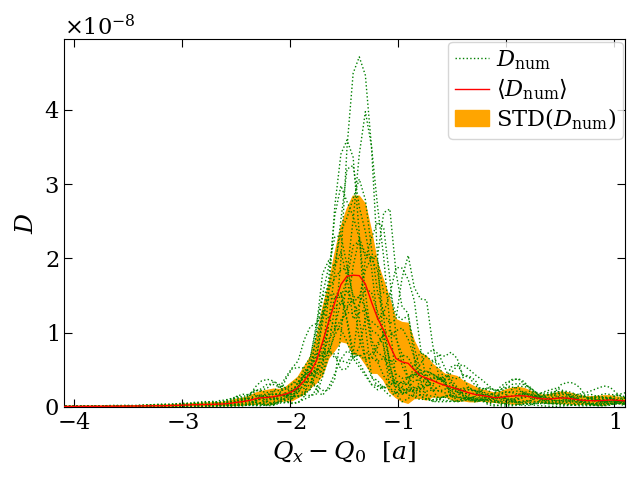

Max of average diff =  1.7735419458649267e-08


In [12]:
flag_noise = 0

folder = "/home/sfuruset/hdd/05_Combi_related/01_output/Diffusion/"
folder666 = "gwImQ1.25e-04_ReQ-1.47e-03_Qp0_N1e-4_0.00to0.5_a7.50e-04_Np1.00e7_T1.0e4_nr666_TD1.0e4_%s.txt"
# folder666 = "gwImQ1.25e-04_ReQ-1.47e-03_Qp150_N1e-4_0.00to0.5_a7.50e-04_Np1.00e7_T1.0e4_nr666_TD1.0e4_%s.txt"
# folder666 = "gwImQ1.25e-04_ReQ-1.47e-03_Qp0_N1e-4_0.00to0.5_a7.50e-04_Np1.00e7_T1.0e4_nr666_TD5.0e3_%s.txt"
# folder666 = "gwImQ2.50e-04_ReQ-2.93e-03_Qp0_N1e-4_0.00to0.5_a1.50e-03_Np1.00e7_T1.0e4_nr666_TD5.0e3_%s.txt"
##folder666 = "gwImQ2.50e-04_ReQ-2.93e-03_Qp0_N1e-4_0.00to0.5_a1.50e-03_Np1.00e7_T1.0e4_nr666_TD1.0e4_%s.txt"
# folder666 = "gwImQ4.64e-04_ReQ9.28e-04_Qp0_N1e-4_0.00to0.5_a6.25e-04_Np1.00e7_T5.0e3_nr666_TD5.0e3_%s.txt"
# folder666 = "gwImQ4.64e-04_ReQ9.28e-04_Qp0_N2e-4_0.00to0.5_a6.25e-04_Np1.00e7_T1.0e4_nr666_TD1.0e4_%s.txt"
# folder666 = "gwImQ4.64e-04_ReQ9.28e-04_Qp0_N1e-4_0.00to0.5_a7.50e-04_Np1.00e7_T1.0e4_nr666_TD1.0e4_%s.txt"
if not flag_noise:
    folder666 = "gwImQ2.50e-04_ReQ-2.93e-03_Qp0_N0_0.00to0.5_a1.50e-03_Np1.00e7_T5.0e3_nr666_TD5.0e3_%s.txt"
    folder666 = "gwImQ1.25e-04_ReQ-1.47e-03_Qp0_N0_0.00to0.5_a7.50e-04_Np1.00e7_T1.0e4_nr666_TD1.0e4_%s.txt"
    
xfilename = folder+folder666%'x'
Dfilename = folder+folder666%'allDiff'

xcenter = np.loadtxt(xfilename)
allDiff = np.loadtxt(Dfilename)

avgDiff = np.mean(allDiff,axis=0)
stdDiff = np.std(allDiff,axis=0)

if 1:
    maxDiff = np.nanmax(allDiff,axis=1)
    ind = maxDiff.argsort()[:-7]
    ind = maxDiff<8e-7
    max20 = np.cumsum(ind)<=20
    ind *=max20
    print(max20)
    print(ind)
    avgDiff = np.mean(allDiff[ind],axis=0)
    stdDiff = np.std(allDiff[ind],axis=0)
    allDiff=allDiff[ind]
    print(maxDiff,maxDiff.argsort(),maxDiff[maxDiff.argsort()])


fig = plt.figure()
ax = fig.gca()


if flag_noise:
#     ax.plot(J,Dl/absalpha**2,'k-.',lw=2,label=r'leb $D/|\alpha^2|$')
    ax.plot(J,D_k*1+D11/J,'b--',lw=2,label=r'$D_\mathrm{Theory}$',zorder=10) # D + D_K

# plt.plot(J,Dl,'k-.',lw=2,label=r'leb $D$')
# plt.plot(J,Dl/absalpha**2,label=r'leb $D/|\alpha^2|$')

# plt.plot(J,D_k*0+D00/J,lss[0],label='svf D - alpha=1')
# D0amp = np.max(D00)
# plt.plot(J,np.sqrt(D00/D0amp)*D0amp/J,lss[0],label='svf D - alpha=1')
# plt.plot(J,D_k*0+D00,label='svf JD - alpha=1')
# plt.plot(J,D_k*0+D11/J,lss[1],label='svf D - find alpha')
# plt.plot(J,D_k*0+D11,lss[2],label='svf JD - find alpha')
# plt.plot(J,Dm11/J,label='svf - find -alpha')
# plt.plot(J,D_k*0+D10/J,'--',label='svf - alpha=real')

plt.plot(xcenter,allDiff[0],'g:',lw=1, label=r'$D_\mathrm{num}$')
plt.plot(xcenter,allDiff[1:].T,'g:',lw=1)
ax.plot(xcenter,avgDiff, 'r', lw=1, label=r'$\langle D_\mathrm{num}\rangle$',zorder=20)
ax.fill_between(xcenter,avgDiff-stdDiff,avgDiff+stdDiff,color='orange',label=r'STD($D_\mathrm{num}$)')

print('Max of average diff = ',np.nanmax(avgDiff))

plt.legend(loc=0,handlelength=1.5)
plt.xlabel(r'$Q_x-Q_0$  $[a]$')
plt.ylabel('$D$')
# plt.xlim(2.8,3.1)
plt.ylim(bottom=0)
# plt.grid(True)
plt.xlim(-4.1,1.1)
# plt.xlim(.9,6.1)
plt.tight_layout()

plt.savefig("01_Plots/%s_Dcomp_%snoise.eps"%(folder666%666,['no',''][flag_noise]))

# Results from COMBI

## Functions

In [21]:
import os
import harpy.harmonic_analysis as harpy

def parseBeamParameter(fileName,filter=1,lower=0,upper=-1,nparam=18):
    data = [];
    for i in np.arange(nparam):
        data.append([]);
    coreName, extension = os.path.splitext(fileName)
    if '.gz' in extension:
        myFile = gzip.open(fileName,'r');
        gzipped = True;
    else:
        myFile = open(fileName,'r');
        gzipped = False;
    count = 0;
    for line in myFile.readlines():
        if gzipped:
            # row = line.decode('latin-1').rstrip().split(' ');
            row = line.rstrip().split(' ');
        else:
            row = line.rstrip().split(' ');
        isLower = 1;
        if upper != -1:
            if count>=upper:
                isLower = 0;
        if count%filter ==0 and count>=lower and isLower:
            if len(row)==nparam:
                for i in np.arange(nparam):
                    data[i].append(float(row[i]));
            else:
                print("ERROR at line",count,':',row,'Skipping line');
        count=count+1;
    myFile.close();
    return data;

## Using a_thresh ~ 1e-4 

In [6]:
# Input
a0 = 1e-4
b0 = -0.7*a0

scales = np.arange(0,2.01,0.2)
for scale in scales:
    print("3 13 %.5f %.6f %.5f %.6f "%(a0*scale,b0*scale,a0*scale,b0*scale))

3 13 0.00000 -0.000000 0.00000 -0.000000 
3 13 0.00002 -0.000014 0.00002 -0.000014 
3 13 0.00004 -0.000028 0.00004 -0.000028 
3 13 0.00006 -0.000042 0.00006 -0.000042 
3 13 0.00008 -0.000056 0.00008 -0.000056 
3 13 0.00010 -0.000070 0.00010 -0.000070 
3 13 0.00012 -0.000084 0.00012 -0.000084 
3 13 0.00014 -0.000098 0.00014 -0.000098 
3 13 0.00016 -0.000112 0.00016 -0.000112 
3 13 0.00018 -0.000126 0.00018 -0.000126 
3 13 0.00020 -0.000140 0.00020 -0.000140 


In [194]:
#Np = 5e6
N=7
data = np.zeros((N,3))
data[:,0] = [250,500,750,1000,1001,1002,2000]
data[0,1:] = [-1.87e-04, 3.59e-05 ]
data[1,1:] = [-2.07e-04, 3.57e-05 ]
data[2,1:] = [-2.13e-04, 3.54e-05]
data[3,1:] = [-2.18e-04, 3.59e-05 ]
data[4,1:] = [-2.18e-04, 3.59e-05 ]
data[5,1:] = [ -2.18e-04, 3.59e-05 ]
data[6,1:] = [-2.14e-04, 3.58e-05 ]

combi_0 = np.empty((N,3))
# combi_0[:,0] = np.arange(0,2.1e-4,2e-5)
combi_0[0,1:] = [ -2.18e-04, 3.59e-05 ] 
combi_0[1,1:] = [-1.95e-04, 3.55e-05 ]
combi_0[2,1:] = [ -1.79e-04, 3.46e-05 ]
combi_0[3,1:] = [ -1.69e-04, 2.89e-05 ]
combi_0[4,1:] = [ -1.61e-04, 2.04e-05 ]
combi_0[5,1:] = [ -1.53e-04, 1.01e-05 ] #

#Np = 5e6
N=7
data = np.zeros((N,3))
data[:,0] = [250,500,750,1000,1001,1002,2000]
data[0,1:] = [-1.87e-04, 3.59e-05 ]
data[1,1:] = [-2.07e-04, 3.57e-05 ]
data[2,1:] = [-2.13e-04, 3.54e-05]
data[3,1:] = [-2.18e-04, 3.59e-05 ]
data[4,1:] = [-2.18e-04, 3.59e-05 ]
data[5,1:] = [ -2.18e-04, 3.59e-05 ]
data[6,1:] = [-2.14e-04, 3.58e-05 ]

N=11
combi_0 = np.empty((N,3))
combi_0[:,0] = np.arange(0,2.1e-4,2e-5)
combi_0[0,1:] = [ -2.2e-04, 3.59e-05 ] 
combi_0[1,1:] = [-1.95e-04, 3.55e-05 ]
combi_0[2,1:] = [ -1.79e-04, 3.46e-05 ]
combi_0[3,1:] = [ -1.69e-04, 2.89e-05 ]
combi_0[4,1:] = [ -1.61e-04, 2.04e-05 ]
combi_0[5,1:] = [ -1.53e-04, 0 ] #+- 1e-5 digging!
combi_0[6,1:] = [ -1.47e-04, np.nan ] 
combi_0[7:,1:]=np.nan

# combi_0[7,1:] = 
# combi_0[8,1:] = 

combi_0 = np.empty((N,4))
combi_0[:]=np.nan
combi_0[:,3] = 0
combi_0[0] = [0,-2.20e-04 , 3.59e-05 , 4.41e-08]
combi_0[1] = [2e-5 , -1.95e-04 , 3.66e-05 , 6.98e-07] #x=0.005, [2000,3000
combi_0[2] = [4e-5 , -1.79e-04 , 3.45e-05 , 9.51e-07] #x=0.005, [2000,3000
combi_0[3] = [6e-5 , -1.69e-04 , 2.75e-05 , 2.74e-07] #x=0.005, [2000,3000
combi_0[4] = [8e-5 , -1.61e-04 , 1.62e-05 , 2.69e-06] #x=0.005, [2000,3000
# combi_0[5] = [1e-5,  -1.53e-4, 0, 0]


N=11
combi_4 = np.empty((N,3))
combi_4[:,0] = np.arange(0,2.1e-4,2e-5)
combi_4[0] = [0e-5, np.nan,0] 
combi_4[1] = [2e-5, -1.96e-04, 3.51e-05 ]
combi_4[2] = [4e-5, -1.79e-04, 3.32e-05 ]
combi_4[3] = [6e-5, -1.68e-04, 2.83e-05 ] 
combi_4[4] = [8e-5, -1.60e-04, 2.06e-05 ] 
combi_4[5] = [10e-5,-1.52e-04, -3.95e-06 ] #+-6e-6  unstable [ -1.52e-04, 1.01e-05 ]
combi_4[6] = [12e-5,-1.43e-04, -1.72e-05 ] #+- 5e-6 unstable [ -1.43e-04, 1.89e-05 ]
combi_4[7] = [14e-5,-1.31e-04, -3.25e-05 ] #+- 4e-5 unstable [ -1.31e-04, 1.58e-05 ] 
combi_4[8] = [16e-5, -1.23e-04, -5.37e-05] #+- 8e-6 
combi_4[9] = [18e-5,-1.30e-04, -6.97e-05]  #+- 5e-6
combi_4[10]= [2e-4,-1.03e-04, -9.00e-05]   #+- 5e-6

combi_4 = np.empty((N,4))
combi_4[0] = [0e-5,  -2.20e-04 , 3.58e-05 , 6.34e-07]
combi_4[1] = [ 2e-5 , -1.96e-04 , 3.54e-05 , 1.78e-06] #1500, [1000,2000
combi_4[2] = [ 4e-5 , -1.79e-04 , 3.19e-05 , 3.26e-06] #1000, [1000,2000
combi_4[3] = [ 6e-5 , -1.68e-04 , 2.71e-05 , 2.95e-06] #1000, [1000,2000
combi_4[4] = [ 8e-5 , -1.60e-04 , 9.40e-06 , 5.18e-06] # 0, [1000,2000
combi_4[5] = [10e-5 , -1.52e-04 , -6.19e-06 , 4.35e-06]# 0, [1000,1500
combi_4[6] = [12e-5 , -1.43e-04 , -1.94e-05 , 4.04e-06]# 0, [1000,1500
combi_4[7] = [14e-5 , -1.30e-04 , -3.57e-05 , 4.30e-06]# 0, [1000,1500
combi_4[8] = [16e-5 , -1.20e-04 , -5.23e-05 , 6.34e-06]# 0, [1000,1500
combi_4[9] = [18e-5 , -1.23e-04 , -6.88e-05 , 6.36e-06]# 0, [1000,1500
combi_4[10]= [20e-5 , -1.02e-04 , -8.77e-05 , 5.48e-06] # 0, [1000,1500

N=11
combi_2 = np.empty((N,3))
combi_2[0] = [0,np.nan,np.nan]
combi_2[1] = [2e-5, -1.99e-04, 3.52e-05 ] 
combi_2[2] = [4e-5, -1.79e-04, 3.34e-05 ] 
combi_2[3] = [6e-5, -1.68e-04, 2.87e-05 ] 
combi_2[4] = [8e-5, -1.60e-04, 2.09e-05 ] 
combi_2[5] = [10e-5,-1.53e-04, -6.07e-06 ] # unstable [ -1.53e-04, 1.06e-05 ]
combi_2[6] = [12e-5,-1.40e-04, -2.03e-05 ] # +-6e-6  # unstable [ -1.43e-04, 1.41e-05 ] 
combi_2[7] = [14e-5,-1.31e-04, -3.61e-05 ] # unstable [ -1.29e-04, 9.71e-06 ] 
combi_2[8] = [16e-5,-1.15e-04, -5.33e-05 ] #
combi_2[9] = [18e-5,-8.95e-05 , -6.52e-05 ] #+-4e-6
combi_2[10]= [20e-5,-8.95e-05, -1.05e-04 ] #+-1e-5

combi_2 = np.empty((N,4))
combi_2[0] = [0e-5, -2.20e-04, 3.57e-05 ,  7.10e-07] 
combi_2[1] = [2e-5 , -1.99e-04 , 3.58e-05 , 1.09e-06] #1500, [1000,2000
combi_2[2] = [4e-5 , -1.79e-04 , 3.12e-05 , 3.73e-06] #1000, [1000,2000
combi_2[3] = [6e-5 , -1.68e-04 , 2.66e-05 , 3.55e-06] #1000, [1000,2000
combi_2[4] = [8e-5 , -1.60e-04 , 1.17e-05 , 4.20e-06] #   0, [1000,2000
combi_2[5] = [10e-5 , -1.53e-04 , -7.11e-06 , 2.68e-06] # 0, [1000,1500
combi_2[6] = [12e-5 , -1.4e-04 , -2.36e-05 , 6.89e-06] # 0, [1000,1500
combi_2[7] = [14e-5 , -1.31e-04 , -3.36e-05 , 2.84e-06] # 0, [1000,1500
combi_2[8] = [16e-5 , -1.15e-04 , -5.11e-05 , 5.43e-06] # 0, [1000,1500
combi_2[9] = [18e-5 ,-8.95e-05 , -6.56e-05 , 1.87e-06] # 0, [1000,1500
combi_2[10]= [20e-5 , -8.95e-05 , -1.07e-04 , 8.71e-06] # 0, [1000,1500


In [195]:
#Theory alpha=1
N=11
theory_fa0 = np.zeros((N,3))
theory_fa0[:,0] = np.arange(0,2.1e-4,2e-5)

# theory_fa0[1] = [2.00e-05 , -1.96e-04 , 3.52e-05]
# theory_fa0[2] = [4.00e-05 , -1.82e-04 , 3.22e-05]
# theory_fa0[3] = [6.00e-05 , -1.73e-04 , 2.42e-05]
# theory_fa0[4] = [8.00e-05 , -1.66e-04 , 1.17e-05]
# theory_fa0[5] = [1.00e-04 , -1.57e-04 , -3.60e-06]
# theory_fa0[6] = [1.20e-04 , -1.45e-04 , -2.12e-05]
# theory_fa0[7] = [1.40e-04 , -1.32e-04 , -3.92e-05]
# theory_fa0[8] = [1.60e-04 , -1.18e-04 , -5.71e-05]
# theory_fa0[9] = [1.80e-04 , -1.04e-04 , -7.48e-05]
# theory_fa0[10] = [2.00e-04 , -8.92e-05 , -9.24e-05]
theory_fa0[0] = [0.00e+00 , -2.2e-04 , 3.59e-05]
theory_fa0[1] = [2.00e-05 , -1.98e-04 , 3.59e-05]
theory_fa0[2] = [4.00e-05 , -1.85e-04 , 3.46e-05]
theory_fa0[3] = [6.00e-05 , -1.78e-04 , 2.69e-05]
theory_fa0[4] = [8.00e-05 , -1.69e-04 , 1.33e-05]
theory_fa0[5] = [1.00e-04 , -1.59e-04 , -3.17e-06]
theory_fa0[6] = [1.20e-04 , -1.47e-04 , -2.08e-05]
theory_fa0[7] = [1.40e-04 , -1.34e-04 , -3.87e-05]
theory_fa0[8] = [1.60e-04 , -1.20e-04 , -5.67e-05]
theory_fa0[9] = [1.80e-04 , -1.06e-04 , -7.45e-05]
theory_fa0[10] = [2.00e-04 , -9.13e-05 , -9.21e-05]

#Theory alpha=x
N=11
theory_fa1 = np.zeros((N,3))
theory_fa1[:,0] = np.arange(0,2.1e-4,2e-5)
# theory_fa1[0] = [0.00e+00 , -2.18e-04 , 3.59e-05]
# theory_fa1[1] = [2.00e-05 , -1.96e-04 , 3.52e-05]
# theory_fa1[2] = [4.00e-05 , -1.84e-04 , 3.19e-05]
# theory_fa1[3] = [6.00e-05 , -1.75e-04 , 2.41e-05]
# theory_fa1[4] = [8.00e-05 , -1.67e-04 , 1.21e-05]
# theory_fa1[5] = [1.00e-04 , -1.60e-04 , -2.97e-06]
# theory_fa1[6] = [1.20e-04 , -1.52e-04 , -2.01e-05]
# theory_fa1[7] = [1.40e-04 , -1.41e-04 , -3.88e-05]
# theory_fa1[8] = [1.60e-04 , -1.31e-04 , -5.75e-05]
# theory_fa1[9] = [1.80e-04 , -1.23e-04 , -7.57e-05]
# theory_fa1[10] = [2.00e-04 , -1.09e-04 , -9.42e-05]
theory_fa1[0] = [0.00e+00 , -2.2e-04 , 3.59e-05]
theory_fa1[1] = [2.00e-05 , -1.98e-04 , 3.52e-05]
theory_fa1[2] = [4.00e-05 , -1.82e-04 , 3.19e-05]
theory_fa1[3] = [6.00e-05 , -1.73e-04 , 2.39e-05]
theory_fa1[4] = [8.00e-05 , -1.65e-04 , 1.18e-05]
theory_fa1[5] = [1.00e-04 , -1.58e-04 , -3.38e-06]
theory_fa1[6] = [1.20e-04 , -1.50e-04 , -2.05e-05]
theory_fa1[7] = [1.40e-04 , -1.43e-04 , -3.83e-05]
theory_fa1[8] = [1.60e-04 , -1.33e-04 , -5.70e-05]
theory_fa1[9] = [1.80e-04 , -1.20e-04 , -7.61e-05]
theory_fa1[10] = [2.00e-04 , -1.12e-04 , -9.39e-05]




## Using a_thresh = 9.64e-5

In [196]:


pi2 = np.pi*2
gamma = 6500/0.938272
beta = 0.4
emitX=2e-6
sigx = np.sqrt(beta*emitX/gamma)
sigp = sigx/beta

# Combi
sep0 = 0.01
a_thr = 9.64e-5
folder1 = '/home/sfuruset/hdd/05_Combi_related/01_output/Omega/'
folder = r'w0.5_Qp-5_N0_%.2fto0.2'%sep0+'_a%.2e_g0_Np5e6_Ns1000'


folders =[]
labels = []

for i in range(21):
    a = i/10*a_thr
    folders+=[folder%a]
#            labels+=[r'$a=%.1f\cdot10^{-5}$'%(a*1e5)]
    labels+=[r'$a=%.1f\cdot a_\mathrm{thr}$'%(i/10)]
    

print('combi_thr_%d = np.empty((N,5))'%(sep0*100))

for iname,name in enumerate(folders[:21]):
    try: 
        data = parseBeamParameter(folder1+name+"/B1b1.bparam"); 
        T = np.arange(np.size(data[0]))           
    except:
        print('Could not find %s'%(name))
        continue


    Nt=np.size(data[0])
    maxNt = 1*10**4
    stop = 600000
    stop = np.min([Nt,maxNt,stop])    
    X = np.array(data[0][:stop])/sigx
    COM = np.sqrt( ((data[0]/sigx)**2 + (data[4]/sigp)**2)/1.)
    
    
    # Find instability start
    thresh = 0.009
    if COM[-1]>thresh or sep0 >0:
        logCOM = np.log(COM)
        if sep0 == 0 :
            start0 = np.argmax(COM>thresh)
            stop0 = -1
            fit0 = np.polyfit(T[start0:stop0],logCOM[start0:stop0],deg=1)
            # logCOM = fit[1] + T*fit[0]
            start1 = int((np.log(5e-3)-fit0[1])/fit0[0])
            start = min(start1,30000)
            length=3000
            fit = np.polyfit(T[start:start+length],logCOM[start:start+length],deg=1)
#                print(iname,'Start = %d -> %d -> %d'%(start0,start1,start),fit0/pi2,fit/pi2)

            if iname<5:
                lengths = (2+np.arange(6))*(5-iname)*500
            else:
                lengths = (2+np.arange(6))*500 #-1000         
        else:
            start = 500*0 + 125 *0
#             start = 125
            if iname<10:
                start = 125
                lengths = (2+np.arange(6))*max(2,9-iname)*250
            else :
                lengths = (3+np.arange(6))*250 #-1000 

        fits = np.zeros((6,2))
        for il , length in enumerate(lengths):
            fits[il] = np.polyfit(T[start:start+length],logCOM[start:start+length],deg=1)
            #print(start,start+length,fits[il])
        if iname>15:
            fits = fits[:4,:]
            
        grr = np.mean(fits[:,0])/pi2
        std = np.std(fits[:,0])/pi2
#         print(iname, start, 'a = %.2e: %.2e , %.2e'%(a_thr*iname/10,grr,std),fits[:,0]/pi2)

    # Find tune 
    ## Harpy analysis
    Q0 = 0.31  
    start = 10000 * 0
    Qlist = np.empty(5)
    for istop in range(5):
        stop = 10000 *(1+istop)
        X = data[0][start:stop]/sigx #/ COM
        maxNt = 1*10**5
        X = np.pad(X,(0,maxNt-np.size(X)),mode='constant')

        harmonic = harpy.HarmonicAnalysis(X)
        Q,amp = harmonic.laskar_method(6)
    #     print(Q,amp, Q[0])
        Q = np.array(Q)
        Q = Q[np.logical_and(Q>0.1,Q<0.4)]
        Qlist[istop] = Q[0]
    Q = np.mean(Qlist)
    Qstd=np.std(Qlist)
    print("combi_thr_%d[%d] = [%.2e, %.2e, %.2e, %.2e, %.2e] #"%(sep0*100,iname,a_thr*iname/10, Q-Q0, grr,std,Qstd)
         , (Qlist-Q0)*1e6)

combi_thr_1 = np.empty((N,5))
Could not find w0.5_Qp-5_N0_0.01to0.2_a0.00e+00_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a9.64e-06_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a1.93e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a2.89e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a3.86e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a4.82e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a5.78e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a6.75e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a7.71e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a8.68e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a9.64e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a1.06e-04_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a1.16e-04_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a1.25e-04_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a1.35e-04_g0_Np5e6_Ns1000
Could not 

In [197]:
# With less turns at higher a
N=21

combi_thr_1 = np.empty((N,5))
combi_thr_1[0] = [0.00e+00, -2.14e-04, 3.59e-05, 4.02e-08, 2.63e-06]
combi_thr_1[1] = [9.64e-06, -2.03e-04, 3.57e-05, 8.82e-08, 8.61e-07]
combi_thr_1[2] = [1.93e-05, -1.93e-04, 3.53e-05, 3.51e-07, 9.36e-07]
combi_thr_1[3] = [2.89e-05, -1.84e-04, 3.47e-05, 3.99e-07, 2.76e-06]
combi_thr_1[4] = [3.86e-05, -1.74e-04, 3.20e-05, 2.28e-06, 2.81e-06]
combi_thr_1[5] = [4.82e-05, -1.76e-04, 2.96e-05, 2.40e-06, 2.94e-06]
combi_thr_1[6] = [5.78e-05, -1.64e-04, 2.39e-05, 4.92e-06, 3.19e-06]
combi_thr_1[7] = [6.75e-05, -1.69e-04, 1.83e-05, 3.30e-06, 1.82e-08]
combi_thr_1[8] = [7.71e-05, -1.62e-04, 1.34e-05, 5.82e-06, 3.60e-06]
combi_thr_1[9] = [8.68e-05, -1.58e-04, 4.23e-06, 1.82e-06, 3.43e-06]
combi_thr_1[10] = [9.64e-05, -1.52e-04, 1.24e-06, 2.82e-06, 3.39e-06]
combi_thr_1[11] = [1.06e-04, -1.52e-04, -1.28e-05, 1.27e-06, 2.98e-06]
combi_thr_1[12] = [1.16e-04, -1.48e-04, -9.75e-06, 2.17e-06, 2.86e-06]
combi_thr_1[13] = [1.25e-04, -1.39e-04, -1.71e-05, 6.96e-06, 2.44e-06]
combi_thr_1[14] = [1.35e-04, -1.37e-04, -2.62e-05, 3.11e-06, 7.31e-06]
combi_thr_1[15] = [1.45e-04, -1.35e-04, -5.11e-05, 7.77e-06, 4.76e-06]
combi_thr_1[16] = [1.54e-04, -1.16e-04, -3.60e-05, 5.74e-07, 8.25e-06]
combi_thr_1[17] = [1.64e-04, -1.24e-04, -5.49e-05, 5.04e-06, 4.14e-06]
combi_thr_1[18] = [1.74e-04, -8.69e-05, -7.02e-05, 7.31e-06, 3.58e-06]
combi_thr_1[19] = [1.83e-04, -9.96e-05, -6.51e-05, 1.78e-06, 2.39e-05]
combi_thr_1[20] = [1.93e-04, -1.14e-04, -1.05e-04, 6.78e-06, 1.06e-05]

combi_thr_2 = np.empty((N,5))
combi_thr_2[0] = [0.00e+00, -2.16e-04, 3.58e-05, 3.17e-08, 1.92e-06]
combi_thr_2[1] = [9.64e-06, -2.05e-04, 3.57e-05, 1.43e-07, 1.42e-07]
combi_thr_2[2] = [1.93e-05, -1.95e-04, 3.53e-05, 2.77e-07, 1.92e-07]
combi_thr_2[3] = [2.89e-05, -1.86e-04, 3.47e-05, 5.23e-07, 2.00e-06]
combi_thr_2[4] = [3.86e-05, -1.76e-04, 3.28e-05, 1.41e-06, 2.04e-06]
combi_thr_2[5] = [4.82e-05, -1.75e-04, 2.98e-05, 2.92e-06, 2.24e-06]
combi_thr_2[6] = [5.78e-05, -1.65e-04, 2.65e-05, 2.55e-06, 2.42e-06]
combi_thr_2[7] = [6.75e-05, -1.66e-04, 1.83e-05, 4.26e-06, 2.67e-06]
combi_thr_2[8] = [7.71e-05, -1.66e-04, 1.40e-05, 3.49e-06, 3.04e-06]
combi_thr_2[9] = [8.68e-05, -1.53e-04, 8.00e-06, 4.33e-06, 3.51e-06]
combi_thr_2[10] = [9.64e-05, -1.52e-04, -6.25e-06, 3.00e-06, 3.41e-06]
combi_thr_2[11] = [1.06e-04, -1.51e-04, -1.21e-05, 2.07e-06, 3.16e-06]
combi_thr_2[12] = [1.16e-04, -1.44e-04, -1.98e-05, 3.09e-06, 4.01e-06]
combi_thr_2[13] = [1.25e-04, -1.42e-04, -2.55e-05, 2.75e-06, 2.65e-06]
combi_thr_2[14] = [1.35e-04, -1.33e-04, -3.41e-05, 3.16e-06, 3.50e-06]
combi_thr_2[15] = [1.45e-04, -1.28e-04, -4.25e-05, 2.44e-06, 7.48e-06]
combi_thr_2[16] = [1.54e-04, -1.28e-04, -4.56e-05, 1.03e-06, 1.07e-06]
combi_thr_2[17] = [1.64e-04, -1.21e-04, -6.83e-05, 2.53e-06, 4.11e-06]
combi_thr_2[18] = [1.74e-04, -1.46e-04, -7.75e-05, 1.69e-06, 4.42e-06]
combi_thr_2[19] = [1.83e-04, -1.16e-04, -7.91e-05, 5.23e-06, 1.27e-05]
combi_thr_2[20] = [1.93e-04, -9.13e-05, -8.57e-05, 5.99e-06, 2.09e-05]

combi_thr_4 = np.empty((N,5))
combi_thr_4[0] = [0.00e+00, -2.20e-04, 3.58e-05, 4.14e-08, 0.00e+00]
combi_thr_4[1] = [9.64e-06, -2.09e-04, 3.56e-05, 1.06e-07, 0.00e+00]
combi_thr_4[2] = [1.93e-05, -1.99e-04, 3.52e-05, 3.09e-07, 0.00e+00]
combi_thr_4[3] = [2.89e-05, -1.90e-04, 3.44e-05, 8.44e-07, 0.00e+00]
combi_thr_4[4] = [3.86e-05, -1.80e-04, 3.27e-05, 1.54e-06, 0.00e+00]
combi_thr_4[5] = [4.82e-05, -1.71e-04, 2.96e-05, 2.86e-06, 0.00e+00]
combi_thr_4[6] = [5.78e-05, -1.70e-04, 2.50e-05, 3.63e-06, 0.00e+00]
combi_thr_4[7] = [6.75e-05, -1.64e-04, 1.83e-05, 3.07e-06, 1.80e-06]
combi_thr_4[8] = [7.71e-05, -1.64e-04, 1.27e-05, 3.52e-06, 2.05e-06]
combi_thr_4[9] = [8.68e-05, -1.54e-04, 6.29e-06, 3.98e-06, 2.60e-06]
combi_thr_4[10] = [9.64e-05, -1.56e-04, -4.63e-06, 2.51e-06, 2.80e-06]
combi_thr_4[11] = [1.06e-04, -1.43e-04, -1.12e-05, 2.37e-06, 3.65e-06]
combi_thr_4[12] = [1.16e-04, -1.44e-04, -1.81e-05, 2.04e-06, 4.25e-06]
combi_thr_4[13] = [1.25e-04, -1.41e-04, -2.57e-05, 2.84e-06, 2.90e-06]
combi_thr_4[14] = [1.35e-04, -1.34e-04, -3.58e-05, 3.50e-06, 4.11e-06]
combi_thr_4[15] = [1.45e-04, -1.31e-04, -4.06e-05, 4.14e-06, 2.40e-06]
combi_thr_4[16] = [1.54e-04, -1.28e-04, -5.05e-05, 2.30e-06, 3.20e-06]
combi_thr_4[17] = [1.64e-04, -1.24e-04, -6.18e-05, 2.18e-06, 2.57e-06]
combi_thr_4[18] = [1.74e-04, -1.20e-04, -7.20e-05, 3.10e-06, 2.03e-06]
combi_thr_4[19] = [1.83e-04, -9.48e-05, -7.46e-05, 2.11e-06, 2.27e-05]
combi_thr_4[20] = [1.93e-04, -1.23e-04, -8.19e-05, 2.05e-06, 7.53e-06]


In [198]:
# Combi
N = 21

combi_thr_1 = np.empty((N,5))
combi_thr_1[0] = [0.00e+00, -2.14e-04, 3.59e-05, 3.76e-08, 2.63e-06]
combi_thr_1[1] = [9.64e-06, -2.03e-04, 3.57e-05, 8.32e-08, 8.61e-07]
combi_thr_1[2] = [1.93e-05, -1.93e-04, 3.53e-05, 3.32e-07, 9.36e-07]
combi_thr_1[3] = [2.89e-05, -1.84e-04, 3.47e-05, 3.81e-07, 2.76e-06]
combi_thr_1[4] = [3.86e-05, -1.74e-04, 3.23e-05, 2.21e-06, 2.81e-06]
combi_thr_1[5] = [4.82e-05, -1.76e-04, 2.99e-05, 2.36e-06, 2.94e-06]
combi_thr_1[6] = [5.78e-05, -1.64e-04, 2.46e-05, 4.84e-06, 3.19e-06]
combi_thr_1[7] = [6.75e-05, -1.69e-04, 1.91e-05, 3.57e-06, 1.82e-08]
combi_thr_1[8] = [7.71e-05, -1.62e-04, 1.45e-05, 5.98e-06, 3.60e-06]
combi_thr_1[9] = [8.68e-05, -1.58e-04, 4.90e-06, 2.36e-06, 3.43e-06]
combi_thr_1[10] = [9.64e-05, -1.52e-04, 5.83e-06, 3.63e-06, 3.39e-06]
combi_thr_1[11] = [1.06e-04, -1.52e-04, -9.09e-06, 3.96e-06, 2.98e-06]
combi_thr_1[12] = [1.16e-04, -1.48e-04, -1.15e-05, 1.25e-06, 2.86e-06]
combi_thr_1[13] = [1.25e-04, -1.39e-04, -1.94e-05, 1.81e-06, 2.44e-06]
combi_thr_1[14] = [1.35e-04, -1.37e-04, -2.42e-05, 3.21e-06, 7.31e-06]
combi_thr_1[15] = [1.45e-04, -1.35e-04, -4.85e-05, 7.16e-06, 4.76e-06]
combi_thr_1[16] = [1.54e-04, -1.16e-04, -3.48e-05, 1.92e-06, 8.25e-06]
combi_thr_1[17] = [1.64e-04, -1.24e-04, -4.64e-05, 8.55e-06, 4.14e-06]
combi_thr_1[18] = [1.74e-04, -8.69e-05, -7.09e-05, 7.73e-06, 3.58e-06]
combi_thr_1[19] = [1.83e-04, -9.96e-05, -6.05e-05, 2.71e-06, 2.39e-05]
combi_thr_1[20] = [1.93e-04, -1.14e-04, -9.00e-05, 1.17e-05, 1.06e-05]



combi_thr_2 = np.empty((N,5))
combi_thr_2[0] = [0.00e+00, -2.16e-04, 3.58e-05, 3.00e-08, 1.92e-06]
combi_thr_2[1] = [9.64e-06, -2.05e-04, 3.57e-05, 1.35e-07, 1.42e-07]
combi_thr_2[2] = [1.93e-05, -1.95e-04, 3.53e-05, 2.62e-07, 1.92e-07]
combi_thr_2[3] = [2.89e-05, -1.86e-04, 3.48e-05, 4.93e-07, 2.00e-06]
combi_thr_2[4] = [3.86e-05, -1.76e-04, 3.30e-05, 1.36e-06, 2.04e-06]
combi_thr_2[5] = [4.82e-05, -1.75e-04, 3.01e-05, 2.81e-06, 2.24e-06]
combi_thr_2[6] = [5.78e-05, -1.65e-04, 2.68e-05, 2.54e-06, 2.42e-06]
combi_thr_2[7] = [6.75e-05, -1.66e-04, 1.91e-05, 4.44e-06, 2.67e-06]
combi_thr_2[8] = [7.71e-05, -1.66e-04, 1.47e-05, 3.65e-06, 3.04e-06]
combi_thr_2[9] = [8.68e-05, -1.53e-04, 8.84e-06, 4.50e-06, 3.51e-06]
combi_thr_2[10] = [9.64e-05, -1.52e-04, 1.15e-07, 6.20e-06, 3.41e-06]
combi_thr_2[11] = [1.06e-04, -1.51e-04, -7.12e-06, 5.21e-06, 3.16e-06]
combi_thr_2[12] = [1.16e-04, -1.44e-04, -1.30e-05, 6.49e-06, 4.01e-06]
combi_thr_2[13] = [1.25e-04, -1.42e-04, -1.86e-05, 6.95e-06, 2.65e-06]
combi_thr_2[14] = [1.35e-04, -1.33e-04, -2.76e-05, 7.02e-06, 3.50e-06]
combi_thr_2[15] = [1.45e-04, -1.28e-04, -4.03e-05, 4.45e-06, 7.48e-06]
combi_thr_2[16] = [1.54e-04, -1.28e-04, -4.36e-05, 3.07e-06, 1.07e-06]
combi_thr_2[17] = [1.64e-04, -1.21e-04, -5.93e-05, 8.33e-06, 4.11e-06]
combi_thr_2[18] = [1.74e-04, -1.46e-04, -6.87e-05, 9.52e-06, 4.42e-06]
combi_thr_2[19] = [1.83e-04, -1.16e-04, -7.06e-05, 7.83e-06, 1.27e-05]
combi_thr_2[20] = [1.93e-04, -9.13e-05, -7.81e-05, 7.29e-06, 2.09e-05]

combi_thr_4 = np.empty((N,5))
combi_thr_4[0] = [0.00e+00, -2.20e-04, 3.58e-05, 3.94e-08, 0.00e+00]
combi_thr_4[1] = [9.64e-06, -2.09e-04, 3.56e-05, 9.89e-08, 0.00e+00]
combi_thr_4[2] = [1.93e-05, -1.99e-04, 3.53e-05, 2.91e-07, 0.00e+00]
combi_thr_4[3] = [2.89e-05, -1.90e-04, 3.45e-05, 7.98e-07, 0.00e+00]
combi_thr_4[4] = [3.86e-05, -1.80e-04, 3.29e-05, 1.48e-06, 0.00e+00]
combi_thr_4[5] = [4.82e-05, -1.71e-04, 2.99e-05, 2.79e-06, 0.00e+00]
combi_thr_4[6] = [5.78e-05, -1.70e-04, 2.56e-05, 3.64e-06, 0.00e+00]
combi_thr_4[7] = [6.75e-05, -1.64e-04, 1.90e-05, 3.38e-06, 1.80e-06]
combi_thr_4[8] = [7.71e-05, -1.64e-04, 1.35e-05, 3.88e-06, 2.05e-06]
combi_thr_4[9] = [8.68e-05, -1.54e-04, 7.21e-06, 4.32e-06, 2.60e-06]
combi_thr_4[10] = [9.64e-05, -1.56e-04, 7.64e-07, 5.37e-06, 2.80e-06]
combi_thr_4[11] = [1.06e-04, -1.43e-04, -5.70e-06, 5.71e-06, 3.65e-06]
combi_thr_4[12] = [1.16e-04, -1.44e-04, -1.37e-05, 5.01e-06, 4.25e-06]
combi_thr_4[13] = [1.25e-04, -1.41e-04, -2.03e-05, 5.53e-06, 2.90e-06]
combi_thr_4[14] = [1.35e-04, -1.34e-04, -2.87e-05, 6.96e-06, 4.11e-06]
combi_thr_4[15] = [1.45e-04, -1.31e-04, -3.70e-05, 5.63e-06, 2.40e-06]
combi_thr_4[16] = [1.54e-04, -1.28e-04, -4.37e-05, 5.85e-06, 3.20e-06]
combi_thr_4[17] = [1.64e-04, -1.24e-04, -5.51e-05, 6.67e-06, 2.57e-06]
combi_thr_4[18] = [1.74e-04, -1.20e-04, -6.40e-05, 7.16e-06, 2.03e-06]
combi_thr_4[19] = [1.83e-04, -9.48e-05, -6.88e-05, 5.46e-06, 2.27e-05]
combi_thr_4[20] = [1.93e-04, -1.23e-04, -7.51e-05, 5.79e-06, 7.53e-06]


In [199]:
# PyRADISE  -2.20e-04 , 3.59e-05
# with a = 0.1*a_thresh * [0,1,...,20]
theory_thr_fa1 = np.empty((N,3))
theory_thr_fa1[0] = [0.00e+00 , -2.20e-04 , 3.59e-05]
theory_thr_fa1[1] = [9.64e-06 , -2.08e-04 , 3.57e-05]
theory_thr_fa1[2] = [1.93e-05 , -1.99e-04 , 3.53e-05]
theory_thr_fa1[3] = [2.89e-05 , -1.91e-04 , 3.43e-05]
theory_thr_fa1[4] = [3.86e-05 , -1.85e-04 , 3.24e-05]
theory_thr_fa1[5] = [4.82e-05 , -1.80e-04 , 2.93e-05]
theory_thr_fa1[6] = [5.78e-05 , -1.76e-04 , 2.52e-05]
theory_thr_fa1[7] = [6.75e-05 , -1.72e-04 , 2.01e-05]
theory_thr_fa1[8] = [7.71e-05 , -1.68e-04 , 1.41e-05]
theory_thr_fa1[9] = [8.68e-05 , -1.65e-04 , 7.36e-06]
theory_thr_fa1[10] = [9.64e-05 , -1.61e-04 , -1.26e-08]
theory_thr_fa1[11] = [1.06e-04 , -1.58e-04 , -7.90e-06]
theory_thr_fa1[12] = [1.16e-04 , -1.54e-04 , -1.62e-05]
theory_thr_fa1[13] = [1.25e-04 , -1.50e-04 , -2.48e-05]
theory_thr_fa1[14] = [1.35e-04 , -1.45e-04 , -3.36e-05]
theory_thr_fa1[15] = [1.45e-04 , -1.41e-04 , -4.26e-05]
theory_thr_fa1[16] = [1.54e-04 , -1.36e-04 , -5.16e-05]
theory_thr_fa1[17] = [1.64e-04 , -1.31e-04 , -6.06e-05]
theory_thr_fa1[18] = [1.74e-04 , -1.26e-04 , -6.97e-05]
theory_thr_fa1[19] = [1.83e-04 , -1.21e-04 , -7.86e-05]
theory_thr_fa1[20] = [1.93e-04 , -1.16e-04 , -8.74e-05]

# theory_thr_fa1[0] = [0.00e+00 , -2.20e-04 , 3.59e-05]
# theory_thr_fa1[1] = [9.64e-06 , -2.08e-04 , 3.56e-05]
# theory_thr_fa1[2] = [1.93e-05 , -1.99e-04 , 3.47e-05]
# theory_thr_fa1[3] = [2.89e-05 , -1.91e-04 , 3.29e-05]
# theory_thr_fa1[4] = [3.86e-05 , -1.84e-04 , 3.02e-05]
# theory_thr_fa1[5] = [4.82e-05 , -1.78e-04 , 2.69e-05]
# theory_thr_fa1[6] = [5.78e-05 , -1.73e-04 , 2.29e-05]
# theory_thr_fa1[7] = [6.75e-05 , -1.69e-04 , 1.83e-05]
# theory_thr_fa1[8] = [7.71e-05 , -1.66e-04 , 1.29e-05]
# theory_thr_fa1[9] = [8.68e-05 , -1.64e-04 , 6.78e-06]
# theory_thr_fa1[10] = [9.64e-05 , -1.61e-04 , -1.47e-08]
# theory_thr_fa1[11] = [1.06e-04 , -1.58e-04 , -7.90e-06]
# theory_thr_fa1[12] = [1.16e-04 , -1.54e-04 , -1.62e-05]
# theory_thr_fa1[13] = [1.25e-04 , -1.50e-04 , -2.48e-05]
# theory_thr_fa1[14] = [1.35e-04 , -1.45e-04 , -3.36e-05]
# theory_thr_fa1[15] = [1.45e-04 , -1.41e-04 , -4.26e-05]
# theory_thr_fa1[16] = [1.54e-04 , -1.36e-04 , -5.16e-05]
# theory_thr_fa1[17] = [1.64e-04 , -1.31e-04 , -6.06e-05]
# theory_thr_fa1[18] = [1.74e-04 , -1.26e-04 , -6.97e-05]
# theory_thr_fa1[19] = [1.83e-04 , -1.21e-04 , -7.86e-05]
# theory_thr_fa1[20] = [1.93e-04 , -1.16e-04 , -8.74e-05]

theory_thr_fa0 = np.empty((N,3))
theory_thr_fa0[0] = [0.00e+00 , -2.20e-04 , 3.59e-05]
theory_thr_fa0[1] = [9.64e-06 , -2.08e-04 , 3.59e-05]
theory_thr_fa0[2] = [1.93e-05 , -1.99e-04 , 3.59e-05]
theory_thr_fa0[3] = [2.89e-05 , -1.91e-04 , 3.58e-05]
theory_thr_fa0[4] = [3.86e-05 , -1.86e-04 , 3.49e-05]
theory_thr_fa0[5] = [4.82e-05 , -1.82e-04 , 3.24e-05]
theory_thr_fa0[6] = [5.78e-05 , -1.78e-04 , 2.81e-05]
theory_thr_fa0[7] = [6.75e-05 , -1.75e-04 , 2.24e-05]
theory_thr_fa0[8] = [7.71e-05 , -1.71e-04 , 1.56e-05]
theory_thr_fa0[9] = [8.68e-05 , -1.66e-04 , 8.02e-06]
theory_thr_fa0[10] = [9.64e-05 , -1.61e-04 , -1.35e-08]
theory_thr_fa0[11] = [1.06e-04 , -1.56e-04 , -8.35e-06]
theory_thr_fa0[12] = [1.16e-04 , -1.50e-04 , -1.69e-05]
theory_thr_fa0[13] = [1.25e-04 , -1.44e-04 , -2.55e-05]
theory_thr_fa0[14] = [1.35e-04 , -1.38e-04 , -3.42e-05]
theory_thr_fa0[15] = [1.45e-04 , -1.31e-04 , -4.29e-05]
theory_thr_fa0[16] = [1.54e-04 , -1.24e-04 , -5.15e-05]
theory_thr_fa0[17] = [1.64e-04 , -1.18e-04 , -6.01e-05]
theory_thr_fa0[18] = [1.74e-04 , -1.11e-04 , -6.87e-05]
theory_thr_fa0[19] = [1.83e-04 , -1.04e-04 , -7.73e-05]
theory_thr_fa0[20] = [1.93e-04 , -9.69e-05 , -8.58e-05]



theory_thr_DI0 = np.empty((N,3))
theory_thr_DI0[10:] =np.nan
theory_thr_DI0[0] = [0.00e+00 , -2.20e-04 , 3.59e-05]
theory_thr_DI0[1] = [9.64e-06 , -2.08e-04 , 3.57e-05]
theory_thr_DI0[2] = [1.93e-05 , -1.99e-04 , 3.53e-05]
theory_thr_DI0[3] = [2.89e-05 , -1.91e-04 , 3.44e-05]
theory_thr_DI0[4] = [3.86e-05 , -1.85e-04 , 3.27e-05]
theory_thr_DI0[5] = [4.82e-05 , -1.80e-04 , 2.97e-05]
theory_thr_DI0[6] = [5.78e-05 , -1.76e-04 , 2.56e-05]
theory_thr_DI0[7] = [6.75e-05 , -1.72e-04 , 2.03e-05]
theory_thr_DI0[8] = [7.71e-05 , -1.68e-04 , 1.42e-05]
theory_thr_DI0[9] = [8.68e-05 , -1.65e-04 , 7.38e-06]

## a_thresh = 5e-5, gwake

<IPython.core.display.Javascript object>


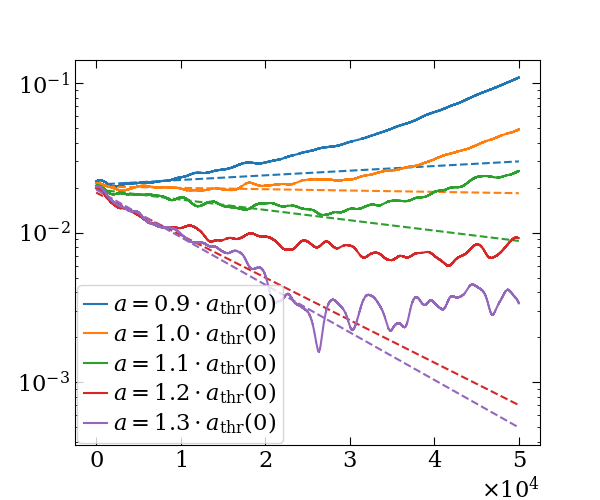

combi_gw_thr_2 = np.empty((N,5))
9 [10000]
combi_gw_thr_2[9] = [4.50e-05, -1.175e-04, 1.137e-06, 0.000e+00, 0.000e+00] 
"""
 ReDQ*1e6  [-117.521]
ImDQ*1e6  [1.137] """
10 [10000]
combi_gw_thr_2[10] = [5.00e-05, -1.125e-04, -3.246e-07, 0.000e+00, 0.000e+00] 
"""
 ReDQ*1e6  [-112.521]
ImDQ*1e6  [-0.325] """
11 [10000]
combi_gw_thr_2[11] = [5.50e-05, -1.140e-04, -2.533e-06, 0.000e+00, 0.000e+00] 
"""
 ReDQ*1e6  [-114.038]
ImDQ*1e6  [-2.533] """
12 [10000]
combi_gw_thr_2[12] = [6.00e-05, -1.068e-04, -1.041e-05, 0.000e+00, 0.000e+00] 
"""
 ReDQ*1e6  [-106.831]
ImDQ*1e6  [-10.415] """
13 [10000]
combi_gw_thr_2[13] = [6.50e-05, -1.059e-04, -1.166e-05, 0.000e+00, 0.000e+00] 
"""
 ReDQ*1e6  [-105.854]
ImDQ*1e6  [-11.663] """


In [22]:
flag_plot = 1

pi2 = np.pi*2
gamma = 6500/0.938272
beta = 0.3
emitX=2e-6
sigx = np.sqrt(beta*emitX/gamma)
sigp = sigx/beta

# Combi
sep0 = 0.02
a_thr = 5e-5
folder1 = '/home/sfuruset/hdd/05_Combi_related/01_output/Omega_gwake/'
# gwImQ1.25e-05_ReQ-1.47e-04_Qp0_N0_0.01to0.5_a9.50e-05_Np1.00e6_T5.0e4_nr0/
folder = r'gwImQ1.25e-05_ReQ-1.47e-04_Qp0_N0_%.2fto0.5_a%.2e_Np1.00e6_T5.0e4_nr%d/'

thresh = 0.009
instab_thresh = 0.2
stab_thresh = 0.004

folders =[]
labels = []

nCopy = 1#0

if flag_plot:
    plt.figure()
    print('combi_gw_thr_%d = np.empty((N,5))'%(sep0*100))

for i in range(26):
    if not i in [9,10,11,12,13]: continue
        
    a = i/10*a_thr
    
    ReQlist = np.empty(nCopy)
    ImQlist = np.empty(nCopy)
    
    for nr in range(nCopy):
        name  = folder%(sep0,a,nr)
    #            labels+=[r'$a=%.1f\cdot10^{-5}$'%(a*1e5)]
        label= r'$a=%.1f\cdot a_\mathrm{thr} (%d)$'%(i/10,nr)



        try: 
            data = parseBeamParameter(folder1+name+"/B1b1.bparam"); 
            T = np.arange(np.size(data[0]))           
        except:
            print('Could not find %s'%(name))
            continue


        Nt=np.size(data[0])
        maxNt = 1*10**4
        stop = 600000
        stop = np.min([Nt,maxNt,stop])    
        X = np.array(data[0][:stop])/sigx
        COM = np.sqrt( ((data[0]/sigx)**2 + (data[4]/sigp)**2)/1.)
        
        if flag_plot and nr==0:
            l0 = plt.plot(COM,label=label)
        # Find instability start
        start=0
        stop = Nt
        if COM[-1]>instab_thresh:
            stop = np.argmax(COM>instab_thresh)
        else:
            temp = np.argmax(COM<stab_thresh)
            if temp>0:
                stop=temp
        stop = min(10**4,stop)
        lengths = [stop-start]
        
        print(i,lengths)
        # get 
        if COM[-1]>thresh or sep0 >0:
            logCOM = np.log(COM)
#             if sep0 == 0 :
#                 start0 = np.argmax(COM>thresh)
#                 stop0 = -1
#                 fit0 = np.polyfit(T[start0:stop0],logCOM[start0:stop0],deg=1)
#                 # logCOM = fit[1] + T*fit[0]
#                 start1 = int((np.log(5e-3)-fit0[1])/fit0[0])
#                 start = min(start1,30000)
#                 length=3000
#                 fit = np.polyfit(T[start:start+length],logCOM[start:start+length],w=COM[start:start+length]**0.5,deg=1)
#     #                print(iname,'Start = %d -> %d -> %d'%(start0,start1,start),fit0/pi2,fit/pi2)

#                 if iname<5:
#                     lengths = (2+np.arange(6))*(5-iname)*500
#                 else:
#                     lengths = (2+np.arange(6))*500 #-1000         
#             else:
#     #             start = 500*0 + 125 *0
#     #             if iname<10:
#     #                 start = 125
#     #                 lengths = (2+np.arange(6))*max(2,9-iname)*250
#     #             else :
#     #                 lengths = (3+np.arange(6))*250 #-1000 
                


            fits = np.zeros((np.size(lengths),2))
            for il , length in enumerate(lengths):
                fits[il] = np.polyfit(T[start:start+length],logCOM[start:start+length], w=COM[start:start+length]**0.5,deg=1)
                #print(start,start+length,fits[il])
    #         if iname>15:
    #             fits = fits[:4,:]


            fit = np.mean(fits,axis=0)
    #         print(fit,fits,np.shape(T),np.shape(np.exp(fit[0]*T+fit[1])))
            if flag_plot and nr==0:
                plt.plot(T, np.exp(fit[0]*T+fit[1]),'--',c=l0[0].get_color())

            grr = np.mean(fits[:,0])/pi2
            std = np.std(fits[:,0])/pi2

            ImQlist[nr] = grr
        # Find tune 
        ## Harpy analysis
        Q0 = 0.31  
        if 1:
            start = 10000 * 0
            Qlist = np.empty(5)
            for istop in range(5):
                stop = 10000 *(1+istop)
                X = data[0][start:stop]/sigx #/ COM
                maxNt = 1*10**5
                X = np.pad(X,(0,maxNt-np.size(X)),mode='constant')

                harmonic = harpy.HarmonicAnalysis(X)
                Q,amp = harmonic.laskar_method(6)
            #     print(Q,amp, Q[0])
                Q = np.array(Q)
                Q = Q[np.logical_and(Q>0.1,Q<0.4)]
                Qlist[istop] = Q[0]
            Q = np.mean(Qlist)
            Qstd=np.std(Qlist)
        else:
            X = data[0][start:stop]/sigx #/ COM
            maxNt = 1*10**5
            X = np.pad(X,(0,maxNt-np.size(X)),mode='constant')

            harmonic = harpy.HarmonicAnalysis(X)
            Q,amp = harmonic.laskar_method(6)
        #     print(Q,amp, Q[0])
            Q = np.array(Q)
            Q = Q[np.logical_and(Q>0.1,Q<0.4)][0]
            
            
        ReQlist[nr] = Q
    Q = np.nanmean(ReQlist)
    Qstd = np.nanstd(ReQlist)
    grr = np.nanmean(ImQlist)
    grrstd = np.nanstd(ImQlist)
    print("combi_gw_thr_%d[%d] = [%.2e, %.3e, %.3e, %.3e, %.3e] "%(sep0*100,i,a_thr*i/10, 
                        Q-Q0, grr,grrstd,Qstd))
    print('"""\n ReDQ*1e6 ', (ReQlist-Q0)*1e6)
    print('ImDQ*1e6 ',ImQlist*1e6,'"""')

if flag_plot :
    plt.legend(loc=0)
    plt.yscale('log')

### Values

In [23]:
#stab_thresh=2e-3
N=26
combi_gw_thr_2 = np.empty((N,5))
combi_gw_thr_2[0] = [0.00e+00, -1.495e-04, 1.250e-05, 1.127e-13, 3.661e-09] 
"""
 ReDQ*1e6  [-149.491 -149.496 -149.493 -149.496 -149.493 -149.492 -149.487 -149.501
 -149.489 -149.494]
ImDQ*1e6  [12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499] """
combi_gw_thr_2[1] = [5.00e-06, -1.401e-04, 1.247e-05, 1.033e-09, 1.876e-09] 
"""
 ReDQ*1e6  [-140.085 -140.08  -140.081 -140.079 -140.082 -140.083 -140.085 -140.083
 -140.08  -140.083]
ImDQ*1e6  [12.466 12.466 12.467 12.464 12.466 12.465 12.466 12.467 12.464 12.466] """
combi_gw_thr_2[2] = [1.00e-05, -1.393e-04, 1.237e-05, 2.642e-09, 3.414e-09] 
"""
 ReDQ*1e6  [-139.273 -139.268 -139.269 -139.263 -139.269 -139.27  -139.27  -139.27
 -139.271 -139.278]
ImDQ*1e6  [12.368 12.366 12.362 12.367 12.367 12.369 12.372 12.368 12.371 12.367] """
combi_gw_thr_2[3] = [1.50e-05, -1.301e-04, 1.219e-05, 8.200e-09, 4.969e-09] 
"""
 ReDQ*1e6  [-130.092 -130.085 -130.096 -130.089 -130.102 -130.087 -130.086 -130.088
 -130.09  -130.094]
ImDQ*1e6  [12.178 12.197 12.203 12.195 12.191 12.193 12.184 12.187 12.176 12.197] """
combi_gw_thr_2[4] = [2.00e-05, -1.295e-04, 1.187e-05, 1.356e-08, 6.290e-09] 
"""
 ReDQ*1e6  [-129.511 -129.505 -129.502 -129.511 -129.506 -129.515 -129.502 -129.506
 -129.494 -129.516]
ImDQ*1e6  [11.874 11.848 11.867 11.876 11.866 11.857 11.862 11.895 11.888 11.88 ] """
combi_gw_thr_2[5] = [2.50e-05, -1.206e-04, 1.124e-05, 3.705e-08, 1.310e-08] 
"""
 ReDQ*1e6  [-120.623 -120.59  -120.579 -120.594 -120.58  -120.601 -120.607 -120.582
 -120.59  -120.585]
ImDQ*1e6  [11.215 11.23  11.26  11.289 11.301 11.201 11.201 11.255 11.256 11.186] """
combi_gw_thr_2[6] = [3.00e-05, -1.202e-04, 1.024e-05, 4.411e-08, 1.838e-08] 
"""
 ReDQ*1e6  [-120.235 -120.242 -120.227 -120.246 -120.216 -120.212 -120.243 -120.185
 -120.243 -120.215]
ImDQ*1e6  [10.191 10.2   10.278 10.213 10.211 10.318 10.268 10.308 10.23  10.211] """
combi_gw_thr_2[7] = [3.50e-05, -1.199e-04, 9.030e-06, 6.817e-08, 1.737e-08] 
"""
 ReDQ*1e6  [-119.885 -119.866 -119.854 -119.863 -119.875 -119.861 -119.907 -119.876
 -119.839 -119.863]
ImDQ*1e6  [9.034 9.089 9.029 9.146 8.971 8.953 9.109 9.02  8.913 9.036] """
combi_gw_thr_2[8] = [4.00e-05, -1.194e-04, 7.655e-06, 1.710e-07, 5.388e-08] 
"""
 ReDQ*1e6  [-119.439 -119.417 -119.494 -119.442 -119.328 -119.383 -119.479 -119.418
 -119.42  -119.321]
ImDQ*1e6  [7.571 7.774 7.723 7.464 7.977 7.774 7.685 7.639 7.325 7.614] """
combi_gw_thr_2[9] = [4.50e-05, -1.189e-04, 5.474e-06, 2.613e-07, 4.945e-08] 
"""
 ReDQ*1e6  [-118.892 -118.795 -118.867 -118.84  -118.82  -118.984 -118.821 -118.852
 -118.856 -118.87 ]
ImDQ*1e6  [5.727 5.421 5.714 5.021 5.489 5.43  5.326 5.159 5.506 5.953] """
combi_gw_thr_2[10] = [5.00e-05, -1.114e-04, 2.336e-06, 5.912e-07, 1.301e-07] 
"""
 ReDQ*1e6  [-111.248 -111.625 -111.617 -111.392 -111.44  -111.581 -111.277 -111.478
 -111.361 -111.337]
ImDQ*1e6  [2.848 1.129 1.723 2.285 2.125 2.453 3.166 3.045 2.023 2.563] """
combi_gw_thr_2[11] = [5.50e-05, -1.110e-04, -7.083e-07, 8.536e-07, 4.514e-07] 
"""
 ReDQ*1e6  [-111.131 -111.807 -111.017 -110.833 -110.617 -110.724 -111.808 -111.019
 -110.313 -111.024]
ImDQ*1e6  [ 0.849 -1.364  0.429 -1.565 -2.075 -0.222 -0.612 -1.025 -1.053 -0.446] """
combi_gw_thr_2[12] = [6.00e-05, -1.099e-04, -3.505e-06, 1.143e-06, 5.979e-07] 
"""
 ReDQ*1e6  [-110.086 -110.522 -109.729 -109.062 -110.063 -110.083 -109.264 -109.83
 -109.452 -111.227]
ImDQ*1e6  [-2.617 -4.384 -3.446 -4.343 -4.425 -2.484 -5.392 -3.401 -1.199 -3.361] """
combi_gw_thr_2[13] = [6.50e-05, -1.069e-04, -9.356e-06, 2.416e-06, 5.040e-06] 
"""
 ReDQ*1e6  [-102.092 -107.252 -117.673 -102.255 -110.92  -109.665 -109.347 -107.162
 -102.441 -100.311]
ImDQ*1e6  [-10.883 -13.963  -8.525 -10.431  -5.653  -6.837  -6.363  -9.378 -10.84
 -10.684] """
combi_gw_thr_2[14] = [7.00e-05, -1.058e-04, -1.478e-05, 3.557e-06, 7.708e-06] 
"""
 ReDQ*1e6  [ -94.682 -115.994 -101.808 -116.044 -118.603 -100.83  -100.603 -104.642
 -103.528 -100.942]
ImDQ*1e6  [-18.212 -13.915 -13.997 -12.511 -11.439 -22.623 -12.149 -12.584 -18.632
 -11.779] """
combi_gw_thr_2[15] = [7.50e-05, -1.034e-04, -1.738e-05, 6.134e-06, 6.786e-06] 
"""
 ReDQ*1e6  [ -99.166 -108.899  -99.859 -100.989 -100.079 -117.934  -98.772 -106.218
  -93.091 -109.407]
ImDQ*1e6  [-23.439 -17.475  -7.473 -27.771  -8.227 -20.067 -22.174 -14.712 -14.029
 -18.439] """
combi_gw_thr_2[16] = [8.00e-05, -9.952e-05, -2.423e-05, 3.962e-06, 4.572e-06] 
"""
 ReDQ*1e6  [-102.264  -98.487 -100.96  -100.159 -100.181 -101.862  -90.815  -92.899
 -108.031  -99.569]
ImDQ*1e6  [-21.647 -26.38  -25.071 -27.034 -21.658 -23.746 -33.886 -19.499 -20.754
 -22.639] """
combi_gw_thr_2[17] = [8.50e-05, -1.025e-04, -2.473e-05, 5.331e-06, 4.455e-06] 
"""
 ReDQ*1e6  [-102.575 -102.957 -102.339 -108.105 -100.889 -102.535 -102.822  -91.38
 -102.642 -108.862]
ImDQ*1e6  [-32.974 -24.382 -27.087 -30.627 -23.703 -22.326 -13.854 -26.86  -27.106
 -18.367] """
combi_gw_thr_2[18] = [9.00e-05, -9.774e-05, -3.244e-05, 6.669e-06, 4.939e-06] 
"""
 ReDQ*1e6  [ -97.816  -90.399 -101.273  -98.559 -103.008 -103.009 -101.54   -89.094
  -92.597 -100.126]
ImDQ*1e6  [-32.952 -26.27  -25.244 -37.562 -30.063 -29.475 -37.569 -31.741 -25.56
 -47.926] """
combi_gw_thr_2[19] = [9.50e-05, -9.272e-05, -3.247e-05, 5.411e-06, 8.689e-06] 
"""
 ReDQ*1e6  [ -90.187  -97.266  -98.595  -90.809 -104.328  -76.531 -100.724  -81.03
 -100.546  -87.159]
ImDQ*1e6  [-33.327 -32.942 -36.369 -41.601 -36.613 -26.352 -35.846 -22.515 -31.993
 -27.189] """
combi_gw_thr_2[20] = [1.00e-04, -9.180e-05, -4.288e-05, 7.668e-06, 7.489e-06] 
"""
 ReDQ*1e6  [ -92.077  -97.215 -100.036  -99.751  -88.499  -84.087  -89.396  -87.859
 -101.747  -77.317]
ImDQ*1e6  [-29.376 -44.884 -53.967 -53.706 -46.227 -34.761 -41.486 -39.763 -48.343
 -36.332] """
combi_gw_thr_2[21] = [1.05e-04, -8.558e-05, -3.948e-05, 5.820e-06, 1.036e-05] 
"""
 ReDQ*1e6  [ -77.166  -83.9   -108.416  -75.34   -91.676  -88.167  -81.075  -69.336
  -90.174  -90.53 ]
ImDQ*1e6  [-38.835 -48.244 -38.892 -33.643 -37.52  -49.994 -38.08  -36.867 -42.824
 -29.852] """
combi_gw_thr_2[22] = [1.10e-04, -8.335e-05, -5.075e-05, 5.731e-06, 3.668e-06] 
"""
 ReDQ*1e6  [-80.39  -79.855 -90.189 -82.771 -82.104 -81.467 -81.296 -82.679 -90.761
 -82.01 ]
ImDQ*1e6  [-48.885 -50.749 -53.047 -50.014 -54.044 -41.015 -58.803 -44.881 -45.857
 -60.252] """
combi_gw_thr_2[23] = [1.15e-04, -8.757e-05, -4.947e-05, 8.574e-06, 9.427e-06] 
"""
 ReDQ*1e6  [ -87.482  -79.6    -78.687 -102.179 -105.177  -78.353  -80.687  -93.337
  -89.848  -80.358]
ImDQ*1e6  [-51.624 -50.487 -52.338 -50.626 -70.279 -40.802 -40.46  -42.286 -53.975
 -41.809] """
combi_gw_thr_2[24] = [1.20e-04, -8.854e-05, -5.491e-05, 7.179e-06, 1.299e-05] 
"""
 ReDQ*1e6  [ -90.293 -113.753  -82.023  -79.31  -112.868  -87.945  -82.456  -76.041
  -79.28   -81.417]
ImDQ*1e6  [-56.045 -55.131 -51.624 -56.669 -57.493 -70.588 -61.171 -45.421 -49.489
 -45.476] """
combi_gw_thr_2[25] = [1.25e-04, -7.564e-05, -5.859e-05, 8.493e-06, 1.040e-05] 
"""
 ReDQ*1e6  [-67.973 -66.562 -69.555 -92.687 -66.015 -93.259 -65.126 -83.923 -79.532
 -71.794]
ImDQ*1e6  [-65.346 -49.644 -44.94  -66.506 -53.502 -54.874 -55.288 -69.98  -54.869
 -70.939] """

# stab_thresh = 0.004
combi_gw_thr_2[0] = [0.00e+00, -1.495e-04, 1.250e-05, 1.127e-13, 3.661e-09] 
"""
 ReDQ*1e6  [-149.491 -149.496 -149.493 -149.496 -149.493 -149.492 -149.487 -149.501
 -149.489 -149.494]
ImDQ*1e6  [12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499] """
combi_gw_thr_2[1] = [5.00e-06, -1.401e-04, 1.247e-05, 1.033e-09, 1.876e-09] 
"""
 ReDQ*1e6  [-140.085 -140.08  -140.081 -140.079 -140.082 -140.083 -140.085 -140.083
 -140.08  -140.083]
ImDQ*1e6  [12.466 12.466 12.467 12.464 12.466 12.465 12.466 12.467 12.464 12.466] """
combi_gw_thr_2[2] = [1.00e-05, -1.393e-04, 1.237e-05, 2.642e-09, 3.414e-09] 
"""
 ReDQ*1e6  [-139.273 -139.268 -139.269 -139.263 -139.269 -139.27  -139.27  -139.27
 -139.271 -139.278]
ImDQ*1e6  [12.368 12.366 12.362 12.367 12.367 12.369 12.372 12.368 12.371 12.367] """
combi_gw_thr_2[3] = [1.50e-05, -1.301e-04, 1.219e-05, 8.200e-09, 4.969e-09] 
"""
 ReDQ*1e6  [-130.092 -130.085 -130.096 -130.089 -130.102 -130.087 -130.086 -130.088
 -130.09  -130.094]
ImDQ*1e6  [12.178 12.197 12.203 12.195 12.191 12.193 12.184 12.187 12.176 12.197] """
combi_gw_thr_2[4] = [2.00e-05, -1.295e-04, 1.187e-05, 1.356e-08, 6.290e-09] 
"""
 ReDQ*1e6  [-129.511 -129.505 -129.502 -129.511 -129.506 -129.515 -129.502 -129.506
 -129.494 -129.516]
ImDQ*1e6  [11.874 11.848 11.867 11.876 11.866 11.857 11.862 11.895 11.888 11.88 ] """
combi_gw_thr_2[5] = [2.50e-05, -1.206e-04, 1.124e-05, 3.705e-08, 1.310e-08] 
"""
 ReDQ*1e6  [-120.623 -120.59  -120.579 -120.594 -120.58  -120.601 -120.607 -120.582
 -120.59  -120.585]
ImDQ*1e6  [11.215 11.23  11.26  11.289 11.301 11.201 11.201 11.255 11.256 11.186] """
combi_gw_thr_2[6] = [3.00e-05, -1.202e-04, 1.024e-05, 4.411e-08, 1.838e-08] 
"""
 ReDQ*1e6  [-120.235 -120.242 -120.227 -120.246 -120.216 -120.212 -120.243 -120.185
 -120.243 -120.215]
ImDQ*1e6  [10.191 10.2   10.278 10.213 10.211 10.318 10.268 10.308 10.23  10.211] """
combi_gw_thr_2[7] = [3.50e-05, -1.199e-04, 9.030e-06, 6.817e-08, 1.737e-08] 
"""
 ReDQ*1e6  [-119.885 -119.866 -119.854 -119.863 -119.875 -119.861 -119.907 -119.876
 -119.839 -119.863]
ImDQ*1e6  [9.034 9.089 9.029 9.146 8.971 8.953 9.109 9.02  8.913 9.036] """
combi_gw_thr_2[8] = [4.00e-05, -1.194e-04, 7.655e-06, 1.710e-07, 5.388e-08] 
"""
 ReDQ*1e6  [-119.439 -119.417 -119.494 -119.442 -119.328 -119.383 -119.479 -119.418
 -119.42  -119.321]
ImDQ*1e6  [7.571 7.774 7.723 7.464 7.977 7.774 7.685 7.639 7.325 7.614] """
combi_gw_thr_2[9] = [4.50e-05, -1.189e-04, 5.474e-06, 2.613e-07, 4.945e-08] 
"""
 ReDQ*1e6  [-118.892 -118.795 -118.867 -118.84  -118.82  -118.984 -118.821 -118.852
 -118.856 -118.87 ]
ImDQ*1e6  [5.727 5.421 5.714 5.021 5.489 5.43  5.326 5.159 5.506 5.953] """
combi_gw_thr_2[10] = [5.00e-05, -1.114e-04, 2.336e-06, 5.912e-07, 1.301e-07] 
"""
 ReDQ*1e6  [-111.248 -111.625 -111.617 -111.392 -111.44  -111.581 -111.277 -111.478
 -111.361 -111.337]
ImDQ*1e6  [2.848 1.129 1.723 2.285 2.125 2.453 3.166 3.045 2.023 2.563] """
combi_gw_thr_2[11] = [5.50e-05, -1.110e-04, -7.083e-07, 8.536e-07, 4.514e-07] 
"""
 ReDQ*1e6  [-111.131 -111.807 -111.017 -110.833 -110.617 -110.724 -111.808 -111.019
 -110.313 -111.024]
ImDQ*1e6  [ 0.849 -1.364  0.429 -1.565 -2.075 -0.222 -0.612 -1.025 -1.053 -0.446] """
combi_gw_thr_2[12] = [6.00e-05, -1.100e-04, -3.793e-06, 1.545e-06, 5.411e-07] 
"""
 ReDQ*1e6  [-110.086 -110.337 -109.729 -109.062 -110.063 -110.083 -109.882 -109.83
 -109.452 -111.227]
ImDQ*1e6  [-2.617 -6.19  -3.446 -4.343 -4.425 -2.484 -6.466 -3.401 -1.199 -3.361] """
combi_gw_thr_2[13] = [6.50e-05, -1.074e-04, -1.011e-05, 1.921e-06, 6.808e-06] 
"""
 ReDQ*1e6  [-102.724 -102.751 -117.701 -102.382 -118.382 -117.149 -101.945 -103.834
 -104.298 -102.817]
ImDQ*1e6  [ -9.859 -13.562  -8.364 -10.032  -7.92   -7.839  -8.4   -12.275 -12.055
 -10.839] """
combi_gw_thr_2[14] = [7.00e-05, -1.070e-04, -1.511e-05, 3.105e-06, 5.982e-06] 
"""
 ReDQ*1e6  [ -99.867 -116.542 -102.775 -109.696 -117.609 -100.487 -105.403 -104.433
 -110.05  -102.824]
ImDQ*1e6  [-18.008 -14.869 -13.751 -13.706 -11.777 -21.153 -13.121 -11.983 -19.493
 -13.222] """
combi_gw_thr_2[15] = [7.50e-05, -1.031e-04, -1.905e-05, 3.465e-06, 3.479e-06] 
"""
 ReDQ*1e6  [-101.387 -108.823 -101.992 -100.792 -104.869 -102.151 -100.278 -100.05
 -100.338 -110.161]
ImDQ*1e6  [-21.423 -17.542 -16.821 -25.714 -11.941 -21.141 -21.353 -18.533 -17.712
 -18.315] """
combi_gw_thr_2[16] = [8.00e-05, -1.002e-04, -2.488e-05, 4.161e-06, 3.851e-06] 
"""
 ReDQ*1e6  [ -99.783  -98.424  -92.017 -101.354 -100.423 -102.736  -98.394  -99.64
 -108.345 -100.708]
ImDQ*1e6  [-29.498 -23.57  -28.343 -27.167 -21.633 -24.56  -32.435 -19.001 -19.745
 -22.829] """
combi_gw_thr_2[17] = [8.50e-05, -1.019e-04, -2.653e-05, 3.397e-06, 4.825e-06] 
"""
 ReDQ*1e6  [-101.595 -101.344  -99.829 -109.322 -101.535 -101.034 -108.772  -90.791
 -101.652 -103.106]
ImDQ*1e6  [-30.734 -28.102 -27.859 -30.817 -21.552 -25.724 -19.729 -27.477 -25.521
 -27.748] """
combi_gw_thr_2[18] = [9.00e-05, -9.700e-05, -3.123e-05, 4.842e-06, 4.701e-06] 
"""
 ReDQ*1e6  [ -99.276  -89.339 -101.028  -98.963 -102.445 -100.013  -99.212  -90.594
  -90.049  -99.032]
ImDQ*1e6  [-33.334 -26.153 -25.275 -34.59  -29.326 -31.809 -34.647 -30.361 -25.286
 -41.515] """
combi_gw_thr_2[19] = [9.50e-05, -9.489e-05, -3.261e-05, 3.122e-06, 6.583e-06] 
"""
 ReDQ*1e6  [ -91.766  -99.554  -99.496  -98.277 -100.6    -91.075  -98.737  -80.616
 -101.577  -87.227]
ImDQ*1e6  [-32.606 -31.377 -34.557 -37.88  -37.881 -28.091 -32.104 -31.647 -30.775
 -29.196] """
combi_gw_thr_2[20] = [1.00e-04, -9.233e-05, -4.186e-05, 7.942e-06, 7.154e-06] 
"""
 ReDQ*1e6  [ -90.443  -98.858 -103.132  -92.732  -88.008  -87.291  -90.753  -89.761
 -103.25   -79.048]
ImDQ*1e6  [-29.83  -44.109 -53.984 -52.679 -41.143 -34.656 -41.064 -39.208 -49.801
 -32.173] """
combi_gw_thr_2[21] = [1.05e-04, -8.782e-05, -4.235e-05, 4.555e-06, 9.109e-06] 
"""
 ReDQ*1e6  [ -78.42   -79.959 -110.442  -90.108  -81.649  -91.888  -81.181  -81.68
  -90.981  -91.843]
ImDQ*1e6  [-42.18  -43.907 -40.161 -35.324 -46.286 -51.063 -37.79  -41.974 -46.81
 -38.026] """
combi_gw_thr_2[22] = [1.10e-04, -8.906e-05, -5.168e-05, 5.372e-06, 8.039e-06] 
"""
 ReDQ*1e6  [ -90.785  -79.573  -91.815  -90.471  -80.907  -89.134  -81.064 -103.616
 -101.303  -81.885]
ImDQ*1e6  [-48.128 -50.487 -52.75  -49.133 -49.706 -40.318 -57.247 -51.329 -58.38
 -59.294] """
combi_gw_thr_2[23] = [1.15e-04, -8.772e-05, -4.875e-05, 6.647e-06, 3.839e-06] 
"""
 ReDQ*1e6  [-90.472 -84.212 -81.451 -89.368 -84.189 -89.056 -83.102 -91.238 -91.879
 -92.218]
ImDQ*1e6  [-49.809 -51.809 -50.859 -48.477 -63.666 -38.108 -42.948 -42.402 -52.482
 -46.949] """
combi_gw_thr_2[24] = [1.20e-04, -8.941e-05, -6.015e-05, 7.262e-06, 1.201e-05] 
"""
 ReDQ*1e6  [ -91.068 -103.122  -81.765  -85.807 -116.25   -92.169  -81.844  -79.535
  -90.406  -72.17 ]
ImDQ*1e6  [-54.85  -58.513 -51.928 -68.719 -60.126 -71.249 -57.017 -69.469 -48.544
 -61.125] """
combi_gw_thr_2[25] = [1.25e-04, -8.142e-05, -6.248e-05, 6.018e-06, 7.388e-06] 
"""
 ReDQ*1e6  [-71.427 -69.389 -83.01  -93.659 -82.544 -84.664 -90.931 -81.803 -82.143
 -74.64 ]
ImDQ*1e6  [-63.439 -54.627 -52.116 -65.859 -61.861 -57.188 -62.365 -71.729 -65.554
 -70.051] """

# Max 1e4 turns, to avoid driling 
combi_gw_thr_2[0] = [0.00e+00, -1.493e-04, 1.250e-05, 4.945e-13, 1.891e-10] 
"""
 ReDQ*1e6  [-149.331 -149.331 -149.331 -149.331 -149.331 -149.331 -149.331 -149.331
 -149.331 -149.331]
ImDQ*1e6  [12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499] """
combi_gw_thr_2[1] = [5.00e-06, -1.401e-04, 1.246e-05, 1.436e-08, 6.204e-09] 
"""
 ReDQ*1e6  [-140.113 -140.101 -140.12  -140.113 -140.105 -140.119 -140.119 -140.118
 -140.12  -140.118]
ImDQ*1e6  [12.456 12.429 12.476 12.447 12.451 12.441 12.464 12.475 12.458 12.467] """
combi_gw_thr_2[2] = [1.00e-05, -1.390e-04, 1.233e-05, 3.132e-08, 8.953e-09] 
"""
 ReDQ*1e6  [-139.037 -139.032 -139.05  -139.045 -139.034 -139.047 -139.042 -139.049
 -139.05  -139.064]
ImDQ*1e6  [12.376 12.292 12.309 12.308 12.347 12.354 12.372 12.291 12.319 12.298] """
combi_gw_thr_2[3] = [1.50e-05, -1.301e-04, 1.202e-05, 9.589e-08, 3.571e-08] 
"""
 ReDQ*1e6  [-130.176 -130.141 -130.121 -130.12  -130.194 -130.158 -130.111 -130.081
 -130.196 -130.159]
ImDQ*1e6  [11.922 12.051 12.098 11.977 12.018 12.005 12.089 12.112 11.79  12.105] """
combi_gw_thr_2[4] = [2.00e-05, -1.294e-04, 1.165e-05, 1.904e-07, 5.231e-08] 
"""
 ReDQ*1e6  [-129.328 -129.323 -129.363 -129.363 -129.411 -129.417 -129.449 -129.446
 -129.433 -129.487]
ImDQ*1e6  [12.008 11.969 11.452 11.545 11.599 11.709 11.511 11.675 11.602 11.418] """
combi_gw_thr_2[5] = [2.50e-05, -1.208e-04, 1.067e-05, 1.612e-07, 5.813e-08] 
"""
 ReDQ*1e6  [-120.853 -120.815 -120.861 -120.796 -120.915 -120.753 -120.902 -120.949
 -120.848 -120.792]
ImDQ*1e6  [10.883 10.658 10.611 10.658 10.441 10.864 10.439 10.653 10.897 10.546] """
combi_gw_thr_2[6] = [3.00e-05, -1.204e-04, 9.016e-06, 2.814e-07, 1.150e-07] 
"""
 ReDQ*1e6  [-120.425 -120.419 -120.446 -120.546 -120.338 -120.197 -120.333 -120.357
 -120.64  -120.415]
ImDQ*1e6  [9.097 8.641 9.227 8.883 9.435 9.403 9.    9.119 8.585 8.769] """
combi_gw_thr_2[7] = [3.50e-05, -1.199e-04, 7.696e-06, 5.426e-07, 1.263e-07] 
"""
 ReDQ*1e6  [-119.946 -120.014 -119.737 -119.852 -120.014 -120.036 -119.786 -120.019
 -119.663 -119.868]
ImDQ*1e6  [7.714 7.464 8.301 8.921 7.979 7.055 7.677 7.241 7.401 7.211] """
combi_gw_thr_2[8] = [4.00e-05, -1.187e-04, 4.695e-06, 7.301e-07, 2.515e-06] 
"""
 ReDQ*1e6  [-119.719 -119.305 -119.665 -119.626 -119.331 -119.552 -119.677 -119.463
 -119.454 -111.163]
ImDQ*1e6  [3.663 5.704 3.795 4.15  5.113 5.255 5.389 5.004 3.751 5.127] """
combi_gw_thr_2[9] = [4.50e-05, -1.160e-04, 2.101e-06, 7.843e-07, 3.875e-06] 
"""
 ReDQ*1e6  [-119.153 -119.272 -119.242 -119.173 -111.129 -118.944 -111.213 -118.965
 -111.216 -111.314]
ImDQ*1e6  [1.137 1.256 1.35  1.728 3.793 2.197 2.377 2.675 1.758 2.74 ] """
combi_gw_thr_2[10] = [5.00e-05, -1.117e-04, -9.343e-07, 1.021e-06, 2.476e-06] 
"""
 ReDQ*1e6  [-110.818 -111.209 -110.885 -111.198 -111.333 -110.919 -110.626 -110.429
 -110.772 -119.117]
ImDQ*1e6  [-0.325 -2.347 -0.603 -1.365 -1.335 -0.735 -1.729  1.57  -1.719 -0.754] """
combi_gw_thr_2[11] = [5.50e-05, -1.115e-04, -4.240e-06, 1.295e-06, 2.656e-06] 
"""
 ReDQ*1e6  [-110.735 -111.481 -110.797 -110.746 -110.239 -110.062 -119.42  -110.749
 -110.218 -110.933]
ImDQ*1e6  [-2.533 -4.316 -5.519 -5.491 -3.804 -4.069 -5.309 -1.434 -5.384 -4.545] """
combi_gw_thr_2[12] = [6.00e-05, -1.103e-04, -8.059e-06, 1.781e-06, 5.518e-07] 
"""
 ReDQ*1e6  [-109.531 -109.784 -109.814 -110.257 -110.552 -111.425 -110.016 -110.566
 -110.887 -109.94 ]
ImDQ*1e6  [-10.415  -8.052  -6.545  -8.132  -6.171  -9.25  -11.738  -7.151  -6.367
  -6.772] """
combi_gw_thr_2[13] = [6.50e-05, -1.081e-04, -1.186e-05, 1.239e-06, 3.627e-06] 
"""
 ReDQ*1e6  [-110.466 -109.17  -110.219 -109.229 -109.395 -109.871 -101.107 -110.39
 -100.685 -110.366]
ImDQ*1e6  [-11.663 -14.31  -10.763 -12.324 -11.53  -12.272  -9.223 -11.776 -12.604
 -12.171] """
combi_gw_thr_2[14] = [7.00e-05, -1.079e-04, -1.644e-05, 2.943e-06, 3.912e-06] 
"""
 ReDQ*1e6  [-108.843 -109.852 -109.86  -110.201 -110.516  -99.516 -100.821 -109.859
 -110.009 -109.81 ]
ImDQ*1e6  [-17.995 -20.128 -14.646 -12.981 -18.552 -19.766 -16.117 -12.05  -19.255
 -12.892] """
combi_gw_thr_2[15] = [7.50e-05, -1.037e-04, -1.972e-05, 2.442e-06, 4.487e-06] 
"""
 ReDQ*1e6  [-101.966 -109.186 -102.427 -100.792 -112.484 -101.281  -99.887  -98.996
 -100.701 -109.128]
ImDQ*1e6  [-21.243 -19.729 -19.05  -25.714 -16.602 -20.39  -20.67  -17.569 -17.771
 -18.512] """
combi_gw_thr_2[16] = [8.00e-05, -1.014e-04, -2.558e-05, 4.014e-06, 4.947e-06] 
"""
 ReDQ*1e6  [ -99.783  -98.424  -92.017 -102.354  -99.996 -102.726  -98.394 -101.411
 -109.878 -109.127]
ImDQ*1e6  [-29.498 -23.57  -28.343 -28.663 -21.261 -25.053 -32.435 -19.082 -21.598
 -26.322] """
combi_gw_thr_2[17] = [8.50e-05, -1.018e-04, -2.661e-05, 3.229e-06, 4.742e-06] 
"""
 ReDQ*1e6  [-101.595 -101.344  -99.829 -109.322 -101.535 -101.064 -108.174  -90.791
 -101.652 -103.106]
ImDQ*1e6  [-30.734 -28.102 -27.859 -30.817 -21.552 -25.722 -20.595 -27.477 -25.521
 -27.748] """
combi_gw_thr_2[18] = [9.00e-05, -9.700e-05, -3.124e-05, 4.834e-06, 4.691e-06] 
"""
 ReDQ*1e6  [ -99.276  -89.405 -101.028  -98.963 -102.445 -100.013  -99.212  -90.594
  -90.049  -99.032]
ImDQ*1e6  [-33.334 -26.23  -25.275 -34.59  -29.326 -31.809 -34.647 -30.361 -25.286
 -41.515] """
combi_gw_thr_2[19] = [9.50e-05, -9.491e-05, -3.269e-05, 3.048e-06, 6.565e-06] 
"""
 ReDQ*1e6  [ -91.766  -99.554  -99.496  -98.277 -100.6    -91.075  -98.737  -80.616
 -101.577  -87.384]
ImDQ*1e6  [-32.606 -31.377 -34.557 -37.88  -37.881 -28.091 -32.104 -31.647 -30.775
 -29.937] """
combi_gw_thr_2[20] = [1.00e-04, -9.233e-05, -4.186e-05, 7.942e-06, 7.154e-06] 
"""
 ReDQ*1e6  [ -90.443  -98.858 -103.132  -92.732  -88.008  -87.291  -90.753  -89.761
 -103.25   -79.048]
ImDQ*1e6  [-29.83  -44.109 -53.984 -52.679 -41.143 -34.656 -41.064 -39.208 -49.801
 -32.173] """
combi_gw_thr_2[21] = [1.05e-04, -8.782e-05, -4.235e-05, 4.555e-06, 9.109e-06] 
"""
 ReDQ*1e6  [ -78.42   -79.959 -110.442  -90.108  -81.649  -91.888  -81.181  -81.68
  -90.981  -91.843]
ImDQ*1e6  [-42.18  -43.907 -40.161 -35.324 -46.286 -51.063 -37.79  -41.974 -46.81
 -38.026] """
combi_gw_thr_2[22] = [1.10e-04, -8.906e-05, -5.168e-05, 5.372e-06, 8.039e-06] 
"""
 ReDQ*1e6  [ -90.785  -79.573  -91.815  -90.471  -80.907  -89.134  -81.064 -103.616
 -101.303  -81.885]
ImDQ*1e6  [-48.128 -50.487 -52.75  -49.133 -49.706 -40.318 -57.247 -51.329 -58.38
 -59.294] """
combi_gw_thr_2[23] = [1.15e-04, -8.772e-05, -4.875e-05, 6.647e-06, 3.839e-06] 
"""
 ReDQ*1e6  [-90.472 -84.212 -81.451 -89.368 -84.189 -89.056 -83.102 -91.238 -91.879
 -92.218]
ImDQ*1e6  [-49.809 -51.809 -50.859 -48.477 -63.666 -38.108 -42.948 -42.402 -52.482
 -46.949] """
combi_gw_thr_2[24] = [1.20e-04, -8.941e-05, -6.015e-05, 7.262e-06, 1.201e-05] 
"""
 ReDQ*1e6  [ -91.068 -103.122  -81.765  -85.807 -116.25   -92.169  -81.844  -79.535
  -90.406  -72.17 ]
ImDQ*1e6  [-54.85  -58.513 -51.928 -68.719 -60.126 -71.249 -57.017 -69.469 -48.544
 -61.125] """
combi_gw_thr_2[25] = [1.25e-04, -8.142e-05, -6.248e-05, 6.018e-06, 7.388e-06] 
"""
 ReDQ*1e6  [-71.427 -69.389 -83.01  -93.659 -82.544 -84.664 -90.931 -81.803 -82.143
 -74.64 ]
ImDQ*1e6  [-63.439 -54.627 -52.116 -65.859 -61.861 -57.188 -62.365 -71.729 -65.554
 -70.051] """

#stab_thresh=0.004, multiple Q-calcs
combi_gw_thr_2 = np.empty((N,5))
combi_gw_thr_2[0] = [0.00e+00, -1.478e-04, 1.250e-05, 4.945e-13, 1.088e-10] 
"""
 ReDQ*1e6  [-147.813 -147.813 -147.813 -147.813 -147.813 -147.813 -147.813 -147.813
 -147.813 -147.813]
ImDQ*1e6  [12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499] """
combi_gw_thr_2[1] = [5.00e-06, -1.417e-04, 1.246e-05, 1.436e-08, 2.396e-09] 
"""
 ReDQ*1e6  [-141.716 -141.709 -141.715 -141.712 -141.713 -141.716 -141.718 -141.716
 -141.714 -141.713]
ImDQ*1e6  [12.456 12.429 12.476 12.447 12.451 12.441 12.464 12.475 12.458 12.467] """
combi_gw_thr_2[2] = [1.00e-05, -1.376e-04, 1.233e-05, 3.132e-08, 2.756e-09] 
"""
 ReDQ*1e6  [-137.559 -137.554 -137.559 -137.557 -137.558 -137.559 -137.558 -137.56
 -137.559 -137.565]
ImDQ*1e6  [12.376 12.292 12.309 12.308 12.347 12.354 12.372 12.291 12.319 12.298] """
combi_gw_thr_2[3] = [1.50e-05, -1.317e-04, 1.202e-05, 9.589e-08, 1.065e-08] 
"""
 ReDQ*1e6  [-131.719 -131.704 -131.712 -131.706 -131.735 -131.716 -131.705 -131.696
 -131.724 -131.72 ]
ImDQ*1e6  [11.922 12.051 12.098 11.977 12.018 12.005 12.089 12.112 11.79  12.105] """
combi_gw_thr_2[4] = [2.00e-05, -1.278e-04, 1.165e-05, 1.904e-07, 1.158e-08] 
"""
 ReDQ*1e6  [-127.814 -127.805 -127.813 -127.821 -127.826 -127.836 -127.828 -127.832
 -127.82  -127.846]
ImDQ*1e6  [12.008 11.969 11.452 11.545 11.599 11.709 11.511 11.675 11.602 11.418] """
combi_gw_thr_2[5] = [2.50e-05, -1.223e-04, 1.067e-05, 1.612e-07, 1.446e-08] 
"""
 ReDQ*1e6  [-122.288 -122.256 -122.255 -122.256 -122.269 -122.248 -122.288 -122.271
 -122.26  -122.244]
ImDQ*1e6  [10.883 10.658 10.611 10.658 10.441 10.864 10.439 10.653 10.897 10.546] """
combi_gw_thr_2[6] = [3.00e-05, -1.218e-04, 9.016e-06, 2.814e-07, 3.983e-08] 
"""
 ReDQ*1e6  [-121.855 -121.842 -121.837 -121.876 -121.795 -121.778 -121.838 -121.803
 -121.922 -121.816]
ImDQ*1e6  [9.097 8.641 9.227 8.883 9.435 9.403 9.    9.119 8.585 8.769] """
combi_gw_thr_2[7] = [3.50e-05, -1.183e-04, 7.696e-06, 5.426e-07, 3.432e-08] 
"""
 ReDQ*1e6  [-118.355 -118.323 -118.257 -118.303 -118.348 -118.344 -118.361 -118.337
 -118.271 -118.298]
ImDQ*1e6  [7.714 7.464 8.301 8.921 7.979 7.055 7.677 7.241 7.401 7.211] """
combi_gw_thr_2[8] = [4.00e-05, -1.178e-04, 4.695e-06, 7.301e-07, 5.297e-07] 
"""
 ReDQ*1e6  [-118.035 -117.906 -118.101 -117.998 -117.902 -117.955 -118.085 -117.941
 -117.999 -116.239]
ImDQ*1e6  [3.663 5.704 3.795 4.15  5.113 5.255 5.389 5.004 3.751 5.127] """
combi_gw_thr_2[9] = [4.50e-05, -1.170e-04, 2.101e-06, 7.843e-07, 7.160e-07] 
"""
 ReDQ*1e6  [-117.521 -117.449 -117.54  -117.562 -115.926 -117.57  -115.89  -117.48
 -117.299 -115.99 ]
ImDQ*1e6  [1.137 1.256 1.35  1.728 3.793 2.197 2.377 2.675 1.758 2.74 ] """
combi_gw_thr_2[10] = [5.00e-05, -1.139e-04, -9.343e-07, 1.021e-06, 1.158e-06] 
"""
 ReDQ*1e6  [-112.521 -114.503 -114.489 -114.398 -114.57  -114.506 -112.458 -112.646
 -112.559 -115.97 ]
ImDQ*1e6  [-0.325 -2.347 -0.603 -1.365 -1.335 -0.735 -1.729  1.57  -1.719 -0.754] """
combi_gw_thr_2[11] = [5.50e-05, -1.139e-04, -4.240e-06, 1.295e-06, 9.891e-07] 
"""
 ReDQ*1e6  [-114.038 -114.523 -114.006 -113.738 -113.488 -111.891 -116.014 -113.698
 -113.158 -114.183]
ImDQ*1e6  [-2.533 -4.316 -5.519 -5.491 -3.804 -4.069 -5.309 -1.434 -5.384 -4.545] """
combi_gw_thr_2[12] = [6.00e-05, -1.106e-04, -8.059e-06, 1.781e-06, 3.039e-06] 
"""
 ReDQ*1e6  [-106.831 -107.267 -112.889 -106.516 -113.199 -113.046 -106.949 -112.914
 -113.034 -113.382]
ImDQ*1e6  [-10.415  -8.052  -6.545  -8.132  -6.171  -9.25  -11.738  -7.151  -6.367
  -6.772] """
combi_gw_thr_2[13] = [6.50e-05, -1.073e-04, -1.186e-05, 1.239e-06, 4.011e-06] 
"""
 ReDQ*1e6  [-105.854 -104.227 -113.979 -105.345 -113.298 -112.608 -103.48  -106.439
 -103.43  -104.756]
ImDQ*1e6  [-11.663 -14.31  -10.763 -12.324 -11.53  -12.272  -9.223 -11.776 -12.604
 -12.171] """
combi_gw_thr_2[14] = [7.00e-05, -1.086e-04, -1.644e-05, 2.943e-06, 4.795e-06] 
"""
 ReDQ*1e6  [-111.388 -106.861 -106.214 -115.862 -116.294 -103.797 -104.244 -112.955
 -104.156 -104.043]
ImDQ*1e6  [-17.995 -20.128 -14.646 -12.981 -18.552 -19.766 -16.117 -12.05  -19.255
 -12.892] """
combi_gw_thr_2[15] = [7.50e-05, -1.021e-04, -1.972e-05, 2.442e-06, 5.343e-06] 
"""
 ReDQ*1e6  [ -98.657 -106.577 -104.319 -102.824 -103.53  -113.046  -92.129  -97.239
 -100.3   -101.943]
ImDQ*1e6  [-21.243 -19.729 -19.05  -25.714 -16.602 -20.39  -20.67  -17.569 -17.771
 -18.512] """
combi_gw_thr_2[16] = [8.00e-05, -1.037e-04, -2.558e-05, 4.014e-06, 6.270e-06] 
"""
 ReDQ*1e6  [-104.686 -100.002  -95.906 -103.139 -115.852 -106.337 -101.807 -111.742
 -103.168  -93.99 ]
ImDQ*1e6  [-29.498 -23.57  -28.343 -28.663 -21.261 -25.053 -32.435 -19.082 -21.598
 -26.322] """
combi_gw_thr_2[17] = [8.50e-05, -1.042e-04, -2.661e-05, 3.229e-06, 1.037e-05] 
"""
 ReDQ*1e6  [ -86.294  -95.708 -116.652 -117.882  -92.781 -113.06  -104.203  -96.053
 -110.719 -108.976]
ImDQ*1e6  [-30.734 -28.102 -27.859 -30.817 -21.552 -25.722 -20.595 -27.477 -25.521
 -27.748] """
combi_gw_thr_2[18] = [9.00e-05, -1.044e-04, -3.124e-05, 4.834e-06, 8.224e-06] 
"""
 ReDQ*1e6  [-101.564  -97.376 -101.57   -96.217 -105.984 -108.104 -123.198  -93.158
 -105.062 -111.302]
ImDQ*1e6  [-33.334 -26.23  -25.275 -34.59  -29.326 -31.809 -34.647 -30.361 -25.286
 -41.515] """
combi_gw_thr_2[19] = [9.50e-05, -9.786e-05, -3.269e-05, 3.048e-06, 1.002e-05] 
"""
 ReDQ*1e6  [-100.103  -97.838  -86.612 -110.327 -118.803  -88.729 -100.085  -85.849
  -91.188  -99.078]
ImDQ*1e6  [-32.606 -31.377 -34.557 -37.88  -37.881 -28.091 -32.104 -31.647 -30.775
 -29.937] """
combi_gw_thr_2[20] = [1.00e-04, -9.171e-05, -4.186e-05, 7.942e-06, 1.505e-05] 
"""
 ReDQ*1e6  [-107.367  -95.743  -93.949  -96.972  -84.045  -87.287  -87.837  -85.835
 -119.241  -58.774]
ImDQ*1e6  [-29.83  -44.109 -53.984 -52.679 -41.143 -34.656 -41.064 -39.208 -49.801
 -32.173] """
combi_gw_thr_2[21] = [1.05e-04, -9.026e-05, -4.235e-05, 4.555e-06, 1.777e-05] 
"""
 ReDQ*1e6  [ -53.036  -92.14  -120.488  -76.529 -103.472 -104.561  -92.047  -74.102
  -94.973  -91.229]
ImDQ*1e6  [-42.18  -43.907 -40.161 -35.324 -46.286 -51.063 -37.79  -41.974 -46.81
 -38.026] """
combi_gw_thr_2[22] = [1.10e-04, -8.600e-05, -5.168e-05, 5.372e-06, 1.657e-05] 
"""
 ReDQ*1e6  [ -79.511  -74.526 -102.793  -78.171  -63.452  -78.934 -123.682  -74.199
  -96.217  -88.493]
ImDQ*1e6  [-48.128 -50.487 -52.75  -49.133 -49.706 -40.318 -57.247 -51.329 -58.38
 -59.294] """
combi_gw_thr_2[23] = [1.15e-04, -8.820e-05, -4.875e-05, 6.647e-06, 2.229e-05] 
"""
 ReDQ*1e6  [ -76.901 -112.936  -61.079 -107.324  -92.057  -70.491  -71.973 -113.757
 -118.398  -57.071]
ImDQ*1e6  [-49.809 -51.809 -50.859 -48.477 -63.666 -38.108 -42.948 -42.402 -52.482
 -46.949] """
combi_gw_thr_2[24] = [1.20e-04, -8.032e-05, -6.015e-05, 7.262e-06, 1.972e-05] 
"""
 ReDQ*1e6  [-113.943  -68.316  -82.238  -44.37   -80.155  -67.191 -112.871  -80.49
  -71.263  -82.39 ]
ImDQ*1e6  [-54.85  -58.513 -51.928 -68.719 -60.126 -71.249 -57.017 -69.469 -48.544
 -61.125] """
combi_gw_thr_2[25] = [1.25e-04, -6.998e-05, -6.248e-05, 6.018e-06, 1.848e-05] 
"""
 ReDQ*1e6  [ -47.03   -49.935  -81.828 -102.025  -66.16   -86.179  -65.127  -83.797
  -75.919  -41.83 ]
ImDQ*1e6  [-63.439 -54.627 -52.116 -65.859 -61.861 -57.188 -62.365 -71.729 -65.554
 -70.051] """

'\n ReDQ*1e6  [ -47.03   -49.935  -81.828 -102.025  -66.16   -86.179  -65.127  -83.797\n  -75.919  -41.83 ]\nImDQ*1e6  [-63.439 -54.627 -52.116 -65.859 -61.861 -57.188 -62.365 -71.729 -65.554\n -70.051] '

In [24]:
N=26
combi_gw_thr_1 = np.empty((N,5))
combi_gw_thr_1[0] = [0.00e+00, -1.495e-04, 1.250e-05, 1.065e-13, 1.148e-09] # [-149.515 -149.517] [12.499 12.499]
combi_gw_thr_1[1] = [5.00e-06, -1.401e-04, 1.246e-05, 4.280e-10, 2.696e-10] # [-140.079 -140.08 ] [12.464 12.463]
combi_gw_thr_1[2] = [1.00e-05, -1.393e-04, 1.237e-05, 1.679e-09, 5.567e-10] # [-139.306 -139.308] [12.364 12.367]
combi_gw_thr_1[3] = [1.50e-05, -1.301e-04, 1.219e-05, 2.326e-09, 3.157e-09] # [-130.085 -130.092] [12.195 12.191]
combi_gw_thr_1[4] = [2.00e-05, -1.295e-04, 1.188e-05, 1.152e-09, 1.578e-09] # [-129.521 -129.518] [11.877 11.875]
combi_gw_thr_1[5] = [2.50e-05, -1.206e-04, 1.121e-05, 1.931e-08, 4.490e-09] # [-120.599 -120.608] [11.232 11.193]
combi_gw_thr_1[6] = [3.00e-05, -1.203e-04, 1.032e-05, 1.052e-08, 1.241e-08] # [-120.242 -120.267] [10.305 10.326]
combi_gw_thr_1[7] = [3.50e-05, -1.199e-04, 8.767e-06, 8.621e-08, 9.871e-09] # [-119.919 -119.899] [8.68  8.853]
combi_gw_thr_1[8] = [4.00e-05, -1.196e-04, 6.452e-06, 1.838e-07, 5.201e-08] # [-119.508 -119.612] [6.636 6.268]
combi_gw_thr_1[9] = [4.50e-05, -1.185e-04, 2.927e-06, 1.340e-06, 9.706e-08] # [-118.626 -118.432] [4.266 1.587]
combi_gw_thr_1[10] = [5.00e-05, -1.115e-04, 5.067e-07, 6.720e-07, 2.433e-07] # [-111.786 -111.299] [-0.165  1.179]
combi_gw_thr_1[11] = [5.50e-05, -1.147e-04, -1.972e-06, 1.888e-06, 3.770e-06] # [-118.473 -110.932] [-3.86  -0.085]
combi_gw_thr_1[12] = [6.00e-05, -1.103e-04, -4.771e-06, 4.000e-07, 5.297e-07] # [-109.76  -110.819] [-4.371 -5.171]
combi_gw_thr_1[13] = [6.50e-05, -1.089e-04, -7.783e-06, 1.701e-07, 7.831e-06] # [-101.104 -116.766] [-7.953 -7.613]
combi_gw_thr_1[14] = [7.00e-05, -1.091e-04, -1.510e-05, 4.735e-06, 9.081e-06] # [-118.132  -99.969] [-10.365 -19.835]
combi_gw_thr_1[15] = [7.50e-05, -1.081e-04, -1.547e-05, 4.780e-06, 1.325e-05] # [ -94.845 -121.339] [-10.687 -20.247]
combi_gw_thr_1[16] = [8.00e-05, -9.453e-05, -1.969e-05, 4.277e-06, 6.280e-06] # [ -88.251 -100.81 ] [-23.971 -15.417]
combi_gw_thr_1[17] = [8.50e-05, -9.985e-05, -3.080e-05, 8.172e-06, 6.949e-07] # [ -99.16 -100.55] [-22.627 -38.972]
combi_gw_thr_1[18] = [9.00e-05, -1.010e-04, -3.583e-05, 2.467e-06, 1.490e-06] # [-102.509  -99.53 ] [-33.359 -38.293]
combi_gw_thr_1[19] = [9.50e-05, -7.796e-05, -4.623e-05, 5.351e-06, 1.008e-05] # [-67.879 -88.04 ] [-51.585 -40.883]
combi_gw_thr_1[20] = [1.00e-04, -9.523e-05, -3.297e-05, 1.087e-05, 7.590e-06] # [-102.821  -87.642] [-43.848 -22.101]
combi_gw_thr_1[21] = [1.05e-04, -9.614e-05, -4.432e-05, 1.610e-05, 1.247e-06] # [-94.889 -97.384] [-60.417 -28.221]
combi_gw_thr_1[22] = [1.10e-04, -8.365e-05, -3.528e-05, 1.200e-05, 6.397e-06] # [-77.254 -90.048] [-23.278 -47.285]
combi_gw_thr_1[23] = [1.15e-04, -8.369e-05, -3.498e-05, 2.726e-06, 6.139e-06] # [-89.834 -77.556] [-37.701 -32.249]
combi_gw_thr_1[24] = [1.20e-04, -7.534e-05, -5.614e-05, 1.498e-05, 2.513e-05] # [ -50.217 -100.472] [-71.118 -41.161]
combi_gw_thr_1[25] = [1.25e-04, -9.535e-05, -7.654e-05, 3.417e-06, 1.804e-06] # [-97.15  -93.542] [-73.127 -79.961]

#stab-thresh = 0.002 , 1 Q-calc
combi_gw_thr_1 = np.empty((N,5))
combi_gw_thr_1[0] = [0.00e+00, -1.495e-04, 1.250e-05, 9.625e-14, 7.658e-10] 
"""
 ReDQ*1e6  [-149.515 -149.517 -149.517 -149.517 -149.517 -149.517 -149.517 -149.517
 -149.515 -149.517]
ImDQ*1e6  [12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499] """
combi_gw_thr_1[1] = [5.00e-06, -1.401e-04, 1.247e-05, 1.381e-09, 9.901e-10] 
"""
 ReDQ*1e6  [-140.079 -140.08  -140.079 -140.081 -140.081 -140.08  -140.08  -140.079
 -140.078 -140.079]
ImDQ*1e6  [12.464 12.463 12.465 12.467 12.466 12.468 12.464 12.465 12.467 12.467] """
combi_gw_thr_1[2] = [1.00e-05, -1.393e-04, 1.237e-05, 2.554e-09, 3.092e-09] 
"""
 ReDQ*1e6  [-139.306 -139.308 -139.304 -139.301 -139.309 -139.308 -139.305 -139.304
 -139.307 -139.298]
ImDQ*1e6  [12.364 12.367 12.366 12.367 12.367 12.37  12.372 12.366 12.37  12.372] """
combi_gw_thr_1[3] = [1.50e-05, -1.301e-04, 1.220e-05, 4.762e-09, 3.951e-09] 
"""
 ReDQ*1e6  [-130.085 -130.092 -130.089 -130.091 -130.09  -130.092 -130.081 -130.096
 -130.09  -130.09 ]
ImDQ*1e6  [12.195 12.191 12.208 12.197 12.2   12.195 12.202 12.197 12.193 12.201] """
combi_gw_thr_1[4] = [2.00e-05, -1.295e-04, 1.188e-05, 1.659e-08, 4.283e-09] 
"""
 ReDQ*1e6  [-129.521 -129.518 -129.517 -129.52  -129.517 -129.509 -129.512 -129.512
 -129.512 -129.522]
ImDQ*1e6  [11.877 11.875 11.875 11.887 11.911 11.841 11.874 11.868 11.879 11.887] """
combi_gw_thr_1[5] = [2.50e-05, -1.206e-04, 1.124e-05, 4.394e-08, 1.108e-08] 
"""
 ReDQ*1e6  [-120.599 -120.608 -120.626 -120.601 -120.613 -120.602 -120.582 -120.606
 -120.601 -120.615]
ImDQ*1e6  [11.232 11.193 11.326 11.252 11.152 11.273 11.243 11.26  11.262 11.243] """
combi_gw_thr_1[6] = [3.00e-05, -1.203e-04, 1.026e-05, 4.394e-08, 1.993e-08] 
"""
 ReDQ*1e6  [-120.242 -120.267 -120.279 -120.255 -120.213 -120.271 -120.236 -120.27
 -120.232 -120.251]
ImDQ*1e6  [10.305 10.326 10.242 10.226 10.315 10.239 10.178 10.256 10.241 10.29 ] """
combi_gw_thr_1[7] = [3.50e-05, -1.199e-04, 8.745e-06, 1.858e-07, 3.541e-08] 
"""
 ReDQ*1e6  [-119.919 -119.899 -119.847 -119.916 -119.859 -119.918 -119.861 -119.824
 -119.915 -119.928]
ImDQ*1e6  [8.68  8.853 8.728 8.674 8.896 8.658 9.138 8.552 8.438 8.833] """
combi_gw_thr_1[8] = [4.00e-05, -1.195e-04, 6.455e-06, 2.777e-07, 7.695e-08] 
"""
 ReDQ*1e6  [-119.508 -119.612 -119.457 -119.441 -119.516 -119.465 -119.431 -119.419
 -119.341 -119.342]
ImDQ*1e6  [6.636 6.268 6.677 6.862 6.405 6.377 6.757 6.528 6.046 5.99 ] """
combi_gw_thr_1[9] = [4.50e-05, -1.188e-04, 3.328e-06, 8.359e-07, 1.998e-07] 
"""
 ReDQ*1e6  [-118.626 -118.432 -118.952 -118.68  -118.808 -119.01  -118.812 -118.733
 -119.144 -118.621]
ImDQ*1e6  [4.266 1.587 4.075 3.696 3.404 3.57  3.663 2.697 4.094 2.224] """
combi_gw_thr_1[10] = [5.00e-05, -1.129e-04, 8.797e-07, 9.502e-07, 2.741e-06] 
"""
 ReDQ*1e6  [-111.786 -111.299 -111.865 -111.354 -118.374 -118.389 -111.68  -111.291
 -111.594 -111.494]
ImDQ*1e6  [-0.165  1.179 -0.442  0.694  1.775  2.796  1.531 -0.013  1.123  0.32 ] """
combi_gw_thr_1[11] = [5.50e-05, -1.117e-04, -2.468e-06, 2.179e-06, 2.343e-06] 
"""
 ReDQ*1e6  [-118.473 -110.932 -110.543 -109.474 -111.754 -111.342 -111.229 -110.832
 -110.975 -110.971]
ImDQ*1e6  [-3.86  -0.085  0.561 -1.916 -0.959 -0.589 -4.922 -3.019 -6.675 -3.212] """
combi_gw_thr_1[12] = [6.00e-05, -1.120e-04, -4.687e-06, 2.016e-06, 2.391e-06] 
"""
 ReDQ*1e6  [-109.76  -110.819 -109.722 -111.281 -110.212 -116.426 -116.647 -111.381
 -112.273 -111.552]
ImDQ*1e6  [-4.371 -5.171 -4.803 -2.329 -3.693 -8.482 -7.89  -4.242 -1.76  -4.128] """
combi_gw_thr_1[13] = [6.50e-05, -1.110e-04, -1.311e-05, 4.462e-06, 6.179e-06] 
"""
 ReDQ*1e6  [-101.104 -116.766 -108.97  -100.873 -116.985 -108.059 -111.316 -110.28
 -115.712 -119.756]
ImDQ*1e6  [ -7.953  -7.613 -19.333 -14.933  -8.504 -15.793 -18.115 -18.272 -11.71
  -8.842] """
combi_gw_thr_1[14] = [7.00e-05, -1.095e-04, -1.566e-05, 4.989e-06, 6.529e-06] 
"""
 ReDQ*1e6  [-118.132  -99.969 -115.243  -98.452 -109.464 -103.921 -110.58  -117.804
 -110.311 -111.494]
ImDQ*1e6  [-10.365 -19.835 -13.015 -21.968 -20.364 -13.271 -20.101  -6.124 -18.775
 -12.758] """
combi_gw_thr_1[15] = [7.50e-05, -1.058e-04, -1.713e-05, 4.952e-06, 9.114e-06] 
"""
 ReDQ*1e6  [ -94.845 -121.339 -110.111 -100.932 -115.609 -112.265 -103.738 -101.237
  -89.689 -107.877]
ImDQ*1e6  [-10.687 -20.247 -21.331 -10.996  -9.746 -22.222 -15.594 -15.802 -22.594
 -22.064] """
combi_gw_thr_1[16] = [8.00e-05, -9.927e-05, -1.917e-05, 8.045e-06, 9.663e-06] 
"""
 ReDQ*1e6  [ -88.251 -100.81   -78.26  -107.49  -100.333 -106.644  -98.378  -93.466
 -109.229 -109.845]
ImDQ*1e6  [-23.971 -15.417 -19.205 -19.139 -16.076  -7.574 -25.7   -11.719 -14.986
 -37.889] """
combi_gw_thr_1[17] = [8.50e-05, -9.945e-05, -2.879e-05, 8.232e-06, 1.090e-05] 
"""
 ReDQ*1e6  [ -99.16  -100.55   -78.029 -102.831  -89.864  -90.203 -107.066  -99.855
 -120.048 -106.931]
ImDQ*1e6  [-22.627 -38.972 -31.325 -40.686 -34.37  -17.85  -29.398 -34.966 -18.271
 -19.402] """
combi_gw_thr_1[18] = [9.00e-05, -9.951e-05, -3.523e-05, 1.373e-05, 1.013e-05] 
"""
 ReDQ*1e6  [-102.509  -99.53  -109.896 -103.957  -89.559  -89.005  -78.902 -112.877
 -100.73  -108.134]
ImDQ*1e6  [-33.359 -38.293 -22.972 -46.597 -28.976 -21.874 -41.399 -68.765 -23.461
 -26.575] """
combi_gw_thr_1[19] = [9.50e-05, -9.253e-05, -3.092e-05, 9.710e-06, 1.034e-05] 
"""
 ReDQ*1e6  [ -67.879  -88.047 -101.446 -103.044  -87.576  -88.362  -89.229 -104.105
  -95.688  -99.88 ]
ImDQ*1e6  [-51.585 -25.009 -28.369 -33.098 -22.704 -17.015 -21.247 -34.42  -36.259
 -39.541] """
combi_gw_thr_1[20] = [1.00e-04, -9.156e-05, -3.909e-05, 1.296e-05, 1.528e-05] 
"""
 ReDQ*1e6  [-102.821  -87.642 -118.414  -55.048  -96.976  -91.546  -90.074  -83.299
  -97.793  -91.943]
ImDQ*1e6  [-43.848 -22.101 -35.884 -44.009 -18.507 -37.569 -38.49  -68.467 -45.373
 -36.656] """
combi_gw_thr_1[21] = [1.05e-04, -8.451e-05, -3.664e-05, 1.083e-05, 1.559e-05] 
"""
 ReDQ*1e6  [ -94.889  -97.384  -92.264 -100.35   -88.266  -68.624  -79.95   -79.049
  -47.427  -96.851]
ImDQ*1e6  [-60.417 -28.221 -41.434 -35.401 -26.923 -35.81  -35.892 -34.401 -19.868
 -48.041] """
combi_gw_thr_1[22] = [1.10e-04, -8.979e-05, -3.966e-05, 1.033e-05, 1.755e-05] 
"""
 ReDQ*1e6  [ -77.254  -90.048 -124.98  -110.075  -56.383  -88.251  -89.207  -78.292
  -89.078  -94.356]
ImDQ*1e6  [-23.278 -47.285 -39.281 -42.368 -26.772 -60.904 -34.082 -34.895 -40.146
 -47.559] """
combi_gw_thr_1[23] = [1.15e-04, -9.233e-05, -4.754e-05, 1.781e-05, 1.403e-05] 
"""
 ReDQ*1e6  [ -89.834  -77.556  -96.091  -83.361 -126.406 -101.35  -100.256  -84.821
  -75.984  -87.668]
ImDQ*1e6  [-37.701 -32.249 -60.621 -68.169 -45.006 -28.197 -51.421 -84.589 -40.682
 -26.787] """
combi_gw_thr_1[24] = [1.20e-04, -6.864e-05, -6.123e-05, 1.968e-05, 2.604e-05] 
"""
 ReDQ*1e6  [ -50.217 -100.472  -44.762 -127.303  -59.389  -70.141  -61.681  -38.255
  -53.831  -80.393]
ImDQ*1e6  [-71.118 -41.161 -77.025 -81.039 -36.992 -32.161 -51.806 -51.759 -88.004
 -81.25 ] """
combi_gw_thr_1[25] = [1.25e-04, -8.555e-05, -5.722e-05, 1.468e-05, 1.169e-05] 
"""
 ReDQ*1e6  [ -97.15   -93.542  -92.745 -105.618  -68.648  -70.018  -82.193  -72.894
  -88.907  -83.777]
ImDQ*1e6  [-73.127 -79.961 -46.262 -65.183 -44.218 -40.698 -75.9   -54.702 -54.914
 -37.266] """


#stab-thresh = 0.004 , 5 Q-calc
combi_gw_thr_1 = np.empty((N,5))
combi_gw_thr_1[0] = [0.00e+00, -1.478e-04, 1.250e-05, 1.092e-12, 5.660e-10] 
"""
 ReDQ*1e6  [-147.81  -147.809 -147.809 -147.809 -147.809 -147.809 -147.809 -147.809
 -147.81  -147.809]
ImDQ*1e6  [12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499 12.499] """
combi_gw_thr_1[1] = [5.00e-06, -1.417e-04, 1.245e-05, 2.768e-08, 1.615e-09] 
"""
 ReDQ*1e6  [-141.719 -141.72  -141.717 -141.723 -141.719 -141.719 -141.72  -141.716
 -141.718 -141.719]
ImDQ*1e6  [12.417 12.409 12.436 12.456 12.448 12.47  12.444 12.501 12.485 12.473] """
combi_gw_thr_1[2] = [1.00e-05, -1.351e-04, 1.236e-05, 9.553e-08, 5.839e-09] 
"""
 ReDQ*1e6  [-135.137 -135.152 -135.137 -135.133 -135.145 -135.134 -135.137 -135.137
 -135.148 -135.138]
ImDQ*1e6  [12.41  12.265 12.309 12.26  12.267 12.461 12.573 12.334 12.344 12.406] """
combi_gw_thr_1[3] = [1.50e-05, -1.317e-04, 1.219e-05, 1.501e-07, 9.575e-09] 
"""
 ReDQ*1e6  [-131.741 -131.732 -131.727 -131.743 -131.724 -131.721 -131.725 -131.722
 -131.751 -131.736]
ImDQ*1e6  [12.211 12.438 12.153 12.012 12.097 12.338 12.044 12.258 11.995 12.378] """
combi_gw_thr_1[4] = [2.00e-05, -1.278e-04, 1.157e-05, 2.617e-07, 1.700e-08] 
"""
 ReDQ*1e6  [-127.824 -127.816 -127.839 -127.874 -127.844 -127.83  -127.837 -127.832
 -127.814 -127.854]
ImDQ*1e6  [11.558 12.034 11.538 11.194 11.777 11.719 11.165 11.474 11.84  11.446] """
combi_gw_thr_1[5] = [2.50e-05, -1.226e-04, 1.043e-05, 5.143e-07, 6.597e-07] 
"""
 ReDQ*1e6  [-123.963 -122.285 -122.356 -122.309 -122.26  -123.932 -122.239 -122.286
 -122.32  -122.354]
ImDQ*1e6  [ 9.501  9.802 10.88  10.184 10.801 10.416 11.35  10.673 10.55  10.171] """
combi_gw_thr_1[6] = [3.00e-05, -1.219e-04, 9.670e-06, 5.262e-07, 4.869e-08] 
"""
 ReDQ*1e6  [-121.929 -121.96  -121.909 -121.879 -121.805 -121.831 -121.826 -121.88
 -121.818 -121.866]
ImDQ*1e6  [ 9.378 10.488  9.521  8.785 10.618  9.326  9.9    9.512  9.359  9.808] """
combi_gw_thr_1[7] = [3.50e-05, -1.190e-04, 6.985e-06, 8.272e-07, 1.303e-06] 
"""
 ReDQ*1e6  [-118.382 -118.304 -118.274 -118.275 -118.438 -118.444 -121.575 -118.269
 -118.385 -121.627]
ImDQ*1e6  [6.959 7.102 5.715 8.27  6.522 5.565 7.195 7.108 8.052 7.355] """
combi_gw_thr_1[8] = [4.00e-05, -1.178e-04, 4.868e-06, 8.179e-07, 5.057e-07] 
"""
 ReDQ*1e6  [-116.337 -118.012 -118.019 -117.992 -118.105 -118.144 -117.947 -118.012
 -117.909 -117.905]
ImDQ*1e6  [4.845 3.548 6.084 4.561 4.647 4.665 5.392 6.384 4.36  4.194] """
combi_gw_thr_1[9] = [4.50e-05, -1.166e-04, 9.052e-07, 1.325e-06, 9.942e-07] 
"""
 ReDQ*1e6  [-115.965 -117.231 -117.431 -115.236 -117.336 -117.916 -115.943 -115.59
 -117.973 -115.637]
ImDQ*1e6  [-0.321  0.036 -0.457  1.165  2.24   0.136  3.376  2.362 -0.728  1.243] """
combi_gw_thr_1[10] = [5.00e-05, -1.137e-04, -1.320e-06, 2.158e-06, 1.382e-06] 
"""
 ReDQ*1e6  [-113.422 -112.547 -114.381 -112.51  -115.272 -115.842 -112.591 -114.83
 -114.257 -111.261]
ImDQ*1e6  [-2.871 -3.144 -0.336 -0.926 -1.597 -4.019  4.312 -1.981 -0.999 -1.636] """
combi_gw_thr_1[11] = [5.50e-05, -1.132e-04, -4.102e-06, 2.464e-06, 1.112e-06] 
"""
 ReDQ*1e6  [-115.194 -111.6   -111.953 -113.162 -114.022 -112.173 -114.127 -113.439
 -112.325 -114.125]
ImDQ*1e6  [-2.76  -1.613 -1.634 -2.943 -6.697 -2.146 -3.453 -8.434 -7.974 -3.367] """
combi_gw_thr_1[12] = [6.00e-05, -1.109e-04, -7.625e-06, 3.122e-06, 2.418e-06] 
"""
 ReDQ*1e6  [-113.316 -114.6   -113.284 -107.251 -107.452 -108.609 -110.839 -112.357
 -110.097 -111.133]
ImDQ*1e6  [ -7.554 -10.63   -4.85   -5.192  -9.224  -9.722 -14.341  -4.386  -5.541
  -4.814] """
combi_gw_thr_1[13] = [6.50e-05, -1.100e-04, -1.313e-05, 3.042e-06, 2.955e-06] 
"""
 ReDQ*1e6  [-107.123 -113.551 -106.5   -105.151 -108.374 -110.943 -112.75  -109.63
 -113.194 -113.046]
ImDQ*1e6  [-10.864  -8.118 -16.706 -17.644  -8.605 -12.745 -15.329 -14.004 -14.712
 -12.527] """
combi_gw_thr_1[14] = [7.00e-05, -1.077e-04, -1.676e-05, 5.856e-06, 6.076e-06] 
"""
 ReDQ*1e6  [-114.106 -101.913 -115.962  -93.404 -111.676 -106.214 -107.405 -108.797
 -108.615 -109.071]
ImDQ*1e6  [-13.808 -22.58  -10.653 -19.542 -28.679 -12.562 -19.054  -7.315 -17.476
 -15.975] """
combi_gw_thr_1[15] = [7.50e-05, -1.075e-04, -2.211e-05, 8.872e-06, 9.726e-06] 
"""
 ReDQ*1e6  [-105.56  -115.593 -105.847 -104.957 -114.914 -105.782 -113.466 -106.851
  -82.46  -119.603]
ImDQ*1e6  [-44.616 -24.12  -24.688  -9.279 -18.028 -25.963 -17.458 -15.222 -21.774
 -19.97 ] """
combi_gw_thr_1[16] = [8.00e-05, -1.004e-04, -2.125e-05, 5.982e-06, 8.859e-06] 
"""
 ReDQ*1e6  [ -98.525 -113.324  -96.142  -93.849  -92.403 -100.242 -109.676  -88.476
 -115.714  -95.242]
ImDQ*1e6  [-19.563 -13.933 -17.42  -18.458 -16.187 -27.945 -27.38  -18.295 -19.437
 -33.858] """
combi_gw_thr_1[17] = [8.50e-05, -1.027e-04, -3.502e-05, 8.991e-06, 8.194e-06] 
"""
 ReDQ*1e6  [-101.116  -96.791 -102.085 -107.941 -107.933 -100.075 -122.059  -98.881
 -100.22   -89.417]
ImDQ*1e6  [-18.715 -45.263 -51.946 -36.103 -31.573 -36.753 -28.051 -27.459 -40.345
 -33.987] """
combi_gw_thr_1[18] = [9.00e-05, -9.762e-05, -3.260e-05, 1.407e-05, 1.297e-05] 
"""
 ReDQ*1e6  [-116.434  -96.989 -114.849  -96.196  -95.714  -94.879  -72.597  -99.454
  -80.944 -108.176]
ImDQ*1e6  [-29.552 -34.453 -22.318 -45.176 -24.731 -16.938 -46.445 -63.166 -17.798
 -25.417] """
combi_gw_thr_1[19] = [9.50e-05, -9.128e-05, -3.018e-05, 8.251e-06, 2.478e-05] 
"""
 ReDQ*1e6  [ -37.622  -67.485  -92.857 -107.06   -71.981  -83.871 -105.689 -109.695
 -115.892 -120.69 ]
ImDQ*1e6  [-48.884 -20.517 -26.791 -33.575 -18.062 -24.67  -30.314 -35.88  -32.289
 -30.785] """
combi_gw_thr_1[20] = [1.00e-04, -9.012e-05, -4.534e-05, 8.608e-06, 1.782e-05] 
"""
 ReDQ*1e6  [ -67.824  -79.03   -91.777  -57.421  -86.91  -102.284 -112.889  -86.463
 -116.425 -100.128]
ImDQ*1e6  [-49.346 -42.556 -50.009 -43.165 -42.211 -34.922 -38.383 -67.749 -44.324
 -40.78 ] """
combi_gw_thr_1[21] = [1.05e-04, -9.025e-05, -4.763e-05, 1.295e-05, 2.216e-05] 
"""
 ReDQ*1e6  [ -55.963 -108.088 -125.099 -104.304  -98.442  -97.195  -82.695  -93.803
  -47.601  -89.338]
ImDQ*1e6  [-52.505 -68.965 -40.354 -47.924 -65.231 -37.43  -57.177 -29.412 -30.111
 -47.148] """
combi_gw_thr_1[22] = [1.10e-04, -8.080e-05, -5.466e-05, 2.790e-05, 2.145e-05] 
"""
 ReDQ*1e6  [ -75.737 -101.831 -103.768  -56.149  -55.037  -66.732 -104.081  -86.553
  -51.139 -106.934]
ImDQ*1e6  [ -45.992  -38.926  -43.29   -86.697  -40.686 -124.082  -31.596  -27.9
  -58.152  -49.301] """
combi_gw_thr_1[23] = [1.15e-04, -8.956e-05, -6.186e-05, 1.975e-05, 3.336e-05] 
"""
 ReDQ*1e6  [ -77.744  -77.897  -96.14  -124.635 -132.671  -99.79  -110.673   -8.182
  -99.477  -68.404]
ImDQ*1e6  [-33.944 -38.976 -58.368 -69.516 -69.217 -40.38  -95.945 -68.342 -54.63
 -89.323] """
combi_gw_thr_1[24] = [1.20e-04, -8.217e-05, -6.559e-05, 2.590e-05, 2.262e-05] 
"""
 ReDQ*1e6  [ -99.261  -99.111 -114.432 -108.475  -97.275  -57.586  -58.133  -62.325
  -51.812  -73.303]
ImDQ*1e6  [ -67.943  -52.88   -71.589 -100.158  -30.886  -37.798  -52.961  -44.194
  -82.678 -114.827] """
combi_gw_thr_1[25] = [1.25e-04, -7.645e-05, -7.257e-05, 1.804e-05, 1.816e-05] 
"""
 ReDQ*1e6  [ -88.826  -72.268 -123.504  -70.016  -76.761  -55.088  -68.423  -74.325
  -57.831  -77.459]
ImDQ*1e6  [-70.552 -92.544 -44.942 -81.472 -86.761 -78.426 -78.09  -61.076 -93.517
 -38.326] """

'\n ReDQ*1e6  [ -88.826  -72.268 -123.504  -70.016  -76.761  -55.088  -68.423  -74.325\n  -57.831  -77.459]\nImDQ*1e6  [-70.552 -92.544 -44.942 -81.472 -86.761 -78.426 -78.09  -61.076 -93.517\n -38.326] '

In [25]:
theory_thr_DI11_exact = np.zeros((26,3))
theory_thr_DI11_exact[0] = [0.00e+00 , -1.467e-04 , 1.250e-05] # alpha= 1
theory_thr_DI11_exact[1] = [5.00e-06 , -1.406e-04 , 1.242e-05] # alpha= 1
theory_thr_DI11_exact[2] = [1.00e-05 , -1.353e-04 , 1.227e-05] # alpha= 1
theory_thr_DI11_exact[3] = [1.50e-05 , -1.307e-04 , 1.205e-05] # alpha= 1
theory_thr_DI11_exact[4] = [2.00e-05 , -1.270e-04 , 1.166e-05] # alpha= 1
theory_thr_DI11_exact[5] = [2.50e-05 , -1.240e-04 , 1.092e-05] # alpha= 1
theory_thr_DI11_exact[6] = [3.00e-05 , -1.216e-04 , 9.655e-06] # alpha= 1
theory_thr_DI11_exact[7] = [3.50e-05 , -1.196e-04 , 7.832e-06] # alpha= 1
theory_thr_DI11_exact[8] = [4.00e-05 , -1.178e-04 , 5.486e-06] # alpha= 1
theory_thr_DI11_exact[9] = [4.50e-05 , -1.162e-04 , 2.686e-06] # alpha= 1
theory_thr_DI11_exact[10] = [5.00e-05 , -1.146e-04 , -1.512e-08] # alpha= (0.905323472911354-0.14770373197282366j)
theory_thr_DI11_exact[11] = [5.50e-05 , -1.129e-04 , -3.483e-06] # alpha= (0.9137430444425167-0.16654181516968034j)
theory_thr_DI11_exact[12] = [6.00e-05 , -1.113e-04 , -7.250e-06] # alpha= (0.9236068158643534-0.18229888298004593j)
theory_thr_DI11_exact[13] = [6.50e-05 , -1.095e-04 , -1.127e-05] # alpha= (0.9341764051818009-0.1951937390331914j)
theory_thr_DI11_exact[14] = [7.00e-05 , -1.077e-04 , -1.549e-05] # alpha= (0.9449583521630748-0.2055539327778531j)
theory_thr_DI11_exact[15] = [7.50e-05 , -1.058e-04 , -1.987e-05] # alpha= (0.9555598038930653-0.21365975885634786j)
theory_thr_DI11_exact[16] = [8.00e-05 , -1.038e-04 , -2.438e-05] # alpha= (0.9657016309021121-0.21979602202674878j)
theory_thr_DI11_exact[17] = [8.50e-05 , -1.017e-04 , -2.899e-05] # alpha= (0.9751818561824357-0.22423022335228787j)
theory_thr_DI11_exact[18] = [9.00e-05 , -9.951e-05 , -3.367e-05] # alpha= (0.9838570989181337-0.22720970748350752j)
theory_thr_DI11_exact[19] = [9.50e-05 , -9.721e-05 , -3.840e-05] # alpha= (0.991628926742206-0.22896089424169733j)
theory_thr_DI11_exact[20] = [1.00e-04 , -9.481e-05 , -4.317e-05] # alpha= (0.9984434977717773-0.2296900463941066j)
theory_thr_DI11_exact[21] = [1.05e-04 , -9.234e-05 , -4.792e-05] # alpha= (1.0042437056273867-0.22958113653030282j)
theory_thr_DI11_exact[22] = [1.10e-04 , -8.980e-05 , -5.267e-05] # alpha= (1.0090232511917265-0.22880351302913035j)
theory_thr_DI11_exact[23] = [1.15e-04 , -8.719e-05 , -5.738e-05] # alpha= (1.0127818886178053-0.22750770919551389j)
theory_thr_DI11_exact[24] = [1.20e-04 , -8.452e-05 , -6.204e-05] # alpha= (1.0155311128401676-0.22582853700921846j)
theory_thr_DI11_exact[25] = [1.25e-04 , -8.181e-05 , -6.665e-05] # alpha= (1.0172909337297018-0.22388664466354943j)

theory_thr_DI11 = np.zeros((26,3))
theory_thr_DI11[0] = [0.00e+00 ,  -1.467e-4 , 1.25e-5]
theory_thr_DI11[1] = [5.00e-06 , -1.406e-04 , 1.247e-05] # alpha= (0.9973015069814053-5.395289526032321e-06j)
theory_thr_DI11[2] = [1.00e-05 , -1.353e-04 , 1.237e-05] # alpha= (0.9895172414193009-4.3078745164360016e-05j)
theory_thr_DI11[3] = [1.50e-05 , -1.307e-04 , 1.219e-05] # alpha= (0.9757713289675631-0.0004962039711164984j)
theory_thr_DI11[4] = [2.00e-05 , -1.270e-04 , 1.184e-05] # alpha= (0.954356152287099-0.00528963982199256j)
theory_thr_DI11[5] = [2.50e-05 , -1.240e-04 , 1.112e-05] # alpha= (0.9300518727798932-0.020462404577597928j)
theory_thr_DI11[6] = [3.00e-05 , -1.216e-04 , 9.911e-06] # alpha= (0.9110039839654066-0.044800113906325476j)
theory_thr_DI11[7] = [3.50e-05 , -1.196e-04 , 8.143e-06] # alpha= (0.9003125021875338-0.07282714631742641j)
theory_thr_DI11[8] = [4.00e-05 , -1.178e-04 , 5.870e-06] # alpha= (0.8970655030019826-0.10043569727493303j)
theory_thr_DI11[9] = [4.50e-05 , -1.162e-04 , 3.138e-06] # alpha= (0.8993214340276473-0.12564080147480491j)
theory_thr_DI11[10] = [5.00e-05 , -1.146e-04 , -2.633e-09] # alpha= (0.9053223803724515-0.14770071372826243j)
theory_thr_DI11[11] = [5.50e-05 , -1.129e-04 , -3.481e-06] # alpha= (0.9137410300292721-0.16653806769519594j)
theory_thr_DI11[12] = [6.00e-05 , -1.113e-04 , -7.250e-06] # alpha= (0.9236068158643534-0.18229888298004593j)
theory_thr_DI11[13] = [6.50e-05 , -1.095e-04 , -1.127e-05] # alpha= (0.9341764051818009-0.1951937390331914j)
theory_thr_DI11[14] = [7.00e-05 , -1.077e-04 , -1.549e-05] # alpha= (0.9449583521630748-0.2055539327778531j)
theory_thr_DI11[15] = [7.50e-05 , -1.058e-04 , -1.987e-05] # alpha= (0.9555598038930653-0.21365975885634786j)
theory_thr_DI11[16] = [8.00e-05 , -1.038e-04 , -2.438e-05] # alpha= (0.9657016309021121-0.21979602202674878j)
theory_thr_DI11[17] = [8.50e-05 , -1.017e-04 , -2.899e-05] # alpha= (0.9751818561824357-0.22423022335228787j)
theory_thr_DI11[18] = [9.00e-05 , -9.951e-05 , -3.367e-05] # alpha= (0.9838570989181337-0.22720970748350752j)
theory_thr_DI11[19] = [9.50e-05 , -9.721e-05 , -3.840e-05] # alpha= (0.991628926742206-0.22896089424169733j)
theory_thr_DI11[20] = [1.00e-04 , -9.481e-05 , -4.317e-05] # alpha= (0.9984434977717773-0.2296900463941066j)
theory_thr_DI11[21] = [1.05e-04 , -9.234e-05 , -4.792e-05] # alpha= (1.0042437056273867-0.22958113653030282j)
theory_thr_DI11[22] = [1.10e-04 , -8.980e-05 , -5.267e-05] # alpha= (1.0090232511917265-0.22880351302913035j)
theory_thr_DI11[23] = [1.15e-04 , -8.719e-05 , -5.738e-05] # alpha= (1.0127818886178053-0.22750770919551389j)
theory_thr_DI11[24] = [1.20e-04 , -8.452e-05 , -6.204e-05] # alpha= (1.0155311128401676-0.22582853700921846j)
theory_thr_DI11[25] = [1.25e-04 , -8.181e-05 , -6.665e-05] # alpha= (1.0172909337297018-0.22388664466354943j)



theory_thr_DI00 = np.zeros((26,3))
theory_thr_DI00[0] = [0.00e+00 , -1.467e-04 , 1.250e-05] # alpha= 1
theory_thr_DI00[1] = [5.00e-06 , -1.406e-04 , 1.250e-05] # alpha= 1
theory_thr_DI00[2] = [1.00e-05 , -1.353e-04 , 1.250e-05] # alpha= 1
theory_thr_DI00[3] = [1.50e-05 , -1.308e-04 , 1.250e-05] # alpha= 1
theory_thr_DI00[4] = [2.00e-05 , -1.271e-04 , 1.241e-05] # alpha= 1
theory_thr_DI00[5] = [2.50e-05 , -1.243e-04 , 1.196e-05] # alpha= 1
theory_thr_DI00[6] = [3.00e-05 , -1.221e-04 , 1.088e-05] # alpha= 1
theory_thr_DI00[7] = [3.50e-05 , -1.203e-04 , 9.045e-06] # alpha= 1
theory_thr_DI00[8] = [4.00e-05 , -1.185e-04 , 6.544e-06] # alpha= 1
theory_thr_DI00[9] = [4.50e-05 , -1.166e-04 , 3.489e-06] # alpha= 1
theory_thr_DI00[10] = [5.00e-05 , -1.146e-04 , -2.908e-09] # alpha= 1
theory_thr_DI00[11] = [5.50e-05 , -1.123e-04 , -3.810e-06] # alpha= 1
theory_thr_DI00[12] = [6.00e-05 , -1.098e-04 , -7.849e-06] # alpha= 1
theory_thr_DI00[13] = [6.50e-05 , -1.072e-04 , -1.206e-05] # alpha= 1
theory_thr_DI00[14] = [7.00e-05 , -1.044e-04 , -1.639e-05] # alpha= 1
theory_thr_DI00[15] = [7.50e-05 , -1.014e-04 , -2.079e-05] # alpha= 1
theory_thr_DI00[16] = [8.00e-05 , -9.826e-05 , -2.525e-05] # alpha= 1
theory_thr_DI00[17] = [8.50e-05 , -9.504e-05 , -2.973e-05] # alpha= 1
theory_thr_DI00[18] = [9.00e-05 , -9.173e-05 , -3.423e-05] # alpha= 1
theory_thr_DI00[19] = [9.50e-05 , -8.834e-05 , -3.873e-05] # alpha= 1
theory_thr_DI00[20] = [1.00e-04 , -8.488e-05 , -4.324e-05] # alpha= 1
theory_thr_DI00[21] = [1.05e-04 , -8.139e-05 , -4.772e-05] # alpha= 1
theory_thr_DI00[22] = [1.10e-04 , -7.786e-05 , -5.220e-05] # alpha= 1
theory_thr_DI00[23] = [1.15e-04 , -7.430e-05 , -5.665e-05] # alpha= 1
theory_thr_DI00[24] = [1.20e-04 , -7.073e-05 , -6.109e-05] # alpha= 1
theory_thr_DI00[25] = [1.25e-04 , -6.715e-05 , -6.552e-05] # alpha= 1

## Plotting

<IPython.core.display.Javascript object>


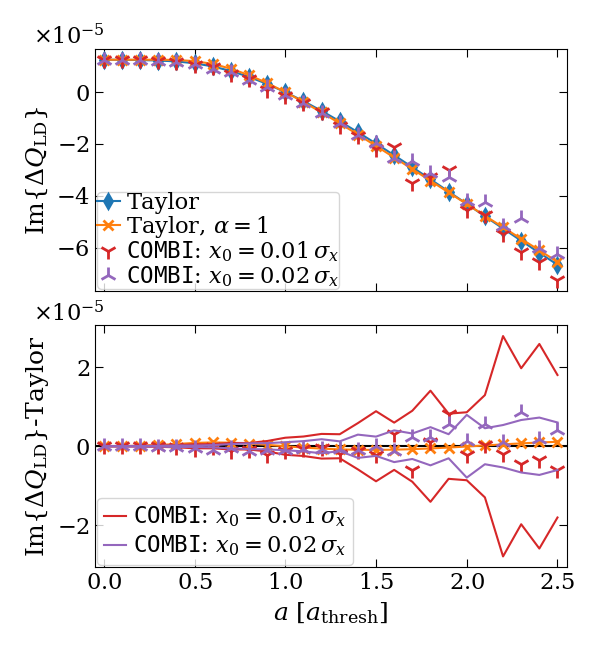

<IPython.core.display.Javascript object>


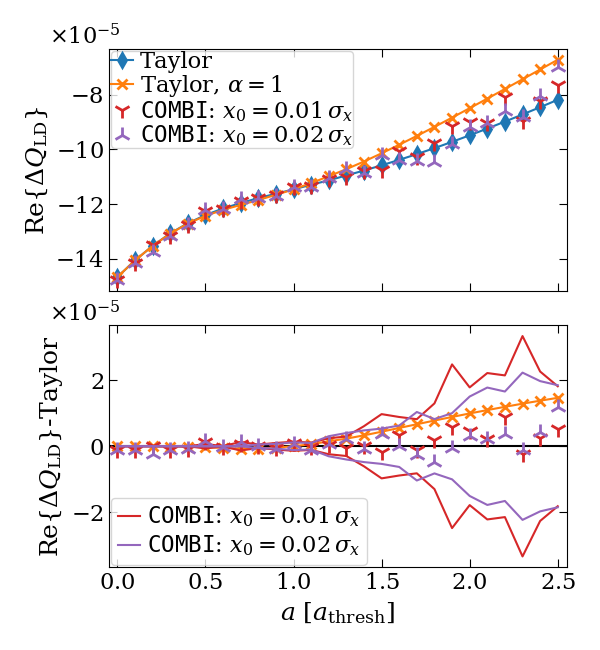

AxesSubplot(0.125,0.53;0.775x0.35)
AxesSubplot(0.125,0.53;0.775x0.35)


In [27]:


# curves = [theory_fa1,theory_fa0,combi_0,combi_2,combi_4]
# curves = [theory_thr_fa1,theory_thr_fa0,combi_thr_1,combi_thr_2,combi_thr_4]
# curves = [theory_thr_fa1,theory_thr_fa0,theory_thr_DI0,combi_thr_1,combi_thr_2,combi_thr_4]
curves = [theory_thr_DI11,theory_thr_DI00,theory_thr_DI11_exact,combi_gw_thr_1,combi_gw_thr_2]
labels = [r'Taylor',r'Taylor, $\alpha=1$','Transfer function',
          r'$\mathtt{COMBI}$: $x_0=0.01\,\sigma_x$',r'$\mathtt{COMBI}$: $x_0=0.02\,\sigma_x$',r'$\mathtt{COMBI}$: $x_0=0.04\,\sigma_x$']
fmts   = ['-d','-x','-+','1','2','3']
 
flag_commonError = 0
flag_oneplot = 1


flag_Qunits = 0
Qunit = [1,a_thr][flag_Qunits]


if flag_oneplot:
    fig1,axs = plt.subplots(2,1,sharex=True,figsize=(figwidth,[1.4,1.3][i_layout]*figheight))
    ax1=axs[0]
    ax2=axs[1]
    
    fig3,axs = plt.subplots(2,1,sharex=True,figsize=(figwidth,[1.4,1.3][i_layout]*figheight))
    ax3=axs[0]
    ax4=axs[1]
    
    ax2.plot([-1,3],[0,0],'k-')
    ax4.plot([-1,3],[0,0],'k-')
#     ax3.axhline(0,'k')
else:
    fig1=plt.figure()
    ax1=fig1.gca()
    fig2=plt.figure()
    ax2=fig2.gca()
    fig3=plt.figure()
    ax3=fig3.gca()
    fig4=plt.figure()
    ax4=fig4.gca()

for i, curve in enumerate(curves):
    if i in [2]:continue
    ms=[7,12][i>2]
    ax1.plot(curve[:,0]/a_thr,curve[:,2]/Qunit,fmts[i],c='C%d'%i,ms=ms,label=labels[i])
    ax3.plot(curve[:,0]/a_thr,curve[:,1]/Qunit,fmts[i],c='C%d'%i,ms=ms,label=labels[i])
    if i>0:
        if i in [1,2] or (flag_commonError):
            ax2.plot(curve[:,0]/a_thr,(curve[:,2]-curves[0][:,2])/Qunit,fmts[i],c='C%d'%i,ms=ms,label=labels[i])
            ax4.plot(curve[:,0]/a_thr,(curve[:,1]-curves[0][:,1])/Qunit,fmts[i],c='C%d'%i,ms=ms,label=labels[i])
        else:
            if 0:
                eb2=ax2.errorbar(x=curve[:,0]/a_thr,y=(curve[:,2]-curves[0][:,2])/Qunit,yerr=curve[:,3]/Qunit,
                             fmt=fmts[i],ls=':',c='C%d'%i,ms=ms,label=labels[i],capsize=5)
                eb4=ax4.errorbar(x=curve[:,0]/a_thr,y=(curve[:,1]-curves[0][:,1])/Qunit,yerr=curve[:,4]/Qunit,
                             fmt=fmts[i],c='C%d'%i,ms=ms,label=labels[i],capsize=5)
                eb2[-1][0].set_linestyle(':') 
                eb4[-1][0].set_linestyle(':') 
            else:
                ax2.plot(curve[:,0]/a_thr,(curve[:,2]-curves[0][:,2])/Qunit,fmts[i],c='C%d'%i,ms=ms)#,label=labels[i])
                ax4.plot(curve[:,0]/a_thr,(curve[:,1]-curves[0][:,1])/Qunit,fmts[i],c='C%d'%i,ms=ms)#,label=labels[i])
                for sign in [1,-1]:
                    ax2.plot(curve[:,0]/a_thr,sign*curve[:,3]/Qunit,c='C%d'%i,label=[labels[i]+'',None][sign>0])
                    ax4.plot(curve[:,0]/a_thr,sign*curve[:,4]/Qunit,c='C%d'%i,label=[labels[i],None][sign>0])

# Add estimate of coherent damping
if 0:
    ax1.plot(curve[:,0]/a_thr,-np.sqrt(1+0.7**2)*curve[:,0]/Qunit,'k-')
    ax1.annotate(text=r'$-\sqrt{a^2+b^2}$',xy=(1,-10e-5),va='top')
    ax1.set_ylim(-12e-5,4e-5)

if flag_commonError:
    errorgr = np.sqrt(np.sum([curves[i][:,3]**2 for i in [3,4]],axis=0)) #+combi_2[:,3]**2+combi_4[:,3]**2))
    errorQ  = np.sqrt(np.sum([curves[i][:,4]**2 for i in [3,4]],axis=0)) #+combi_2[:,3]**2+combi_4[:,3]**2))
#     error[combi_0[:,3]==0] /=np.sqrt(2)
#     error[combi_0[:,3]>0] /= np.sqrt(3)
    
    
    ax2.fill_between(curves[0][:,0]/a_thr,errorgr/Qunit,-errorgr/Qunit,color='lightgray',label=r'$\mathtt{COMBI}$: $1\sigma$ std')
    ax4.fill_between(curves[0][:,0]/a_thr,errorQ/Qunit ,-errorQ/Qunit,color='lightgray',label=r'$\mathtt{COMBI}$: $1\sigma$ std')
    
# plt.plot(theory_fa0[:,0],theory_fa0[:,2],':%s'%markers[1],ms=7,label=r'Taylor, $\alpha=1$')
# plt.plot(theory_fa1[:,0],theory_fa1[:,2],':%s'%markers[2],ms=7,label=r'Taylor')
for ia,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.set_xlabel(r'$a$ $[a_\mathrm{thresh}]$')
    ax.legend(labelspacing=0,borderpad=0,loc=[3,2][ia==2])
    ax.get_yaxis().get_offset_text().set_x(-0.13)
    ax.set_xlim(-0.05,2.55)
    
    #ax.get_yaxis().get_offset_text().set_y(-0.13)  # Does not work...
#     ax.grid(True)

ax1.set_ylabel(r'$\mathrm{Im}\{\Delta Q_\mathrm{LD}\}$')
ax2.set_ylabel(r'$\mathrm{Im}\{\Delta Q_\mathrm{LD}\}$-Taylor')
ax3.set_ylabel(r'$\mathrm{Re}\{\Delta Q_\mathrm{LD}\}$')
ax4.set_ylabel(r'$\mathrm{Re}\{\Delta Q_\mathrm{LD}\}$-Taylor')

if flag_oneplot:
    for i,fig in enumerate([fig1,fig3]):
        ax=[ax1,ax3][i]
        print(ax)
        ax.set_xlabel(None)
        
        ax.ticklabel_format(axis='y',style='sci',scilimits=(-5,-5))
#         ax.yaxis.get_offset_text().set_y(.5)

        fig.tight_layout()
        fig.subplots_adjust(hspace=[0.09,0.14][i_layout])
        
        axb=[ax2,ax4][i]
        axb.get_legend().remove()
        if i >=0:
            handles, labels = axb.get_legend_handles_labels()
            axb.legend(handles=[handles[1]],labels=[labels[1]],loc=3)
            axb.legend(handles= handles[1:],labels=labels[1:],loc=3)
        fig.savefig(pltstorage+'BigOmega_SimVsTaylor_AbsRel_%s.eps'%['Im','Re'][i])

else:
    for i,fig in enumerate([fig1,fig2,fig3,fig4]):
        fig.tight_layout()
        fig.savefig(pltstorage+'BigOmega_SimVsTaylor_%s_%s.eps'%(['Abs','Rel'][i%2],['Im','Re'][i//2]))
    
    
    


<IPython.core.display.Javascript object>


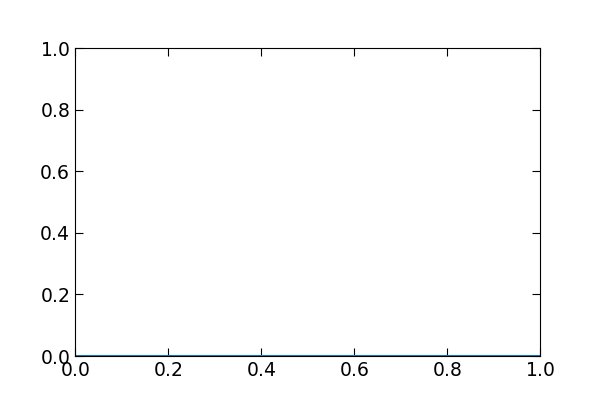

In [192]:
plt.figure()
ax=plt.gca()
ax.axhline(0)

# Unknown

In [100]:
import sys, time, copy
sys.path.append('../')

In [69]:
import numpy as np
import matplotlib.pyplot as plt

from PySSD.Distribution import Distribution,Gaussian
from PySSD.Detuning import LinearDetuning
from PySSD.Dispersion import Dispersion
from PySSD.Integrator import FixedTrapezoidalIntegrator, SimpsonIntegrator, TrapzIntegrator, DblquadIntegrator

#setupQx = 0.31
ax = 3e-5
bx = 0
f_rev = 11.2455e3
Qs = 0.002
Qx=0.31

# Noise 
sigma_ibs=0
D_ibs = f_rev*sigma_ibs**2/2
sigma_k = 1
Pnoise = f_rev*sigma_k**2
D_k = f_rev*sigma_k**2/2

# Modewmode__DQ = [3e-5+1j*2.7e-5]
wmode__DQ = [5e-5+1j*2.86e-5]
# wmode__DQ = [14e-5+1j*0.3e-5]
wmodeQ0 = [Qx]

# PySSD
distribution = Gaussian()
detuning = LinearDetuning(Qx,ax,bx)
integrator = TrapzIntegrator(distribution, detuning, maxJ=18,n_steps=1000)

# Stability diagram parameters
nQ = 60
integrator_epsilon=1e-6 *ax/1e-4 *4
J = np.linspace(3.8,3.9,nQ)
incoQ = Qx*0 + detuning(J,0)

# lebedev
freeQs = J*ax + Qx
cohDQs = np.zeros((len(freeQs)), dtype='complex')
for k, q in enumerate(freeQs):
    cohDQs[k] = (2*integrator.integrate(q,epsilon=integrator_epsilon*1) 
                  -integrator.integrate(q,epsilon=integrator_epsilon*2) )

R = -1/cohDQs
dQ = wmode__DQ

eps =  1+ dQ*R
Dl = D_k *1/np.abs(eps)**2 



# Plotting
plt.figure()
plt.title("Stability diagram and mode")
plt.plot(cohDQs.real,cohDQs.imag)
plt.plot(wmode__DQ[0].real,wmode__DQ[0].imag,'rx')
plt.tight_layout()

plt.figure()
plt.title("Diffusion coefficient")
plt.plot(J,Dl,'r')
plt.xlabel('J')
plt.tight_layout()

ImportError: No module named 'PySSD.Dispersion'